# Train Log 20181201

* Add multi-model training structure

## Results
```

```

## Trained model
* [Download link]()

## Evaluation
* Incorrect sample
![results]()

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import time , datetime

# sys.path.append( os.path.abspath('../../../Dataset/scripts'))
# from utils import *

sys.path.append( os.path.abspath('../../model') )
from train import *

import multiprocessing

import tensorflow as tf


In [2]:
""" Path """
data_train_path = os.path.abspath('../../../new_dataset/dataset/dataset_20181203_01/train.h5')
data_vali_path = os.path.abspath('../../../new_dataset/dataset/dataset_20181203_01/vali.h5')


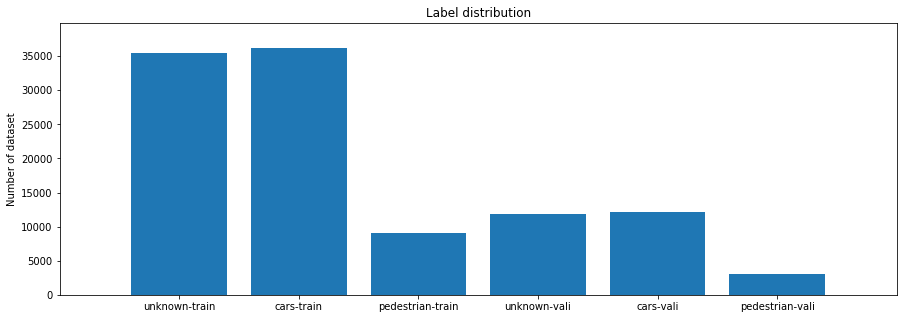

In [3]:
""" Load dataset"""

data = []
class_label = []
heading_label = []

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    class_label = f['class'][:]
    heading_label = f['heading'][:]
    return (data, class_label, heading_label)

data_train, class_label_train, heading_label_train = load_h5(data_train_path)
data_vali, class_label_vali, heading_label_vali = load_h5(data_vali_path)

data.append(data_train)
data.append(data_vali)
class_label.append(class_label_train)
class_label.append(class_label_vali)
heading_label.append(heading_label_train)
heading_label.append(heading_label_vali)

""" Data statistics """

label_list = [0,1,2]

y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(class_label[i] == label_list[j]))

x_name=('unknown-train', 'cars-train','pedestrian-train',
        'unknown-vali', 'cars-vali', 'pedestrian-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [4]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading_2 as MODEL

def run_training(out_path):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(2)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 40

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 100

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=1)
            tf.summary.scalar('loss', loss)
            
            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()

            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
   
            num_batches = current_data.shape[0] // BATCH_SIZE          
    

            """
            Run batch training
            """
#             num_batches = 500
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            
            """
            Evaluation using validation set    
            """
            
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            total_correct = 0
            total_seen = 0
            loss_sum = 0
            heading_rmse_sum = 0
            
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
            
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Summary
                """
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                
                """
                Evaluation
                """
                
                ## classification
                class_pred = pred_val[:,:3]
                heading_pred = pred_val[:,3]
                
                class_pred = np.argmax(class_pred, 1)
                correct = np.sum(class_pred == current_class_label_reshape)
                                
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_class_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == class_pred )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_class_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == class_pred) )
                ## Heading regression
                heading_rmse_sum += np.mean( np.square(heading_pred - current_heading_label_reshape) )
                
                
                
            log_string(  '[Epoch %d] Validation mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation heading rmse[deg]: %f' % \
                       (  epoch, 360. * np.sqrt(heading_rmse_sum / float(num_batches) )  )   )
            log_string(  '[Epoch %d] Validation class accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] Validation avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] Validation indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            """
            Save the variables to disk.
            """
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

                
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_2_out5_1',))
p.start()
p.join()

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-04 23:36:41.532493  

 Train one epoch   1 / 100


100%|██████████| 2019/2019 [11:11<00:00,  3.00it/s]


2018-12-04 23:47:55.364399  [Epoch 0] mean loss: 51.497056
2018-12-04 23:47:55.366285  [Epoch 0] heading rmse[deg]: 407.977859
2018-12-04 23:47:55.368150  [Epoch 0] class accuracy: 0.409138
2018-12-04 23:47:55.370015  [Epoch 0] avg class acc: 0.339577
2018-12-04 23:47:55.371819  [Epoch 0] indivisual [0] class recall: 0.491301
2018-12-04 23:47:55.373590  [Epoch 0] indivisual [0] class precision: 0.448520
2018-12-04 23:47:55.375281  [Epoch 0] indivisual [1] class recall: 0.398096
2018-12-04 23:47:55.377159  [Epoch 0] indivisual [1] class precision: 0.448671
2018-12-04 23:47:55.379106  [Epoch 0] indivisual [2] class recall: 0.129333
2018-12-04 23:47:55.380847  [Epoch 0] indivisual [2] class precision: 0.120037
2018-12-04 23:47:55.382457   Evaluation one (validation set) epoch   1 / 100


100%|██████████| 673/673 [00:46<00:00, 14.45it/s]


2018-12-04 23:48:42.729814  [Epoch 0] Validation mean loss: 6.548441
2018-12-04 23:48:42.731710  [Epoch 0] Validation heading rmse[deg]: 134.948011
2018-12-04 23:48:42.733488  [Epoch 0] Validation class accuracy: 0.504866
2018-12-04 23:48:42.735178  [Epoch 0] Validation avg class acc: 0.094314
2018-12-04 23:48:42.736686  [Epoch 0] Validation indivisual [0] class recall: 0.087610
2018-12-04 23:48:42.738216  [Epoch 0] Validation indivisual [0] class precision: 0.493455
2018-12-04 23:48:42.740030  [Epoch 0] Validation indivisual [1] class recall: 0.195334
2018-12-04 23:48:42.741896  [Epoch 0] Validation indivisual [1] class precision: 0.510045
2018-12-04 23:48:42.743661  [Epoch 0] Validation indivisual [2] class recall: 0.000000
2018-12-04 23:48:42.745442  

 Train one epoch   2 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-04 23:59:54.216358  [Epoch 1] mean loss: 36.274030
2018-12-04 23:59:54.218186  [Epoch 1] heading rmse[deg]: 341.616819
2018-12-04 23:59:54.219849  [Epoch 1] class accuracy: 0.437382
2018-12-04 23:59:54.221682  [Epoch 1] avg class acc: 0.339892
2018-12-04 23:59:54.223351  [Epoch 1] indivisual [0] class recall: 0.494200
2018-12-04 23:59:54.224998  [Epoch 1] indivisual [0] class precision: 0.449906
2018-12-04 23:59:54.226941  [Epoch 1] indivisual [1] class recall: 0.478698
2018-12-04 23:59:54.228992  [Epoch 1] indivisual [1] class precision: 0.453459
2018-12-04 23:59:54.230677  [Epoch 1] indivisual [2] class recall: 0.046778
2018-12-04 23:59:54.232440  [Epoch 1] indivisual [2] class precision: 0.120769
2018-12-04 23:59:54.234163   Evaluation one (validation set) epoch   2 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 00:00:40.978075  [Epoch 1] Validation mean loss: 8.085046
2018-12-05 00:00:40.980069  [Epoch 1] Validation heading rmse[deg]: 121.456888
2018-12-05 00:00:40.981873  [Epoch 1] Validation class accuracy: 0.527897
2018-12-05 00:00:40.983980  [Epoch 1] Validation avg class acc: 0.099739
2018-12-05 00:00:40.985969  [Epoch 1] Validation indivisual [0] class recall: 0.072824
2018-12-05 00:00:40.987868  [Epoch 1] Validation indivisual [0] class precision: 0.681899
2018-12-05 00:00:40.989697  [Epoch 1] Validation indivisual [1] class recall: 0.221390
2018-12-05 00:00:40.991415  [Epoch 1] Validation indivisual [1] class precision: 0.491392
2018-12-05 00:00:40.993149  [Epoch 1] Validation indivisual [2] class recall: 0.005001
2018-12-05 00:00:40.994907  [Epoch 1] Validation indivisual [2] class precision: 0.731707
2018-12-05 00:00:40.996646  

 Train one epoch   3 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 00:11:52.607489  [Epoch 2] mean loss: 29.067209
2018-12-05 00:11:52.609426  [Epoch 2] heading rmse[deg]: 305.463815
2018-12-05 00:11:52.611148  [Epoch 2] class accuracy: 0.438522
2018-12-05 00:11:52.612947  [Epoch 2] avg class acc: 0.334801
2018-12-05 00:11:52.615058  [Epoch 2] indivisual [0] class recall: 0.471988
2018-12-05 00:11:52.617356  [Epoch 2] indivisual [0] class precision: 0.440130
2018-12-05 00:11:52.619123  [Epoch 2] indivisual [1] class recall: 0.508747
2018-12-05 00:11:52.620882  [Epoch 2] indivisual [1] class precision: 0.448120
2018-12-05 00:11:52.622596  [Epoch 2] indivisual [2] class recall: 0.023667
2018-12-05 00:11:52.624358  [Epoch 2] indivisual [2] class precision: 0.139581
2018-12-05 00:11:52.626040   Evaluation one (validation set) epoch   3 / 100


100%|██████████| 673/673 [00:46<00:00, 14.51it/s]


2018-12-05 00:12:39.497999  [Epoch 2] Validation mean loss: 7.295812
2018-12-05 00:12:39.499970  [Epoch 2] Validation heading rmse[deg]: 108.891292
2018-12-05 00:12:39.501669  [Epoch 2] Validation class accuracy: 0.489599
2018-12-05 00:12:39.503428  [Epoch 2] Validation avg class acc: 0.091096
2018-12-05 00:12:39.505243  [Epoch 2] Validation indivisual [0] class recall: 0.033531
2018-12-05 00:12:39.507871  [Epoch 2] Validation indivisual [0] class precision: 0.665130
2018-12-05 00:12:39.509638  [Epoch 2] Validation indivisual [1] class recall: 0.239758
2018-12-05 00:12:39.511593  [Epoch 2] Validation indivisual [1] class precision: 0.472528
2018-12-05 00:12:39.513433  [Epoch 2] Validation indivisual [2] class recall: 0.000000
2018-12-05 00:12:39.515413  

 Train one epoch   4 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 00:23:51.056681  [Epoch 3] mean loss: 23.699977
2018-12-05 00:23:51.058674  [Epoch 3] heading rmse[deg]: 275.706110
2018-12-05 00:23:51.060558  [Epoch 3] class accuracy: 0.441481
2018-12-05 00:23:51.062485  [Epoch 3] avg class acc: 0.335421
2018-12-05 00:23:51.064248  [Epoch 3] indivisual [0] class recall: 0.485980
2018-12-05 00:23:51.066013  [Epoch 3] indivisual [0] class precision: 0.441348
2018-12-05 00:23:51.068091  [Epoch 3] indivisual [1] class recall: 0.503284
2018-12-05 00:23:51.070185  [Epoch 3] indivisual [1] class precision: 0.449946
2018-12-05 00:23:51.071984  [Epoch 3] indivisual [2] class recall: 0.017000
2018-12-05 00:23:51.073703  [Epoch 3] indivisual [2] class precision: 0.137590
2018-12-05 00:23:51.075377   Evaluation one (validation set) epoch   4 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 00:24:37.804697  [Epoch 3] Validation mean loss: 8.502085
2018-12-05 00:24:37.806261  [Epoch 3] Validation heading rmse[deg]: 109.620081
2018-12-05 00:24:37.807722  [Epoch 3] Validation class accuracy: 0.481835
2018-12-05 00:24:37.809144  [Epoch 3] Validation avg class acc: 0.089749
2018-12-05 00:24:37.810450  [Epoch 3] Validation indivisual [0] class recall: 0.046227
2018-12-05 00:24:37.811791  [Epoch 3] Validation indivisual [0] class precision: 0.554486
2018-12-05 00:24:37.813205  [Epoch 3] Validation indivisual [1] class recall: 0.223020
2018-12-05 00:24:37.814992  [Epoch 3] Validation indivisual [1] class precision: 0.469357
2018-12-05 00:24:37.816759  [Epoch 3] Validation indivisual [2] class recall: 0.000000
2018-12-05 00:24:37.818469  

 Train one epoch   5 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 00:35:49.284416  [Epoch 4] mean loss: 20.757487
2018-12-05 00:35:49.286382  [Epoch 4] heading rmse[deg]: 258.984551
2018-12-05 00:35:49.288200  [Epoch 4] class accuracy: 0.444762
2018-12-05 00:35:49.290076  [Epoch 4] avg class acc: 0.337029
2018-12-05 00:35:49.291732  [Epoch 4] indivisual [0] class recall: 0.478378
2018-12-05 00:35:49.293327  [Epoch 4] indivisual [0] class precision: 0.442661
2018-12-05 00:35:49.294935  [Epoch 4] indivisual [1] class recall: 0.518819
2018-12-05 00:35:49.296623  [Epoch 4] indivisual [1] class precision: 0.453137
2018-12-05 00:35:49.298264  [Epoch 4] indivisual [2] class recall: 0.013889
2018-12-05 00:35:49.299898  [Epoch 4] indivisual [2] class precision: 0.141884
2018-12-05 00:35:49.301507   Evaluation one (validation set) epoch   5 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 00:36:36.020923  [Epoch 4] Validation mean loss: 5.852305
2018-12-05 00:36:36.022722  [Epoch 4] Validation heading rmse[deg]: 116.461455
2018-12-05 00:36:36.024486  [Epoch 4] Validation class accuracy: 0.449071
2018-12-05 00:36:36.026276  [Epoch 4] Validation avg class acc: 0.083405
2018-12-05 00:36:36.028138  [Epoch 4] Validation indivisual [0] class recall: 0.007838
2018-12-05 00:36:36.030051  [Epoch 4] Validation indivisual [0] class precision: 0.452439
2018-12-05 00:36:36.031832  [Epoch 4] Validation indivisual [1] class recall: 0.242378
2018-12-05 00:36:36.033604  [Epoch 4] Validation indivisual [1] class precision: 0.448966
2018-12-05 00:36:36.035286  [Epoch 4] Validation indivisual [2] class recall: 0.000000
2018-12-05 00:36:36.037043  

 Train one epoch   6 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 00:47:47.404428  [Epoch 5] mean loss: 18.251132
2018-12-05 00:47:47.406471  [Epoch 5] heading rmse[deg]: 242.121165
2018-12-05 00:47:47.408494  [Epoch 5] class accuracy: 0.443796
2018-12-05 00:47:47.410372  [Epoch 5] avg class acc: 0.334697
2018-12-05 00:47:47.412208  [Epoch 5] indivisual [0] class recall: 0.478491
2018-12-05 00:47:47.413905  [Epoch 5] indivisual [0] class precision: 0.441111
2018-12-05 00:47:47.415632  [Epoch 5] indivisual [1] class recall: 0.518157
2018-12-05 00:47:47.417281  [Epoch 5] indivisual [1] class precision: 0.451981
2018-12-05 00:47:47.418851  [Epoch 5] indivisual [2] class recall: 0.007444
2018-12-05 00:47:47.420588  [Epoch 5] indivisual [2] class precision: 0.097953
2018-12-05 00:47:47.422217   Evaluation one (validation set) epoch   6 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 00:48:34.156604  [Epoch 5] Validation mean loss: 4.840573
2018-12-05 00:48:34.158350  [Epoch 5] Validation heading rmse[deg]: 115.221715
2018-12-05 00:48:34.160209  [Epoch 5] Validation class accuracy: 0.443574
2018-12-05 00:48:34.162020  [Epoch 5] Validation avg class acc: 0.082335
2018-12-05 00:48:34.163975  [Epoch 5] Validation indivisual [0] class recall: 0.002409
2018-12-05 00:48:34.166008  [Epoch 5] Validation indivisual [0] class precision: 0.251656
2018-12-05 00:48:34.167858  [Epoch 5] Validation indivisual [1] class recall: 0.244597
2018-12-05 00:48:34.169702  [Epoch 5] Validation indivisual [1] class precision: 0.446858
2018-12-05 00:48:34.171472  [Epoch 5] Validation indivisual [2] class recall: 0.000000
2018-12-05 00:48:34.173289  

 Train one epoch   7 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 00:59:45.184101  [Epoch 6] mean loss: 15.966911
2018-12-05 00:59:45.186134  [Epoch 6] heading rmse[deg]: 226.555560
2018-12-05 00:59:45.188091  [Epoch 6] class accuracy: 0.442831
2018-12-05 00:59:45.189984  [Epoch 6] avg class acc: 0.334731
2018-12-05 00:59:45.191959  [Epoch 6] indivisual [0] class recall: 0.469932
2018-12-05 00:59:45.193572  [Epoch 6] indivisual [0] class precision: 0.439529
2018-12-05 00:59:45.195282  [Epoch 6] indivisual [1] class recall: 0.523593
2018-12-05 00:59:45.196945  [Epoch 6] indivisual [1] class precision: 0.450745
2018-12-05 00:59:45.198691  [Epoch 6] indivisual [2] class recall: 0.010667
2018-12-05 00:59:45.200826  [Epoch 6] indivisual [2] class precision: 0.139942
2018-12-05 00:59:45.202605   Evaluation one (validation set) epoch   7 / 100


100%|██████████| 673/673 [00:46<00:00, 14.59it/s]


2018-12-05 01:00:31.749644  [Epoch 6] Validation mean loss: 4.555067
2018-12-05 01:00:31.751484  [Epoch 6] Validation heading rmse[deg]: 112.293873
2018-12-05 01:00:31.753266  [Epoch 6] Validation class accuracy: 0.447994
2018-12-05 01:00:31.755044  [Epoch 6] Validation avg class acc: 0.083328
2018-12-05 01:00:31.756642  [Epoch 6] Validation indivisual [0] class recall: 0.027149
2018-12-05 01:00:31.758575  [Epoch 6] Validation indivisual [0] class precision: 0.308523
2018-12-05 01:00:31.760582  [Epoch 6] Validation indivisual [1] class recall: 0.222836
2018-12-05 01:00:31.762308  [Epoch 6] Validation indivisual [1] class precision: 0.473522
2018-12-05 01:00:31.764077  [Epoch 6] Validation indivisual [2] class recall: 0.000000
2018-12-05 01:00:31.765790  

 Train one epoch   8 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 01:11:42.295496  [Epoch 7] mean loss: 13.739134
2018-12-05 01:11:42.297457  [Epoch 7] heading rmse[deg]: 210.385370
2018-12-05 01:11:42.299249  [Epoch 7] class accuracy: 0.440527
2018-12-05 01:11:42.301110  [Epoch 7] avg class acc: 0.333504
2018-12-05 01:11:42.302735  [Epoch 7] indivisual [0] class recall: 0.463148
2018-12-05 01:11:42.304345  [Epoch 7] indivisual [0] class precision: 0.436992
2018-12-05 01:11:42.306011  [Epoch 7] indivisual [1] class recall: 0.524586
2018-12-05 01:11:42.308011  [Epoch 7] indivisual [1] class precision: 0.449114
2018-12-05 01:11:42.310089  [Epoch 7] indivisual [2] class recall: 0.012778
2018-12-05 01:11:42.311896  [Epoch 7] indivisual [2] class precision: 0.146684
2018-12-05 01:11:42.313635   Evaluation one (validation set) epoch   8 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 01:12:29.051116  [Epoch 7] Validation mean loss: 3.710600
2018-12-05 01:12:29.053000  [Epoch 7] Validation heading rmse[deg]: 107.548165
2018-12-05 01:12:29.054818  [Epoch 7] Validation class accuracy: 0.438596
2018-12-05 01:12:29.056651  [Epoch 7] Validation avg class acc: 0.083052
2018-12-05 01:12:29.058375  [Epoch 7] Validation indivisual [0] class recall: 0.235671
2018-12-05 01:12:29.060240  [Epoch 7] Validation indivisual [0] class precision: 0.436886
2018-12-05 01:12:29.061999  [Epoch 7] Validation indivisual [1] class recall: 0.013485
2018-12-05 01:12:29.063720  [Epoch 7] Validation indivisual [1] class precision: 0.470079
2018-12-05 01:12:29.065245  [Epoch 7] Validation indivisual [2] class recall: 0.000000
2018-12-05 01:12:29.067048  

 Train one epoch   9 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 01:23:40.254350  [Epoch 8] mean loss: 12.181878
2018-12-05 01:23:40.256242  [Epoch 8] heading rmse[deg]: 197.603060
2018-12-05 01:23:40.258008  [Epoch 8] class accuracy: 0.444737
2018-12-05 01:23:40.259842  [Epoch 8] avg class acc: 0.337271
2018-12-05 01:23:40.261526  [Epoch 8] indivisual [0] class recall: 0.471537
2018-12-05 01:23:40.263060  [Epoch 8] indivisual [0] class precision: 0.442568
2018-12-05 01:23:40.264601  [Epoch 8] indivisual [1] class recall: 0.525166
2018-12-05 01:23:40.266095  [Epoch 8] indivisual [1] class precision: 0.451241
2018-12-05 01:23:40.267995  [Epoch 8] indivisual [2] class recall: 0.015111
2018-12-05 01:23:40.270032  [Epoch 8] indivisual [2] class precision: 0.184282
2018-12-05 01:23:40.271774   Evaluation one (validation set) epoch   9 / 100


100%|██████████| 673/673 [00:46<00:00, 14.57it/s]


2018-12-05 01:24:26.906335  [Epoch 8] Validation mean loss: 3.609132
2018-12-05 01:24:26.908273  [Epoch 8] Validation heading rmse[deg]: 106.487773
2018-12-05 01:24:26.910085  [Epoch 8] Validation class accuracy: 0.435773
2018-12-05 01:24:26.912136  [Epoch 8] Validation avg class acc: 0.082615
2018-12-05 01:24:26.914020  [Epoch 8] Validation indivisual [0] class recall: 0.247845
2018-12-05 01:24:26.915784  [Epoch 8] Validation indivisual [0] class precision: 0.437088
2018-12-05 01:24:26.917517  [Epoch 8] Validation indivisual [1] class recall: 0.000000
2018-12-05 01:24:26.919209  [Epoch 8] Validation indivisual [1] class precision: 0.000000
2018-12-05 01:24:26.920941  [Epoch 8] Validation indivisual [2] class recall: 0.000000
2018-12-05 01:24:26.922581  

 Train one epoch  10 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 01:35:37.867097  [Epoch 9] mean loss: 10.899294
2018-12-05 01:35:37.868964  [Epoch 9] heading rmse[deg]: 186.996135
2018-12-05 01:35:37.870559  [Epoch 9] class accuracy: 0.448341
2018-12-05 01:35:37.872297  [Epoch 9] avg class acc: 0.340067
2018-12-05 01:35:37.873882  [Epoch 9] indivisual [0] class recall: 0.464358
2018-12-05 01:35:37.875882  [Epoch 9] indivisual [0] class precision: 0.444175
2018-12-05 01:35:37.877906  [Epoch 9] indivisual [1] class recall: 0.540066
2018-12-05 01:35:37.879648  [Epoch 9] indivisual [1] class precision: 0.456905
2018-12-05 01:35:37.881403  [Epoch 9] indivisual [2] class recall: 0.015778
2018-12-05 01:35:37.883039  [Epoch 9] indivisual [2] class precision: 0.179747
2018-12-05 01:35:37.884721   Evaluation one (validation set) epoch  10 / 100


100%|██████████| 673/673 [00:46<00:00, 14.53it/s]


2018-12-05 01:36:24.660397  [Epoch 9] Validation mean loss: 3.821156
2018-12-05 01:36:24.662236  [Epoch 9] Validation heading rmse[deg]: 110.133366
2018-12-05 01:36:24.664238  [Epoch 9] Validation class accuracy: 0.429532
2018-12-05 01:36:24.666334  [Epoch 9] Validation avg class acc: 0.081429
2018-12-05 01:36:24.668167  [Epoch 9] Validation indivisual [0] class recall: 0.244079
2018-12-05 01:36:24.669974  [Epoch 9] Validation indivisual [0] class precision: 0.435125
2018-12-05 01:36:24.671710  [Epoch 9] Validation indivisual [1] class recall: 0.000207
2018-12-05 01:36:24.673489  [Epoch 9] Validation indivisual [1] class precision: 0.027100
2018-12-05 01:36:24.675274  [Epoch 9] Validation indivisual [2] class recall: 0.000000
2018-12-05 01:36:25.615352  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_2_out5_1/model.ckpt
2018-12-05 01:36:25.617246  

 Train one epoch  11 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 01:47:36.078567  [Epoch 10] mean loss: 10.119339
2018-12-05 01:47:36.080542  [Epoch 10] heading rmse[deg]: 180.194557
2018-12-05 01:47:36.082278  [Epoch 10] class accuracy: 0.449084
2018-12-05 01:47:36.084160  [Epoch 10] avg class acc: 0.339824
2018-12-05 01:47:36.085985  [Epoch 10] indivisual [0] class recall: 0.461937
2018-12-05 01:47:36.087825  [Epoch 10] indivisual [0] class precision: 0.444481
2018-12-05 01:47:36.089849  [Epoch 10] indivisual [1] class recall: 0.544868
2018-12-05 01:47:36.091923  [Epoch 10] indivisual [1] class precision: 0.457963
2018-12-05 01:47:36.093649  [Epoch 10] indivisual [2] class recall: 0.012667
2018-12-05 01:47:36.095358  [Epoch 10] indivisual [2] class precision: 0.156593
2018-12-05 01:47:36.097082   Evaluation one (validation set) epoch  11 / 100


100%|██████████| 673/673 [00:46<00:00, 14.53it/s]


2018-12-05 01:48:22.887159  [Epoch 10] Validation mean loss: 3.527590
2018-12-05 01:48:22.888908  [Epoch 10] Validation heading rmse[deg]: 105.862021
2018-12-05 01:48:22.890593  [Epoch 10] Validation class accuracy: 0.437593
2018-12-05 01:48:22.892443  [Epoch 10] Validation avg class acc: 0.082958
2018-12-05 01:48:22.894302  [Epoch 10] Validation indivisual [0] class recall: 0.248875
2018-12-05 01:48:22.896271  [Epoch 10] Validation indivisual [0] class precision: 0.439110
2018-12-05 01:48:22.898098  [Epoch 10] Validation indivisual [1] class recall: 0.000000
2018-12-05 01:48:22.899899  [Epoch 10] Validation indivisual [1] class precision: 0.000000
2018-12-05 01:48:22.901698  [Epoch 10] Validation indivisual [2] class recall: 0.000000
2018-12-05 01:48:22.903466  

 Train one epoch  12 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 01:59:34.197005  [Epoch 11] mean loss: 9.086503
2018-12-05 01:59:34.199071  [Epoch 11] heading rmse[deg]: 171.342793
2018-12-05 01:59:34.200884  [Epoch 11] class accuracy: 0.442311
2018-12-05 01:59:34.202861  [Epoch 11] avg class acc: 0.333182
2018-12-05 01:59:34.204803  [Epoch 11] indivisual [0] class recall: 0.454195
2018-12-05 01:59:34.206595  [Epoch 11] indivisual [0] class precision: 0.439089
2018-12-05 01:59:34.208357  [Epoch 11] indivisual [1] class recall: 0.538907
2018-12-05 01:59:34.209979  [Epoch 11] indivisual [1] class precision: 0.450477
2018-12-05 01:59:34.211714  [Epoch 11] indivisual [2] class recall: 0.006444
2018-12-05 01:59:34.213349  [Epoch 11] indivisual [2] class precision: 0.087349
2018-12-05 01:59:34.214892   Evaluation one (validation set) epoch  12 / 100


100%|██████████| 673/673 [00:46<00:00, 14.57it/s]


2018-12-05 02:00:20.832990  [Epoch 11] Validation mean loss: 3.532033
2018-12-05 02:00:20.834833  [Epoch 11] Validation heading rmse[deg]: 106.167128
2018-12-05 02:00:20.836707  [Epoch 11] Validation class accuracy: 0.437853
2018-12-05 02:00:20.838611  [Epoch 11] Validation avg class acc: 0.083002
2018-12-05 02:00:20.840492  [Epoch 11] Validation indivisual [0] class recall: 0.247993
2018-12-05 02:00:20.842177  [Epoch 11] Validation indivisual [0] class precision: 0.438591
2018-12-05 02:00:20.843995  [Epoch 11] Validation indivisual [1] class recall: 0.001013
2018-12-05 02:00:20.845721  [Epoch 11] Validation indivisual [1] class precision: 0.312102
2018-12-05 02:00:20.847357  [Epoch 11] Validation indivisual [2] class recall: 0.000000
2018-12-05 02:00:20.848956  

 Train one epoch  13 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 02:11:31.302199  [Epoch 12] mean loss: 8.587994
2018-12-05 02:11:31.304221  [Epoch 12] heading rmse[deg]: 166.423302
2018-12-05 02:11:31.306289  [Epoch 12] class accuracy: 0.444465
2018-12-05 02:11:31.308573  [Epoch 12] avg class acc: 0.333778
2018-12-05 02:11:31.310377  [Epoch 12] indivisual [0] class recall: 0.453857
2018-12-05 02:11:31.312176  [Epoch 12] indivisual [0] class precision: 0.444105
2018-12-05 02:11:31.313910  [Epoch 12] indivisual [1] class recall: 0.545033
2018-12-05 02:11:31.315636  [Epoch 12] indivisual [1] class precision: 0.449962
2018-12-05 02:11:31.317423  [Epoch 12] indivisual [2] class recall: 0.002444
2018-12-05 02:11:31.319121  [Epoch 12] indivisual [2] class precision: 0.039076
2018-12-05 02:11:31.320785   Evaluation one (validation set) epoch  13 / 100


100%|██████████| 673/673 [00:46<00:00, 14.57it/s]


2018-12-05 02:12:17.942009  [Epoch 12] Validation mean loss: 3.448855
2018-12-05 02:12:17.943970  [Epoch 12] Validation heading rmse[deg]: 105.240501
2018-12-05 02:12:17.945807  [Epoch 12] Validation class accuracy: 0.438856
2018-12-05 02:12:17.947992  [Epoch 12] Validation avg class acc: 0.083196
2018-12-05 02:12:17.949980  [Epoch 12] Validation indivisual [0] class recall: 0.249588
2018-12-05 02:12:17.951831  [Epoch 12] Validation indivisual [0] class precision: 0.438856
2018-12-05 02:12:17.953673  [Epoch 12] Validation indivisual [1] class recall: 0.000000
2018-12-05 02:12:17.955401  [Epoch 12] Validation indivisual [2] class recall: 0.000000
2018-12-05 02:12:17.957181  

 Train one epoch  14 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 02:23:28.743320  [Epoch 13] mean loss: 7.515102
2018-12-05 02:23:28.745360  [Epoch 13] heading rmse[deg]: 155.474440
2018-12-05 02:23:28.747115  [Epoch 13] class accuracy: 0.445059
2018-12-05 02:23:28.748974  [Epoch 13] avg class acc: 0.333955
2018-12-05 02:23:28.750694  [Epoch 13] indivisual [0] class recall: 0.447579
2018-12-05 02:23:28.752368  [Epoch 13] indivisual [0] class precision: 0.443249
2018-12-05 02:23:28.754091  [Epoch 13] indivisual [1] class recall: 0.552732
2018-12-05 02:23:28.755782  [Epoch 13] indivisual [1] class precision: 0.449367
2018-12-05 02:23:28.757525  [Epoch 13] indivisual [2] class recall: 0.001556
2018-12-05 02:23:28.759145  [Epoch 13] indivisual [2] class precision: 0.044164
2018-12-05 02:23:28.760693   Evaluation one (validation set) epoch  14 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 02:24:15.423966  [Epoch 13] Validation mean loss: 3.734090
2018-12-05 02:24:15.425964  [Epoch 13] Validation heading rmse[deg]: 107.184287
2018-12-05 02:24:15.427879  [Epoch 13] Validation class accuracy: 0.457132
2018-12-05 02:24:15.429757  [Epoch 13] Validation avg class acc: 0.086482
2018-12-05 02:24:15.431594  [Epoch 13] Validation indivisual [0] class recall: 0.233615
2018-12-05 02:24:15.433557  [Epoch 13] Validation indivisual [0] class precision: 0.444520
2018-12-05 02:24:15.435350  [Epoch 13] Validation indivisual [1] class recall: 0.025831
2018-12-05 02:24:15.437170  [Epoch 13] Validation indivisual [1] class precision: 0.610459
2018-12-05 02:24:15.438937  [Epoch 13] Validation indivisual [2] class recall: 0.000000
2018-12-05 02:24:15.440701  

 Train one epoch  15 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 02:35:26.631932  [Epoch 14] mean loss: 6.919292
2018-12-05 02:35:26.633906  [Epoch 14] heading rmse[deg]: 149.343222
2018-12-05 02:35:26.635610  [Epoch 14] class accuracy: 0.446000
2018-12-05 02:35:26.637466  [Epoch 14] avg class acc: 0.334536
2018-12-05 02:35:26.639163  [Epoch 14] indivisual [0] class recall: 0.459065
2018-12-05 02:35:26.640838  [Epoch 14] indivisual [0] class precision: 0.444075
2018-12-05 02:35:26.642488  [Epoch 14] indivisual [1] class recall: 0.543764
2018-12-05 02:35:26.644268  [Epoch 14] indivisual [1] class precision: 0.449652
2018-12-05 02:35:26.645972  [Epoch 14] indivisual [2] class recall: 0.000778
2018-12-05 02:35:26.647649  [Epoch 14] indivisual [2] class precision: 0.032407
2018-12-05 02:35:26.649275   Evaluation one (validation set) epoch  15 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 02:36:13.307487  [Epoch 14] Validation mean loss: 3.919560
2018-12-05 02:36:13.309223  [Epoch 14] Validation heading rmse[deg]: 108.658949
2018-12-05 02:36:13.311007  [Epoch 14] Validation class accuracy: 0.453975
2018-12-05 02:36:13.312841  [Epoch 14] Validation avg class acc: 0.085915
2018-12-05 02:36:13.314536  [Epoch 14] Validation indivisual [0] class recall: 0.235801
2018-12-05 02:36:13.316413  [Epoch 14] Validation indivisual [0] class precision: 0.443315
2018-12-05 02:36:13.318321  [Epoch 14] Validation indivisual [1] class recall: 0.021942
2018-12-05 02:36:13.320131  [Epoch 14] Validation indivisual [1] class precision: 0.607675
2018-12-05 02:36:13.321890  [Epoch 14] Validation indivisual [2] class recall: 0.000000
2018-12-05 02:36:13.323649  

 Train one epoch  16 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 02:47:24.073875  [Epoch 15] mean loss: 6.506301
2018-12-05 02:47:24.075521  [Epoch 15] heading rmse[deg]: 144.912671
2018-12-05 02:47:24.076986  [Epoch 15] class accuracy: 0.449319
2018-12-05 02:47:24.078630  [Epoch 15] avg class acc: 0.337521
2018-12-05 02:47:24.080198  [Epoch 15] indivisual [0] class recall: 0.466244
2018-12-05 02:47:24.081776  [Epoch 15] indivisual [0] class precision: 0.445883
2018-12-05 02:47:24.083242  [Epoch 15] indivisual [1] class recall: 0.543653
2018-12-05 02:47:24.084800  [Epoch 15] indivisual [1] class precision: 0.453597
2018-12-05 02:47:24.086275  [Epoch 15] indivisual [2] class recall: 0.002667
2018-12-05 02:47:24.087783  [Epoch 15] indivisual [2] class precision: 0.131148
2018-12-05 02:47:24.089223   Evaluation one (validation set) epoch  16 / 100


100%|██████████| 673/673 [00:46<00:00, 14.53it/s]


2018-12-05 02:48:10.833777  [Epoch 15] Validation mean loss: 4.491559
2018-12-05 02:48:10.835640  [Epoch 15] Validation heading rmse[deg]: 112.839141
2018-12-05 02:48:10.837605  [Epoch 15] Validation class accuracy: 0.435030
2018-12-05 02:48:10.839678  [Epoch 15] Validation avg class acc: 0.082358
2018-12-05 02:48:10.841627  [Epoch 15] Validation indivisual [0] class recall: 0.230282
2018-12-05 02:48:10.843605  [Epoch 15] Validation indivisual [0] class precision: 0.432706
2018-12-05 02:48:10.845477  [Epoch 15] Validation indivisual [1] class recall: 0.016793
2018-12-05 02:48:10.847286  [Epoch 15] Validation indivisual [1] class precision: 0.468822
2018-12-05 02:48:10.849044  [Epoch 15] Validation indivisual [2] class recall: 0.000000
2018-12-05 02:48:10.850746  

 Train one epoch  17 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 02:59:22.355894  [Epoch 16] mean loss: 5.969880
2018-12-05 02:59:22.357948  [Epoch 16] heading rmse[deg]: 138.470424
2018-12-05 02:59:22.359936  [Epoch 16] class accuracy: 0.448341
2018-12-05 02:59:22.362073  [Epoch 16] avg class acc: 0.336547
2018-12-05 02:59:22.364043  [Epoch 16] indivisual [0] class recall: 0.454026
2018-12-05 02:59:22.365889  [Epoch 16] indivisual [0] class precision: 0.445436
2018-12-05 02:59:22.367680  [Epoch 16] indivisual [1] class recall: 0.553615
2018-12-05 02:59:22.369408  [Epoch 16] indivisual [1] class precision: 0.452012
2018-12-05 02:59:22.371084  [Epoch 16] indivisual [2] class recall: 0.002000
2018-12-05 02:59:22.372641  [Epoch 16] indivisual [2] class precision: 0.106509
2018-12-05 02:59:22.374284   Evaluation one (validation set) epoch  17 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 03:00:09.105996  [Epoch 16] Validation mean loss: 3.547368
2018-12-05 03:00:09.108241  [Epoch 16] Validation heading rmse[deg]: 106.587247
2018-12-05 03:00:09.110099  [Epoch 16] Validation class accuracy: 0.438782
2018-12-05 03:00:09.111970  [Epoch 16] Validation avg class acc: 0.083185
2018-12-05 03:00:09.113683  [Epoch 16] Validation indivisual [0] class recall: 0.249556
2018-12-05 03:00:09.115443  [Epoch 16] Validation indivisual [0] class precision: 0.438782
2018-12-05 03:00:09.117134  [Epoch 16] Validation indivisual [1] class recall: 0.000000
2018-12-05 03:00:09.118719  [Epoch 16] Validation indivisual [2] class recall: 0.000000
2018-12-05 03:00:09.120441  

 Train one epoch  18 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 03:11:20.398504  [Epoch 17] mean loss: 5.549474
2018-12-05 03:11:20.400553  [Epoch 17] heading rmse[deg]: 133.726726
2018-12-05 03:11:20.402450  [Epoch 17] class accuracy: 0.446112
2018-12-05 03:11:20.404815  [Epoch 17] avg class acc: 0.334680
2018-12-05 03:11:20.406686  [Epoch 17] indivisual [0] class recall: 0.447297
2018-12-05 03:11:20.408246  [Epoch 17] indivisual [0] class precision: 0.441358
2018-12-05 03:11:20.409804  [Epoch 17] indivisual [1] class recall: 0.555408
2018-12-05 03:11:20.411262  [Epoch 17] indivisual [1] class precision: 0.451280
2018-12-05 03:11:20.412666  [Epoch 17] indivisual [2] class recall: 0.001333
2018-12-05 03:11:20.414007  [Epoch 17] indivisual [2] class precision: 0.075000
2018-12-05 03:11:20.415395   Evaluation one (validation set) epoch  18 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 03:12:07.106124  [Epoch 17] Validation mean loss: 3.919808
2018-12-05 03:12:07.108110  [Epoch 17] Validation heading rmse[deg]: 108.279707
2018-12-05 03:12:07.109974  [Epoch 17] Validation class accuracy: 0.448440
2018-12-05 03:12:07.111923  [Epoch 17] Validation avg class acc: 0.084937
2018-12-05 03:12:07.113653  [Epoch 17] Validation indivisual [0] class recall: 0.243868
2018-12-05 03:12:07.115586  [Epoch 17] Validation indivisual [0] class precision: 0.441973
2018-12-05 03:12:07.117369  [Epoch 17] Validation indivisual [1] class recall: 0.010942
2018-12-05 03:12:07.119048  [Epoch 17] Validation indivisual [1] class precision: 0.658780
2018-12-05 03:12:07.120737  [Epoch 17] Validation indivisual [2] class recall: 0.000000
2018-12-05 03:12:07.122490  

 Train one epoch  19 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 03:23:17.930247  [Epoch 18] mean loss: 5.302914
2018-12-05 03:23:17.932306  [Epoch 18] heading rmse[deg]: 130.691618
2018-12-05 03:23:17.934228  [Epoch 18] class accuracy: 0.445480
2018-12-05 03:23:17.936161  [Epoch 18] avg class acc: 0.334405
2018-12-05 03:23:17.938090  [Epoch 18] indivisual [0] class recall: 0.451492
2018-12-05 03:23:17.939995  [Epoch 18] indivisual [0] class precision: 0.440311
2018-12-05 03:23:17.941824  [Epoch 18] indivisual [1] class recall: 0.549724
2018-12-05 03:23:17.943533  [Epoch 18] indivisual [1] class precision: 0.450928
2018-12-05 03:23:17.945202  [Epoch 18] indivisual [2] class recall: 0.002000
2018-12-05 03:23:17.946843  [Epoch 18] indivisual [2] class precision: 0.113924
2018-12-05 03:23:17.948464   Evaluation one (validation set) epoch  19 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 03:24:04.660153  [Epoch 18] Validation mean loss: 4.738429
2018-12-05 03:24:04.662244  [Epoch 18] Validation heading rmse[deg]: 110.831869
2018-12-05 03:24:04.664117  [Epoch 18] Validation class accuracy: 0.441382
2018-12-05 03:24:04.666161  [Epoch 18] Validation avg class acc: 0.083590
2018-12-05 03:24:04.668138  [Epoch 18] Validation indivisual [0] class recall: 0.238010
2018-12-05 03:24:04.669878  [Epoch 18] Validation indivisual [0] class precision: 0.438737
2018-12-05 03:24:04.671528  [Epoch 18] Validation indivisual [1] class recall: 0.012761
2018-12-05 03:24:04.673272  [Epoch 18] Validation indivisual [1] class precision: 0.495981
2018-12-05 03:24:04.674949  [Epoch 18] Validation indivisual [2] class recall: 0.000000
2018-12-05 03:24:04.676835  

 Train one epoch  20 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 03:35:15.376618  [Epoch 19] mean loss: 4.994626
2018-12-05 03:35:15.378602  [Epoch 19] heading rmse[deg]: 127.000254
2018-12-05 03:35:15.380516  [Epoch 19] class accuracy: 0.451065
2018-12-05 03:35:15.382418  [Epoch 19] avg class acc: 0.338469
2018-12-05 03:35:15.384251  [Epoch 19] indivisual [0] class recall: 0.438711
2018-12-05 03:35:15.386056  [Epoch 19] indivisual [0] class precision: 0.446389
2018-12-05 03:35:15.388089  [Epoch 19] indivisual [1] class recall: 0.574696
2018-12-05 03:35:15.390148  [Epoch 19] indivisual [1] class precision: 0.455873
2018-12-05 03:35:15.391896  [Epoch 19] indivisual [2] class recall: 0.002000
2018-12-05 03:35:15.393618  [Epoch 19] indivisual [2] class precision: 0.109091
2018-12-05 03:35:15.395309   Evaluation one (validation set) epoch  20 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 03:36:02.139777  [Epoch 19] Validation mean loss: 4.932350
2018-12-05 03:36:02.141686  [Epoch 19] Validation heading rmse[deg]: 110.057332
2018-12-05 03:36:02.143434  [Epoch 19] Validation class accuracy: 0.434658
2018-12-05 03:36:02.145204  [Epoch 19] Validation avg class acc: 0.082362
2018-12-05 03:36:02.147146  [Epoch 19] Validation indivisual [0] class recall: 0.241317
2018-12-05 03:36:02.149136  [Epoch 19] Validation indivisual [0] class precision: 0.435522
2018-12-05 03:36:02.150968  [Epoch 19] Validation indivisual [1] class recall: 0.005770
2018-12-05 03:36:02.152753  [Epoch 19] Validation indivisual [1] class precision: 0.402017
2018-12-05 03:36:02.154537  [Epoch 19] Validation indivisual [2] class recall: 0.000000
2018-12-05 03:36:03.223391  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_2_out5_1/model.ckpt
2018-12-05 03:36:03.224949  

 Train one epoch  21 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 03:47:13.563666  [Epoch 20] mean loss: 4.787730
2018-12-05 03:47:13.565563  [Epoch 20] heading rmse[deg]: 123.825099
2018-12-05 03:47:13.567237  [Epoch 20] class accuracy: 0.449554
2018-12-05 03:47:13.569055  [Epoch 20] avg class acc: 0.337445
2018-12-05 03:47:13.570641  [Epoch 20] indivisual [0] class recall: 0.428266
2018-12-05 03:47:13.572245  [Epoch 20] indivisual [0] class precision: 0.443887
2018-12-05 03:47:13.573801  [Epoch 20] indivisual [1] class recall: 0.581402
2018-12-05 03:47:13.575340  [Epoch 20] indivisual [1] class precision: 0.454918
2018-12-05 03:47:13.576896  [Epoch 20] indivisual [2] class recall: 0.002667
2018-12-05 03:47:13.578425  [Epoch 20] indivisual [2] class precision: 0.137931
2018-12-05 03:47:13.580062   Evaluation one (validation set) epoch  21 / 100


100%|██████████| 673/673 [00:46<00:00, 14.51it/s]


2018-12-05 03:48:00.410944  [Epoch 20] Validation mean loss: 5.227952
2018-12-05 03:48:00.412749  [Epoch 20] Validation heading rmse[deg]: 111.644358
2018-12-05 03:48:00.414432  [Epoch 20] Validation class accuracy: 0.435958
2018-12-05 03:48:00.416293  [Epoch 20] Validation avg class acc: 0.082578
2018-12-05 03:48:00.418095  [Epoch 20] Validation indivisual [0] class recall: 0.237001
2018-12-05 03:48:00.420065  [Epoch 20] Validation indivisual [0] class precision: 0.436018
2018-12-05 03:48:00.422080  [Epoch 20] Validation indivisual [1] class recall: 0.010733
2018-12-05 03:48:00.423945  [Epoch 20] Validation indivisual [1] class precision: 0.434673
2018-12-05 03:48:00.425794  [Epoch 20] Validation indivisual [2] class recall: 0.000000
2018-12-05 03:48:00.427640  

 Train one epoch  22 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 03:59:11.142109  [Epoch 21] mean loss: 4.534831
2018-12-05 03:59:11.144051  [Epoch 21] heading rmse[deg]: 120.793122
2018-12-05 03:59:11.145749  [Epoch 21] class accuracy: 0.450446
2018-12-05 03:59:11.147537  [Epoch 21] avg class acc: 0.338327
2018-12-05 03:59:11.149128  [Epoch 21] indivisual [0] class recall: 0.419454
2018-12-05 03:59:11.150747  [Epoch 21] indivisual [0] class precision: 0.445931
2018-12-05 03:59:11.152441  [Epoch 21] indivisual [1] class recall: 0.591749
2018-12-05 03:59:11.154039  [Epoch 21] indivisual [1] class precision: 0.455260
2018-12-05 03:59:11.155619  [Epoch 21] indivisual [2] class recall: 0.003778
2018-12-05 03:59:11.157094  [Epoch 21] indivisual [2] class precision: 0.139344
2018-12-05 03:59:11.158562   Evaluation one (validation set) epoch  22 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 03:59:57.866206  [Epoch 21] Validation mean loss: 5.169071
2018-12-05 03:59:57.868133  [Epoch 21] Validation heading rmse[deg]: 111.970272
2018-12-05 03:59:57.869854  [Epoch 21] Validation class accuracy: 0.437370
2018-12-05 03:59:57.871654  [Epoch 21] Validation avg class acc: 0.082866
2018-12-05 03:59:57.873261  [Epoch 21] Validation indivisual [0] class recall: 0.240656
2018-12-05 03:59:57.874923  [Epoch 21] Validation indivisual [0] class precision: 0.436917
2018-12-05 03:59:57.876520  [Epoch 21] Validation indivisual [1] class recall: 0.007941
2018-12-05 03:59:57.878145  [Epoch 21] Validation indivisual [1] class precision: 0.451234
2018-12-05 03:59:57.879874  [Epoch 21] Validation indivisual [2] class recall: 0.000000
2018-12-05 03:59:57.881745  

 Train one epoch  23 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 04:11:08.652601  [Epoch 22] mean loss: 4.310734
2018-12-05 04:11:08.654498  [Epoch 22] heading rmse[deg]: 117.867631
2018-12-05 04:11:08.656374  [Epoch 22] class accuracy: 0.448452
2018-12-05 04:11:08.658284  [Epoch 22] avg class acc: 0.336388
2018-12-05 04:11:08.660094  [Epoch 22] indivisual [0] class recall: 0.421791
2018-12-05 04:11:08.661793  [Epoch 22] indivisual [0] class precision: 0.443110
2018-12-05 04:11:08.663798  [Epoch 22] indivisual [1] class recall: 0.585486
2018-12-05 04:11:08.665827  [Epoch 22] indivisual [1] class precision: 0.454250
2018-12-05 04:11:08.667518  [Epoch 22] indivisual [2] class recall: 0.001889
2018-12-05 04:11:08.669257  [Epoch 22] indivisual [2] class precision: 0.071130
2018-12-05 04:11:08.670942   Evaluation one (validation set) epoch  23 / 100


100%|██████████| 673/673 [00:46<00:00, 14.53it/s]


2018-12-05 04:11:55.438937  [Epoch 22] Validation mean loss: 4.788017
2018-12-05 04:11:55.440788  [Epoch 22] Validation heading rmse[deg]: 110.232590
2018-12-05 04:11:55.442460  [Epoch 22] Validation class accuracy: 0.439190
2018-12-05 04:11:55.444278  [Epoch 22] Validation avg class acc: 0.083199
2018-12-05 04:11:55.446122  [Epoch 22] Validation indivisual [0] class recall: 0.240165
2018-12-05 04:11:55.448051  [Epoch 22] Validation indivisual [0] class precision: 0.436957
2018-12-05 04:11:55.449857  [Epoch 22] Validation indivisual [1] class recall: 0.009431
2018-12-05 04:11:55.451649  [Epoch 22] Validation indivisual [1] class precision: 0.503311
2018-12-05 04:11:55.453424  [Epoch 22] Validation indivisual [2] class recall: 0.000000
2018-12-05 04:11:55.455082  

 Train one epoch  24 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 04:23:06.104329  [Epoch 23] mean loss: 4.153912
2018-12-05 04:23:06.106276  [Epoch 23] heading rmse[deg]: 115.690551
2018-12-05 04:23:06.108066  [Epoch 23] class accuracy: 0.448130
2018-12-05 04:23:06.110250  [Epoch 23] avg class acc: 0.335826
2018-12-05 04:23:06.112328  [Epoch 23] indivisual [0] class recall: 0.427590
2018-12-05 04:23:06.114113  [Epoch 23] indivisual [0] class precision: 0.443199
2018-12-05 04:23:06.115789  [Epoch 23] indivisual [1] class recall: 0.579443
2018-12-05 04:23:06.117471  [Epoch 23] indivisual [1] class precision: 0.453102
2018-12-05 04:23:06.119072  [Epoch 23] indivisual [2] class recall: 0.000444
2018-12-05 04:23:06.120703  [Epoch 23] indivisual [2] class precision: 0.027397
2018-12-05 04:23:06.122298   Evaluation one (validation set) epoch  24 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 04:23:52.782819  [Epoch 23] Validation mean loss: 5.271725
2018-12-05 04:23:52.784652  [Epoch 23] Validation heading rmse[deg]: 109.689310
2018-12-05 04:23:52.786531  [Epoch 23] Validation class accuracy: 0.438522
2018-12-05 04:23:52.788640  [Epoch 23] Validation avg class acc: 0.083097
2018-12-05 04:23:52.790344  [Epoch 23] Validation indivisual [0] class recall: 0.244037
2018-12-05 04:23:52.792267  [Epoch 23] Validation indivisual [0] class precision: 0.437521
2018-12-05 04:23:52.794130  [Epoch 23] Validation indivisual [1] class recall: 0.005254
2018-12-05 04:23:52.795915  [Epoch 23] Validation indivisual [1] class precision: 0.489403
2018-12-05 04:23:52.797651  [Epoch 23] Validation indivisual [2] class recall: 0.000000
2018-12-05 04:23:52.799380  

 Train one epoch  25 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 04:35:03.374563  [Epoch 24] mean loss: 3.992078
2018-12-05 04:35:03.376702  [Epoch 24] heading rmse[deg]: 113.175578
2018-12-05 04:35:03.378410  [Epoch 24] class accuracy: 0.448588
2018-12-05 04:35:03.380290  [Epoch 24] avg class acc: 0.336069
2018-12-05 04:35:03.381916  [Epoch 24] indivisual [0] class recall: 0.412979
2018-12-05 04:35:03.383898  [Epoch 24] indivisual [0] class precision: 0.443708
2018-12-05 04:35:03.386099  [Epoch 24] indivisual [1] class recall: 0.594785
2018-12-05 04:35:03.388117  [Epoch 24] indivisual [1] class precision: 0.453074
2018-12-05 04:35:03.389997  [Epoch 24] indivisual [2] class recall: 0.000444
2018-12-05 04:35:03.391906  [Epoch 24] indivisual [2] class precision: 0.032000
2018-12-05 04:35:03.393761   Evaluation one (validation set) epoch  25 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 04:35:50.097875  [Epoch 24] Validation mean loss: 4.723807
2018-12-05 04:35:50.099830  [Epoch 24] Validation heading rmse[deg]: 109.698638
2018-12-05 04:35:50.101632  [Epoch 24] Validation class accuracy: 0.438150
2018-12-05 04:35:50.103433  [Epoch 24] Validation avg class acc: 0.083030
2018-12-05 04:35:50.105058  [Epoch 24] Validation indivisual [0] class recall: 0.244560
2018-12-05 04:35:50.106646  [Epoch 24] Validation indivisual [0] class precision: 0.437491
2018-12-05 04:35:50.108312  [Epoch 24] Validation indivisual [1] class recall: 0.004530
2018-12-05 04:35:50.109905  [Epoch 24] Validation indivisual [1] class precision: 0.476087
2018-12-05 04:35:50.111461  [Epoch 24] Validation indivisual [2] class recall: 0.000000
2018-12-05 04:35:50.113058  

 Train one epoch  26 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 04:47:01.066165  [Epoch 25] mean loss: 3.861952
2018-12-05 04:47:01.068331  [Epoch 25] heading rmse[deg]: 111.398687
2018-12-05 04:47:01.070159  [Epoch 25] class accuracy: 0.446558
2018-12-05 04:47:01.072096  [Epoch 25] avg class acc: 0.334720
2018-12-05 04:47:01.073827  [Epoch 25] indivisual [0] class recall: 0.424437
2018-12-05 04:47:01.075624  [Epoch 25] indivisual [0] class precision: 0.440716
2018-12-05 04:47:01.077611  [Epoch 25] indivisual [1] class recall: 0.578946
2018-12-05 04:47:01.079797  [Epoch 25] indivisual [1] class precision: 0.451846
2018-12-05 04:47:01.081485  [Epoch 25] indivisual [2] class recall: 0.000778
2018-12-05 04:47:01.083090  [Epoch 25] indivisual [2] class precision: 0.059322
2018-12-05 04:47:01.084760   Evaluation one (validation set) epoch  26 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 04:47:47.818629  [Epoch 25] Validation mean loss: 8.247631
2018-12-05 04:47:47.820568  [Epoch 25] Validation heading rmse[deg]: 111.415027
2018-12-05 04:47:47.822292  [Epoch 25] Validation class accuracy: 0.439450
2018-12-05 04:47:47.824199  [Epoch 25] Validation avg class acc: 0.083271
2018-12-05 04:47:47.826004  [Epoch 25] Validation indivisual [0] class recall: 0.244000
2018-12-05 04:47:47.827914  [Epoch 25] Validation indivisual [0] class precision: 0.438126
2018-12-05 04:47:47.829634  [Epoch 25] Validation indivisual [1] class recall: 0.005812
2018-12-05 04:47:47.831550  [Epoch 25] Validation indivisual [1] class precision: 0.501786
2018-12-05 04:47:47.833450  [Epoch 25] Validation indivisual [2] class recall: 0.000000
2018-12-05 04:47:47.835276  

 Train one epoch  27 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 04:58:58.823337  [Epoch 26] mean loss: 3.774121
2018-12-05 04:58:58.825212  [Epoch 26] heading rmse[deg]: 110.309770
2018-12-05 04:58:58.827006  [Epoch 26] class accuracy: 0.448725
2018-12-05 04:58:58.828881  [Epoch 26] avg class acc: 0.336158
2018-12-05 04:58:58.830551  [Epoch 26] indivisual [0] class recall: 0.411064
2018-12-05 04:58:58.832356  [Epoch 26] indivisual [0] class precision: 0.443772
2018-12-05 04:58:58.833982  [Epoch 26] indivisual [1] class recall: 0.596965
2018-12-05 04:58:58.835612  [Epoch 26] indivisual [1] class precision: 0.453106
2018-12-05 04:58:58.837546  [Epoch 26] indivisual [2] class recall: 0.000444
2018-12-05 04:58:58.839583  [Epoch 26] indivisual [2] class precision: 0.035714
2018-12-05 04:58:58.841316   Evaluation one (validation set) epoch  27 / 100


100%|██████████| 673/673 [00:46<00:00, 14.53it/s]


2018-12-05 04:59:45.625719  [Epoch 26] Validation mean loss: 5.985280
2018-12-05 04:59:45.627649  [Epoch 26] Validation heading rmse[deg]: 111.013394
2018-12-05 04:59:45.629530  [Epoch 26] Validation class accuracy: 0.437221
2018-12-05 04:59:45.631574  [Epoch 26] Validation avg class acc: 0.082851
2018-12-05 04:59:45.633527  [Epoch 26] Validation indivisual [0] class recall: 0.242927
2018-12-05 04:59:45.635274  [Epoch 26] Validation indivisual [0] class precision: 0.437436
2018-12-05 04:59:45.637056  [Epoch 26] Validation indivisual [1] class recall: 0.005625
2018-12-05 04:59:45.638782  [Epoch 26] Validation indivisual [1] class precision: 0.428346
2018-12-05 04:59:45.640566  [Epoch 26] Validation indivisual [2] class recall: 0.000000
2018-12-05 04:59:45.642321  

 Train one epoch  28 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 05:10:56.920736  [Epoch 27] mean loss: 3.676711
2018-12-05 05:10:56.922649  [Epoch 27] heading rmse[deg]: 108.849721
2018-12-05 05:10:56.924458  [Epoch 27] class accuracy: 0.451412
2018-12-05 05:10:56.926379  [Epoch 27] avg class acc: 0.338316
2018-12-05 05:10:56.928157  [Epoch 27] indivisual [0] class recall: 0.431306
2018-12-05 05:10:56.929787  [Epoch 27] indivisual [0] class precision: 0.446140
2018-12-05 05:10:56.931793  [Epoch 27] indivisual [1] class recall: 0.583085
2018-12-05 05:10:56.933865  [Epoch 27] indivisual [1] class precision: 0.456137
2018-12-05 05:10:56.935641  [Epoch 27] indivisual [2] class recall: 0.000556
2018-12-05 05:10:56.937436  [Epoch 27] indivisual [2] class precision: 0.052632
2018-12-05 05:10:56.939171   Evaluation one (validation set) epoch  28 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 05:11:43.609147  [Epoch 27] Validation mean loss: 4.777923
2018-12-05 05:11:43.611053  [Epoch 27] Validation heading rmse[deg]: 109.112125
2018-12-05 05:11:43.612855  [Epoch 27] Validation class accuracy: 0.439636
2018-12-05 05:11:43.614607  [Epoch 27] Validation avg class acc: 0.083305
2018-12-05 05:11:43.616477  [Epoch 27] Validation indivisual [0] class recall: 0.243958
2018-12-05 05:11:43.618454  [Epoch 27] Validation indivisual [0] class precision: 0.438033
2018-12-05 05:11:43.620330  [Epoch 27] Validation indivisual [1] class recall: 0.005956
2018-12-05 05:11:43.622139  [Epoch 27] Validation indivisual [1] class precision: 0.515206
2018-12-05 05:11:43.642304  [Epoch 27] Validation indivisual [2] class recall: 0.000000
2018-12-05 05:11:43.644323  

 Train one epoch  29 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 05:22:54.511813  [Epoch 28] mean loss: 3.613172
2018-12-05 05:22:54.514000  [Epoch 28] heading rmse[deg]: 107.780171
2018-12-05 05:22:54.516029  [Epoch 28] class accuracy: 0.447784
2018-12-05 05:22:54.517983  [Epoch 28] avg class acc: 0.336167
2018-12-05 05:22:54.519893  [Epoch 28] indivisual [0] class recall: 0.425507
2018-12-05 05:22:54.521604  [Epoch 28] indivisual [0] class precision: 0.443018
2018-12-05 05:22:54.523375  [Epoch 28] indivisual [1] class recall: 0.580105
2018-12-05 05:22:54.524992  [Epoch 28] indivisual [1] class precision: 0.452195
2018-12-05 05:22:54.526621  [Epoch 28] indivisual [2] class recall: 0.002889
2018-12-05 05:22:54.528359  [Epoch 28] indivisual [2] class precision: 0.169935
2018-12-05 05:22:54.530027   Evaluation one (validation set) epoch  29 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 05:23:41.237914  [Epoch 28] Validation mean loss: 4.456411
2018-12-05 05:23:41.239497  [Epoch 28] Validation heading rmse[deg]: 107.673048
2018-12-05 05:23:41.241240  [Epoch 28] Validation class accuracy: 0.441010
2018-12-05 05:23:41.243082  [Epoch 28] Validation avg class acc: 0.083581
2018-12-05 05:23:41.244946  [Epoch 28] Validation indivisual [0] class recall: 0.246688
2018-12-05 05:23:41.246670  [Epoch 28] Validation indivisual [0] class precision: 0.439675
2018-12-05 05:23:41.248464  [Epoch 28] Validation indivisual [1] class recall: 0.004054
2018-12-05 05:23:41.250171  [Epoch 28] Validation indivisual [1] class precision: 0.538462
2018-12-05 05:23:41.251953  [Epoch 28] Validation indivisual [2] class recall: 0.000000
2018-12-05 05:23:41.253619  

 Train one epoch  30 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 05:34:52.286342  [Epoch 29] mean loss: 3.551843
2018-12-05 05:34:52.288295  [Epoch 29] heading rmse[deg]: 106.905639
2018-12-05 05:34:52.290018  [Epoch 29] class accuracy: 0.449443
2018-12-05 05:34:52.291900  [Epoch 29] avg class acc: 0.337528
2018-12-05 05:34:52.293667  [Epoch 29] indivisual [0] class recall: 0.402900
2018-12-05 05:34:52.295700  [Epoch 29] indivisual [0] class precision: 0.441848
2018-12-05 05:34:52.297775  [Epoch 29] indivisual [1] class recall: 0.605684
2018-12-05 05:34:52.299520  [Epoch 29] indivisual [1] class precision: 0.455971
2018-12-05 05:34:52.301250  [Epoch 29] indivisual [2] class recall: 0.004000
2018-12-05 05:34:52.302897  [Epoch 29] indivisual [2] class precision: 0.155172
2018-12-05 05:34:52.304569   Evaluation one (validation set) epoch  30 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 05:35:38.971566  [Epoch 29] Validation mean loss: 4.150951
2018-12-05 05:35:38.973457  [Epoch 29] Validation heading rmse[deg]: 107.740242
2018-12-05 05:35:38.975106  [Epoch 29] Validation class accuracy: 0.438410
2018-12-05 05:35:38.976838  [Epoch 29] Validation avg class acc: 0.083083
2018-12-05 05:35:38.978439  [Epoch 29] Validation indivisual [0] class recall: 0.244824
2018-12-05 05:35:38.980443  [Epoch 29] Validation indivisual [0] class precision: 0.438010
2018-12-05 05:35:38.982460  [Epoch 29] Validation indivisual [1] class recall: 0.004426
2018-12-05 05:35:38.984233  [Epoch 29] Validation indivisual [1] class precision: 0.461207
2018-12-05 05:35:38.986027  [Epoch 29] Validation indivisual [2] class recall: 0.000000
2018-12-05 05:35:39.804457  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_2_out5_1/model.ckpt
2018-12-05 05:35:39.806323  

 Train one epoch  31 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 05:46:50.579162  [Epoch 30] mean loss: 3.517100
2018-12-05 05:46:50.581529  [Epoch 30] heading rmse[deg]: 106.285273
2018-12-05 05:46:50.583406  [Epoch 30] class accuracy: 0.449344
2018-12-05 05:46:50.585292  [Epoch 30] avg class acc: 0.337274
2018-12-05 05:46:50.587068  [Epoch 30] indivisual [0] class recall: 0.413542
2018-12-05 05:46:50.588820  [Epoch 30] indivisual [0] class precision: 0.443683
2018-12-05 05:46:50.590450  [Epoch 30] indivisual [1] class recall: 0.595281
2018-12-05 05:46:50.592148  [Epoch 30] indivisual [1] class precision: 0.455184
2018-12-05 05:46:50.593764  [Epoch 30] indivisual [2] class recall: 0.003000
2018-12-05 05:46:50.595381  [Epoch 30] indivisual [2] class precision: 0.104247
2018-12-05 05:46:50.596987   Evaluation one (validation set) epoch  31 / 100


100%|██████████| 673/673 [00:46<00:00, 14.53it/s]


2018-12-05 05:47:37.379268  [Epoch 30] Validation mean loss: 6.180475
2018-12-05 05:47:37.381105  [Epoch 30] Validation heading rmse[deg]: 112.943463
2018-12-05 05:47:37.383158  [Epoch 30] Validation class accuracy: 0.435438
2018-12-05 05:47:37.385220  [Epoch 30] Validation avg class acc: 0.082503
2018-12-05 05:47:37.386930  [Epoch 30] Validation indivisual [0] class recall: 0.240498
2018-12-05 05:47:37.388674  [Epoch 30] Validation indivisual [0] class precision: 0.436097
2018-12-05 05:47:37.390347  [Epoch 30] Validation indivisual [1] class recall: 0.007011
2018-12-05 05:47:37.392085  [Epoch 30] Validation indivisual [1] class precision: 0.414425
2018-12-05 05:47:37.393764  [Epoch 30] Validation indivisual [2] class recall: 0.000000
2018-12-05 05:47:37.395470  

 Train one epoch  32 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 05:58:47.984297  [Epoch 31] mean loss: 3.496926
2018-12-05 05:58:47.986135  [Epoch 31] heading rmse[deg]: 105.979427
2018-12-05 05:58:47.988063  [Epoch 31] class accuracy: 0.449505
2018-12-05 05:58:47.989983  [Epoch 31] avg class acc: 0.337516
2018-12-05 05:58:47.992041  [Epoch 31] indivisual [0] class recall: 0.402618
2018-12-05 05:58:47.994201  [Epoch 31] indivisual [0] class precision: 0.442961
2018-12-05 05:58:47.996342  [Epoch 31] indivisual [1] class recall: 0.606153
2018-12-05 05:58:47.998256  [Epoch 31] indivisual [1] class precision: 0.455463
2018-12-05 05:58:48.000197  [Epoch 31] indivisual [2] class recall: 0.003778
2018-12-05 05:58:48.001957  [Epoch 31] indivisual [2] class precision: 0.138776
2018-12-05 05:58:48.003623   Evaluation one (validation set) epoch  32 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 05:59:34.673044  [Epoch 31] Validation mean loss: 6.623194
2018-12-05 05:59:34.674872  [Epoch 31] Validation heading rmse[deg]: 114.758266
2018-12-05 05:59:34.677146  [Epoch 31] Validation class accuracy: 0.434621
2018-12-05 05:59:34.679192  [Epoch 31] Validation avg class acc: 0.082339
2018-12-05 05:59:34.681001  [Epoch 31] Validation indivisual [0] class recall: 0.239220
2018-12-05 05:59:34.682936  [Epoch 31] Validation indivisual [0] class precision: 0.435970
2018-12-05 05:59:34.684922  [Epoch 31] Validation indivisual [1] class recall: 0.007797
2018-12-05 05:59:34.686804  [Epoch 31] Validation indivisual [1] class precision: 0.397679
2018-12-05 05:59:34.688582  [Epoch 31] Validation indivisual [2] class recall: 0.000000
2018-12-05 05:59:34.690352  

 Train one epoch  33 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 06:10:45.228330  [Epoch 32] mean loss: 3.474372
2018-12-05 06:10:45.230323  [Epoch 32] heading rmse[deg]: 105.744482
2018-12-05 06:10:45.232158  [Epoch 32] class accuracy: 0.450731
2018-12-05 06:10:45.233970  [Epoch 32] avg class acc: 0.338093
2018-12-05 06:10:45.235669  [Epoch 32] indivisual [0] class recall: 0.406813
2018-12-05 06:10:45.237679  [Epoch 32] indivisual [0] class precision: 0.442668
2018-12-05 06:10:45.239780  [Epoch 32] indivisual [1] class recall: 0.605132
2018-12-05 06:10:45.241570  [Epoch 32] indivisual [1] class precision: 0.457944
2018-12-05 06:10:45.243272  [Epoch 32] indivisual [2] class recall: 0.002333
2018-12-05 06:10:45.245014  [Epoch 32] indivisual [2] class precision: 0.091703
2018-12-05 06:10:45.246624   Evaluation one (validation set) epoch  33 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 06:11:31.927781  [Epoch 32] Validation mean loss: 5.333122
2018-12-05 06:11:31.929571  [Epoch 32] Validation heading rmse[deg]: 112.921912
2018-12-05 06:11:31.931271  [Epoch 32] Validation class accuracy: 0.438262
2018-12-05 06:11:31.933141  [Epoch 32] Validation avg class acc: 0.083051
2018-12-05 06:11:31.934828  [Epoch 32] Validation indivisual [0] class recall: 0.243984
2018-12-05 06:11:31.936689  [Epoch 32] Validation indivisual [0] class precision: 0.437889
2018-12-05 06:11:31.938715  [Epoch 32] Validation indivisual [1] class recall: 0.005170
2018-12-05 06:11:31.940517  [Epoch 32] Validation indivisual [1] class precision: 0.456204
2018-12-05 06:11:31.942317  [Epoch 32] Validation indivisual [2] class recall: 0.000000
2018-12-05 06:11:31.944178  

 Train one epoch  34 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 06:22:42.553364  [Epoch 33] mean loss: 3.459318
2018-12-05 06:22:42.554937  [Epoch 33] heading rmse[deg]: 105.518464
2018-12-05 06:22:42.556459  [Epoch 33] class accuracy: 0.445753
2018-12-05 06:22:42.559087  [Epoch 33] avg class acc: 0.333984
2018-12-05 06:22:42.560851  [Epoch 33] indivisual [0] class recall: 0.378294
2018-12-05 06:22:42.562654  [Epoch 33] indivisual [0] class precision: 0.439032
2018-12-05 06:22:42.564445  [Epoch 33] indivisual [1] class recall: 0.622213
2018-12-05 06:22:42.566364  [Epoch 33] indivisual [1] class precision: 0.451486
2018-12-05 06:22:42.568458  [Epoch 33] indivisual [2] class recall: 0.001444
2018-12-05 06:22:42.570186  [Epoch 33] indivisual [2] class precision: 0.061905
2018-12-05 06:22:42.571908   Evaluation one (validation set) epoch  34 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 06:23:29.249090  [Epoch 33] Validation mean loss: 6.913845
2018-12-05 06:23:29.250833  [Epoch 33] Validation heading rmse[deg]: 117.172673
2018-12-05 06:23:29.252500  [Epoch 33] Validation class accuracy: 0.441382
2018-12-05 06:23:29.254285  [Epoch 33] Validation avg class acc: 0.083641
2018-12-05 06:23:29.256162  [Epoch 33] Validation indivisual [0] class recall: 0.245484
2018-12-05 06:23:29.258099  [Epoch 33] Validation indivisual [0] class precision: 0.439199
2018-12-05 06:23:29.259903  [Epoch 33] Validation indivisual [1] class recall: 0.005440
2018-12-05 06:23:29.261713  [Epoch 33] Validation indivisual [1] class precision: 0.565591
2018-12-05 06:23:29.263482  [Epoch 33] Validation indivisual [2] class recall: 0.000000
2018-12-05 06:23:29.265278  

 Train one epoch  35 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 06:34:40.801881  [Epoch 34] mean loss: 3.456754
2018-12-05 06:34:40.803869  [Epoch 34] heading rmse[deg]: 105.480149
2018-12-05 06:34:40.805673  [Epoch 34] class accuracy: 0.446025
2018-12-05 06:34:40.807672  [Epoch 34] avg class acc: 0.334505
2018-12-05 06:34:40.809869  [Epoch 34] indivisual [0] class recall: 0.401154
2018-12-05 06:34:40.811833  [Epoch 34] indivisual [0] class precision: 0.439608
2018-12-05 06:34:40.813650  [Epoch 34] indivisual [1] class recall: 0.600248
2018-12-05 06:34:40.815457  [Epoch 34] indivisual [1] class precision: 0.451579
2018-12-05 06:34:40.817250  [Epoch 34] indivisual [2] class recall: 0.002111
2018-12-05 06:34:40.818955  [Epoch 34] indivisual [2] class precision: 0.107955
2018-12-05 06:34:40.820685   Evaluation one (validation set) epoch  35 / 100


100%|██████████| 673/673 [00:46<00:00, 14.53it/s]


2018-12-05 06:35:27.604056  [Epoch 34] Validation mean loss: 6.373924
2018-12-05 06:35:27.605923  [Epoch 34] Validation heading rmse[deg]: 114.801266
2018-12-05 06:35:27.608618  [Epoch 34] Validation class accuracy: 0.435475
2018-12-05 06:35:27.611031  [Epoch 34] Validation avg class acc: 0.082546
2018-12-05 06:35:27.613382  [Epoch 34] Validation indivisual [0] class recall: 0.245114
2018-12-05 06:35:27.615843  [Epoch 34] Validation indivisual [0] class precision: 0.436423
2018-12-05 06:35:27.618036  [Epoch 34] Validation indivisual [1] class recall: 0.002523
2018-12-05 06:35:27.620216  [Epoch 34] Validation indivisual [1] class precision: 0.360947
2018-12-05 06:35:27.622326  [Epoch 34] Validation indivisual [2] class recall: 0.000000
2018-12-05 06:35:27.624507  

 Train one epoch  36 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 06:46:38.936279  [Epoch 35] mean loss: 3.447288
2018-12-05 06:46:38.938319  [Epoch 35] heading rmse[deg]: 105.339993
2018-12-05 06:46:38.940182  [Epoch 35] class accuracy: 0.449839
2018-12-05 06:46:38.942087  [Epoch 35] avg class acc: 0.337496
2018-12-05 06:46:38.943941  [Epoch 35] indivisual [0] class recall: 0.399887
2018-12-05 06:46:38.945709  [Epoch 35] indivisual [0] class precision: 0.444417
2018-12-05 06:46:38.947407  [Epoch 35] indivisual [1] class recall: 0.609823
2018-12-05 06:46:38.949062  [Epoch 35] indivisual [1] class precision: 0.454555
2018-12-05 06:46:38.950702  [Epoch 35] indivisual [2] class recall: 0.002778
2018-12-05 06:46:38.952331  [Epoch 35] indivisual [2] class precision: 0.138889
2018-12-05 06:46:38.953871   Evaluation one (validation set) epoch  36 / 100


100%|██████████| 673/673 [00:46<00:00, 14.51it/s]


2018-12-05 06:47:25.765828  [Epoch 35] Validation mean loss: 8.930971
2018-12-05 06:47:25.767763  [Epoch 35] Validation heading rmse[deg]: 119.828976
2018-12-05 06:47:25.769539  [Epoch 35] Validation class accuracy: 0.438039
2018-12-05 06:47:25.771364  [Epoch 35] Validation avg class acc: 0.083013
2018-12-05 06:47:25.772934  [Epoch 35] Validation indivisual [0] class recall: 0.244861
2018-12-05 06:47:25.774531  [Epoch 35] Validation indivisual [0] class precision: 0.438020
2018-12-05 06:47:25.776247  [Epoch 35] Validation indivisual [1] class recall: 0.004178
2018-12-05 06:47:25.777839  [Epoch 35] Validation indivisual [1] class precision: 0.439130
2018-12-05 06:47:25.779403  [Epoch 35] Validation indivisual [2] class recall: 0.000000
2018-12-05 06:47:25.781018  

 Train one epoch  37 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 06:58:37.078848  [Epoch 36] mean loss: 3.439696
2018-12-05 06:58:37.080828  [Epoch 36] heading rmse[deg]: 105.210326
2018-12-05 06:58:37.082602  [Epoch 36] class accuracy: 0.447090
2018-12-05 06:58:37.084911  [Epoch 36] avg class acc: 0.335354
2018-12-05 06:58:37.086622  [Epoch 36] indivisual [0] class recall: 0.393131
2018-12-05 06:58:37.088421  [Epoch 36] indivisual [0] class precision: 0.439548
2018-12-05 06:58:37.090074  [Epoch 36] indivisual [1] class recall: 0.610375
2018-12-05 06:58:37.091979  [Epoch 36] indivisual [1] class precision: 0.453409
2018-12-05 06:58:37.094041  [Epoch 36] indivisual [2] class recall: 0.002556
2018-12-05 06:58:37.095818  [Epoch 36] indivisual [2] class precision: 0.112195
2018-12-05 06:58:37.097552   Evaluation one (validation set) epoch  37 / 100


100%|██████████| 673/673 [00:46<00:00, 14.53it/s]


2018-12-05 06:59:23.891273  [Epoch 36] Validation mean loss: 11.313914
2018-12-05 06:59:23.893185  [Epoch 36] Validation heading rmse[deg]: 112.151196
2018-12-05 06:59:23.894911  [Epoch 36] Validation class accuracy: 0.439227
2018-12-05 06:59:23.896863  [Epoch 36] Validation avg class acc: 0.083269
2018-12-05 06:59:23.898527  [Epoch 36] Validation indivisual [0] class recall: 0.248959
2018-12-05 06:59:23.900236  [Epoch 36] Validation indivisual [0] class precision: 0.438862
2018-12-05 06:59:23.902100  [Epoch 36] Validation indivisual [1] class recall: 0.000848
2018-12-05 06:59:23.904020  [Epoch 36] Validation indivisual [1] class precision: 0.577465
2018-12-05 06:59:23.905825  [Epoch 36] Validation indivisual [2] class recall: 0.000000
2018-12-05 06:59:23.907612  

 Train one epoch  38 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 07:10:34.949713  [Epoch 37] mean loss: 3.436757
2018-12-05 07:10:34.951477  [Epoch 37] heading rmse[deg]: 105.064847
2018-12-05 07:10:34.953085  [Epoch 37] class accuracy: 0.445319
2018-12-05 07:10:34.954769  [Epoch 37] avg class acc: 0.334213
2018-12-05 07:10:34.956280  [Epoch 37] indivisual [0] class recall: 0.394200
2018-12-05 07:10:34.957780  [Epoch 37] indivisual [0] class precision: 0.438330
2018-12-05 07:10:34.959239  [Epoch 37] indivisual [1] class recall: 0.605215
2018-12-05 07:10:34.960698  [Epoch 37] indivisual [1] class precision: 0.451361
2018-12-05 07:10:34.962108  [Epoch 37] indivisual [2] class recall: 0.003222
2018-12-05 07:10:34.963609  [Epoch 37] indivisual [2] class precision: 0.130045
2018-12-05 07:10:34.965014   Evaluation one (validation set) epoch  38 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 07:11:21.660335  [Epoch 37] Validation mean loss: 7.238736
2018-12-05 07:11:21.662220  [Epoch 37] Validation heading rmse[deg]: 116.892706
2018-12-05 07:11:21.664136  [Epoch 37] Validation class accuracy: 0.439636
2018-12-05 07:11:21.665960  [Epoch 37] Validation avg class acc: 0.083332
2018-12-05 07:11:21.667958  [Epoch 37] Validation indivisual [0] class recall: 0.248157
2018-12-05 07:11:21.670010  [Epoch 37] Validation indivisual [0] class precision: 0.438890
2018-12-05 07:11:21.671913  [Epoch 37] Validation indivisual [1] class recall: 0.001841
2018-12-05 07:11:21.673714  [Epoch 37] Validation indivisual [1] class precision: 0.566879
2018-12-05 07:11:21.675427  [Epoch 37] Validation indivisual [2] class recall: 0.000000
2018-12-05 07:11:21.677093  

 Train one epoch  39 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 07:22:32.460351  [Epoch 38] mean loss: 3.432442
2018-12-05 07:22:32.462317  [Epoch 38] heading rmse[deg]: 105.067362
2018-12-05 07:22:32.464189  [Epoch 38] class accuracy: 0.447722
2018-12-05 07:22:32.466110  [Epoch 38] avg class acc: 0.335426
2018-12-05 07:22:32.467998  [Epoch 38] indivisual [0] class recall: 0.392089
2018-12-05 07:22:32.469740  [Epoch 38] indivisual [0] class precision: 0.441440
2018-12-05 07:22:32.471446  [Epoch 38] indivisual [1] class recall: 0.613190
2018-12-05 07:22:32.473277  [Epoch 38] indivisual [1] class precision: 0.453066
2018-12-05 07:22:32.475086  [Epoch 38] indivisual [2] class recall: 0.001000
2018-12-05 07:22:32.476920  [Epoch 38] indivisual [2] class precision: 0.055215
2018-12-05 07:22:32.478577   Evaluation one (validation set) epoch  39 / 100


100%|██████████| 673/673 [00:46<00:00, 14.58it/s]


2018-12-05 07:23:19.095021  [Epoch 38] Validation mean loss: 15.505739
2018-12-05 07:23:19.096897  [Epoch 38] Validation heading rmse[deg]: 113.853108
2018-12-05 07:23:19.098653  [Epoch 38] Validation class accuracy: 0.433135
2018-12-05 07:23:19.100431  [Epoch 38] Validation avg class acc: 0.081941
2018-12-05 07:23:19.102354  [Epoch 38] Validation indivisual [0] class recall: 0.221356
2018-12-05 07:23:19.104335  [Epoch 38] Validation indivisual [0] class precision: 0.429861
2018-12-05 07:23:19.106099  [Epoch 38] Validation indivisual [1] class recall: 0.024468
2018-12-05 07:23:19.107885  [Epoch 38] Validation indivisual [1] class precision: 0.464468
2018-12-05 07:23:19.109582  [Epoch 38] Validation indivisual [2] class recall: 0.000000
2018-12-05 07:23:19.111307  

 Train one epoch  40 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 07:34:29.804719  [Epoch 39] mean loss: 3.429382
2018-12-05 07:34:29.806895  [Epoch 39] heading rmse[deg]: 105.024028
2018-12-05 07:34:29.809032  [Epoch 39] class accuracy: 0.446100
2018-12-05 07:34:29.810946  [Epoch 39] avg class acc: 0.334117
2018-12-05 07:34:29.812664  [Epoch 39] indivisual [0] class recall: 0.397410
2018-12-05 07:34:29.814324  [Epoch 39] indivisual [0] class precision: 0.437448
2018-12-05 07:34:29.816121  [Epoch 39] indivisual [1] class recall: 0.604498
2018-12-05 07:34:29.817772  [Epoch 39] indivisual [1] class precision: 0.452989
2018-12-05 07:34:29.819392  [Epoch 39] indivisual [2] class recall: 0.000444
2018-12-05 07:34:29.821057  [Epoch 39] indivisual [2] class precision: 0.030769
2018-12-05 07:34:29.822560   Evaluation one (validation set) epoch  40 / 100


100%|██████████| 673/673 [00:46<00:00, 14.53it/s]


2018-12-05 07:35:16.583889  [Epoch 39] Validation mean loss: 8.901945
2018-12-05 07:35:16.585784  [Epoch 39] Validation heading rmse[deg]: 109.125726
2018-12-05 07:35:16.587567  [Epoch 39] Validation class accuracy: 0.439859
2018-12-05 07:35:16.589427  [Epoch 39] Validation avg class acc: 0.083378
2018-12-05 07:35:16.591352  [Epoch 39] Validation indivisual [0] class recall: 0.248542
2018-12-05 07:35:16.593217  [Epoch 39] Validation indivisual [0] class precision: 0.439037
2018-12-05 07:35:16.594906  [Epoch 39] Validation indivisual [1] class recall: 0.001593
2018-12-05 07:35:16.596620  [Epoch 39] Validation indivisual [1] class precision: 0.616000
2018-12-05 07:35:16.598342  [Epoch 39] Validation indivisual [2] class recall: 0.000000
2018-12-05 07:35:17.458830  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_2_out5_1/model.ckpt
2018-12-05 07:35:17.460902  

 Train one epoch  41 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 07:46:28.374953  [Epoch 40] mean loss: 3.427268
2018-12-05 07:46:28.376822  [Epoch 40] heading rmse[deg]: 104.982470
2018-12-05 07:46:28.378573  [Epoch 40] class accuracy: 0.447499
2018-12-05 07:46:28.380413  [Epoch 40] avg class acc: 0.335307
2018-12-05 07:46:28.382083  [Epoch 40] indivisual [0] class recall: 0.390709
2018-12-05 07:46:28.383815  [Epoch 40] indivisual [0] class precision: 0.437681
2018-12-05 07:46:28.385400  [Epoch 40] indivisual [1] class recall: 0.613990
2018-12-05 07:46:28.387407  [Epoch 40] indivisual [1] class precision: 0.455040
2018-12-05 07:46:28.389446  [Epoch 40] indivisual [2] class recall: 0.001222
2018-12-05 07:46:28.391112  [Epoch 40] indivisual [2] class precision: 0.071895
2018-12-05 07:46:28.392832   Evaluation one (validation set) epoch  41 / 100


100%|██████████| 673/673 [00:46<00:00, 14.53it/s]


2018-12-05 07:47:15.191180  [Epoch 40] Validation mean loss: 8.583964
2018-12-05 07:47:15.193005  [Epoch 40] Validation heading rmse[deg]: 112.652297
2018-12-05 07:47:15.194662  [Epoch 40] Validation class accuracy: 0.438522
2018-12-05 07:47:15.196471  [Epoch 40] Validation avg class acc: 0.083132
2018-12-05 07:47:15.198155  [Epoch 40] Validation indivisual [0] class recall: 0.249356
2018-12-05 07:47:15.200049  [Epoch 40] Validation indivisual [0] class precision: 0.438659
2018-12-05 07:47:15.201636  [Epoch 40] Validation indivisual [1] class recall: 0.000041
2018-12-05 07:47:15.203384  [Epoch 40] Validation indivisual [1] class precision: 0.153846
2018-12-05 07:47:15.205302  [Epoch 40] Validation indivisual [2] class recall: 0.000000
2018-12-05 07:47:15.207087  

 Train one epoch  42 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 07:58:25.830115  [Epoch 41] mean loss: 3.420091
2018-12-05 07:58:25.832086  [Epoch 41] heading rmse[deg]: 104.949987
2018-12-05 07:58:25.834035  [Epoch 41] class accuracy: 0.447400
2018-12-05 07:58:25.836216  [Epoch 41] avg class acc: 0.335344
2018-12-05 07:58:25.838044  [Epoch 41] indivisual [0] class recall: 0.365287
2018-12-05 07:58:25.839730  [Epoch 41] indivisual [0] class precision: 0.433222
2018-12-05 07:58:25.841382  [Epoch 41] indivisual [1] class recall: 0.638411
2018-12-05 07:58:25.842953  [Epoch 41] indivisual [1] class precision: 0.456809
2018-12-05 07:58:25.844552  [Epoch 41] indivisual [2] class recall: 0.002333
2018-12-05 07:58:25.846403  [Epoch 41] indivisual [2] class precision: 0.128834
2018-12-05 07:58:25.848395   Evaluation one (validation set) epoch  42 / 100


100%|██████████| 673/673 [00:46<00:00, 14.54it/s]


2018-12-05 07:59:12.562626  [Epoch 41] Validation mean loss: 12.979673
2018-12-05 07:59:12.564591  [Epoch 41] Validation heading rmse[deg]: 113.449539
2018-12-05 07:59:12.566297  [Epoch 41] Validation class accuracy: 0.443239
2018-12-05 07:59:12.568129  [Epoch 41] Validation avg class acc: 0.083969
2018-12-05 07:59:12.569827  [Epoch 41] Validation indivisual [0] class recall: 0.243366
2018-12-05 07:59:12.571489  [Epoch 41] Validation indivisual [0] class precision: 0.439976
2018-12-05 07:59:12.573196  [Epoch 41] Validation indivisual [1] class recall: 0.008542
2018-12-05 07:59:12.574716  [Epoch 41] Validation indivisual [1] class precision: 0.558863
2018-12-05 07:59:12.576247  [Epoch 41] Validation indivisual [2] class recall: 0.000000
2018-12-05 07:59:12.577753  

 Train one epoch  43 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 08:10:23.443637  [Epoch 42] mean loss: 3.421662
2018-12-05 08:10:23.445592  [Epoch 42] heading rmse[deg]: 104.922254
2018-12-05 08:10:23.447455  [Epoch 42] class accuracy: 0.456761
2018-12-05 08:10:23.449322  [Epoch 42] avg class acc: 0.342400
2018-12-05 08:10:23.450886  [Epoch 42] indivisual [0] class recall: 0.384938
2018-12-05 08:10:23.452639  [Epoch 42] indivisual [0] class precision: 0.444679
2018-12-05 08:10:23.454399  [Epoch 42] indivisual [1] class recall: 0.640039
2018-12-05 08:10:23.456320  [Epoch 42] indivisual [1] class precision: 0.465726
2018-12-05 08:10:23.458584  [Epoch 42] indivisual [2] class recall: 0.002222
2018-12-05 08:10:23.460537  [Epoch 42] indivisual [2] class precision: 0.096154
2018-12-05 08:10:23.462318   Evaluation one (validation set) epoch  43 / 100


100%|██████████| 673/673 [00:46<00:00, 14.51it/s]


2018-12-05 08:11:10.296340  [Epoch 42] Validation mean loss: 11.913061
2018-12-05 08:11:10.299202  [Epoch 42] Validation heading rmse[deg]: 113.184350
2018-12-05 08:11:10.301330  [Epoch 42] Validation class accuracy: 0.442125
2018-12-05 08:11:10.303309  [Epoch 42] Validation avg class acc: 0.083735
2018-12-05 08:11:10.305145  [Epoch 42] Validation indivisual [0] class recall: 0.239066
2018-12-05 08:11:10.306845  [Epoch 42] Validation indivisual [0] class precision: 0.439128
2018-12-05 08:11:10.308838  [Epoch 42] Validation indivisual [1] class recall: 0.012140
2018-12-05 08:11:10.310565  [Epoch 42] Validation indivisual [1] class precision: 0.509107
2018-12-05 08:11:10.312174  [Epoch 42] Validation indivisual [2] class recall: 0.000000
2018-12-05 08:11:10.313722  

 Train one epoch  44 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 08:22:20.715030  [Epoch 43] mean loss: 3.419288
2018-12-05 08:22:20.716876  [Epoch 43] heading rmse[deg]: 104.910080
2018-12-05 08:22:20.718612  [Epoch 43] class accuracy: 0.454742
2018-12-05 08:22:20.720524  [Epoch 43] avg class acc: 0.341630
2018-12-05 08:22:20.722634  [Epoch 43] indivisual [0] class recall: 0.356363
2018-12-05 08:22:20.724728  [Epoch 43] indivisual [0] class precision: 0.434938
2018-12-05 08:22:20.726481  [Epoch 43] indivisual [1] class recall: 0.662638
2018-12-05 08:22:20.728209  [Epoch 43] indivisual [1] class precision: 0.467371
2018-12-05 08:22:20.729926  [Epoch 43] indivisual [2] class recall: 0.005889
2018-12-05 08:22:20.731667  [Epoch 43] indivisual [2] class precision: 0.192029
2018-12-05 08:22:20.733324   Evaluation one (validation set) epoch  44 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 08:23:07.410035  [Epoch 43] Validation mean loss: 5.967792
2018-12-05 08:23:07.411834  [Epoch 43] Validation heading rmse[deg]: 107.978532
2018-12-05 08:23:07.413447  [Epoch 43] Validation class accuracy: 0.439450
2018-12-05 08:23:07.415136  [Epoch 43] Validation avg class acc: 0.083212
2018-12-05 08:23:07.416702  [Epoch 43] Validation indivisual [0] class recall: 0.234560
2018-12-05 08:23:07.418319  [Epoch 43] Validation indivisual [0] class precision: 0.435829
2018-12-05 08:23:07.420010  [Epoch 43] Validation indivisual [1] class recall: 0.015076
2018-12-05 08:23:07.421485  [Epoch 43] Validation indivisual [1] class precision: 0.503106
2018-12-05 08:23:07.422953  [Epoch 43] Validation indivisual [2] class recall: 0.000000
2018-12-05 08:23:07.424413  

 Train one epoch  45 / 100


100%|██████████| 2019/2019 [11:11<00:00,  3.00it/s]


2018-12-05 08:34:20.369200  [Epoch 44] mean loss: 3.418790
2018-12-05 08:34:20.371083  [Epoch 44] heading rmse[deg]: 104.930854
2018-12-05 08:34:20.372852  [Epoch 44] class accuracy: 0.455324
2018-12-05 08:34:20.374775  [Epoch 44] avg class acc: 0.342868
2018-12-05 08:34:20.376460  [Epoch 44] indivisual [0] class recall: 0.377224
2018-12-05 08:34:20.378220  [Epoch 44] indivisual [0] class precision: 0.427646
2018-12-05 08:34:20.379881  [Epoch 44] indivisual [1] class recall: 0.642826
2018-12-05 08:34:20.381420  [Epoch 44] indivisual [1] class precision: 0.475390
2018-12-05 08:34:20.382851  [Epoch 44] indivisual [2] class recall: 0.008556
2018-12-05 08:34:20.384334  [Epoch 44] indivisual [2] class precision: 0.181604
2018-12-05 08:34:20.385854   Evaluation one (validation set) epoch  45 / 100


100%|██████████| 673/673 [00:46<00:00, 14.62it/s]


2018-12-05 08:35:06.848364  [Epoch 44] Validation mean loss: 5.287782
2018-12-05 08:35:06.850283  [Epoch 44] Validation heading rmse[deg]: 107.564943
2018-12-05 08:35:06.852085  [Epoch 44] Validation class accuracy: 0.467162
2018-12-05 08:35:06.854058  [Epoch 44] Validation avg class acc: 0.086816
2018-12-05 08:35:06.855842  [Epoch 44] Validation indivisual [0] class recall: 0.016797
2018-12-05 08:35:06.857517  [Epoch 44] Validation indivisual [0] class precision: 0.665829
2018-12-05 08:35:06.859092  [Epoch 44] Validation indivisual [1] class recall: 0.243651
2018-12-05 08:35:06.860597  [Epoch 44] Validation indivisual [1] class precision: 0.457941
2018-12-05 08:35:06.862087  [Epoch 44] Validation indivisual [2] class recall: 0.000000
2018-12-05 08:35:06.863672  

 Train one epoch  46 / 100


100%|██████████| 2019/2019 [11:08<00:00,  3.02it/s]


2018-12-05 08:46:16.828924  [Epoch 45] mean loss: 3.413839
2018-12-05 08:46:16.830830  [Epoch 45] heading rmse[deg]: 104.740161
2018-12-05 08:46:16.832508  [Epoch 45] class accuracy: 0.460674
2018-12-05 08:46:16.834236  [Epoch 45] avg class acc: 0.348178
2018-12-05 08:46:16.835909  [Epoch 45] indivisual [0] class recall: 0.335135
2018-12-05 08:46:16.837790  [Epoch 45] indivisual [0] class precision: 0.422892
2018-12-05 08:46:16.839935  [Epoch 45] indivisual [1] class recall: 0.694398
2018-12-05 08:46:16.842056  [Epoch 45] indivisual [1] class precision: 0.482967
2018-12-05 08:46:16.843919  [Epoch 45] indivisual [2] class recall: 0.015000
2018-12-05 08:46:16.845732  [Epoch 45] indivisual [2] class precision: 0.266798
2018-12-05 08:46:16.847602   Evaluation one (validation set) epoch  46 / 100


100%|██████████| 673/673 [00:45<00:00, 14.65it/s]


2018-12-05 08:47:03.203208  [Epoch 45] Validation mean loss: 4.650364
2018-12-05 08:47:03.204952  [Epoch 45] Validation heading rmse[deg]: 106.852534
2018-12-05 08:47:03.206504  [Epoch 45] Validation class accuracy: 0.465750
2018-12-05 08:47:03.208173  [Epoch 45] Validation avg class acc: 0.086566
2018-12-05 08:47:03.209691  [Epoch 45] Validation indivisual [0] class recall: 0.018233
2018-12-05 08:47:03.211200  [Epoch 45] Validation indivisual [0] class precision: 0.635962
2018-12-05 08:47:03.212699  [Epoch 45] Validation indivisual [1] class recall: 0.241463
2018-12-05 08:47:03.214208  [Epoch 45] Validation indivisual [1] class precision: 0.457735
2018-12-05 08:47:03.215735  [Epoch 45] Validation indivisual [2] class recall: 0.000000
2018-12-05 08:47:03.217228  [Epoch 45] Validation indivisual [2] class precision: 0.000000
2018-12-05 08:47:03.218714  

 Train one epoch  47 / 100


100%|██████████| 2019/2019 [11:12<00:00,  3.00it/s]


2018-12-05 08:58:16.331126  [Epoch 46] mean loss: 3.411522
2018-12-05 08:58:16.333015  [Epoch 46] heading rmse[deg]: 104.789975
2018-12-05 08:58:16.334655  [Epoch 46] class accuracy: 0.467459
2018-12-05 08:58:16.336624  [Epoch 46] avg class acc: 0.356123
2018-12-05 08:58:16.338230  [Epoch 46] indivisual [0] class recall: 0.353350
2018-12-05 08:58:16.339979  [Epoch 46] indivisual [0] class precision: 0.424264
2018-12-05 08:58:16.341909  [Epoch 46] indivisual [1] class recall: 0.688907
2018-12-05 08:58:16.343543  [Epoch 46] indivisual [1] class precision: 0.494396
2018-12-05 08:58:16.345248  [Epoch 46] indivisual [2] class recall: 0.026111
2018-12-05 08:58:16.346873  [Epoch 46] indivisual [2] class precision: 0.346097
2018-12-05 08:58:16.348593   Evaluation one (validation set) epoch  47 / 100


100%|██████████| 673/673 [00:46<00:00, 14.40it/s]


2018-12-05 08:59:03.556675  [Epoch 46] Validation mean loss: 10.290792
2018-12-05 08:59:03.558891  [Epoch 46] Validation heading rmse[deg]: 108.900917
2018-12-05 08:59:03.560706  [Epoch 46] Validation class accuracy: 0.467088
2018-12-05 08:59:03.562773  [Epoch 46] Validation avg class acc: 0.088040
2018-12-05 08:59:03.564718  [Epoch 46] Validation indivisual [0] class recall: 0.026431
2018-12-05 08:59:03.566481  [Epoch 46] Validation indivisual [0] class precision: 0.620844
2018-12-05 08:59:03.568213  [Epoch 46] Validation indivisual [1] class recall: 0.233020
2018-12-05 08:59:03.569890  [Epoch 46] Validation indivisual [1] class precision: 0.461139
2018-12-05 08:59:03.571792  [Epoch 46] Validation indivisual [2] class recall: 0.004667
2018-12-05 08:59:03.573531  [Epoch 46] Validation indivisual [2] class precision: 0.118644
2018-12-05 08:59:03.575254  

 Train one epoch  48 / 100


100%|██████████| 2019/2019 [11:15<00:00,  2.99it/s]


2018-12-05 09:10:20.665513  [Epoch 47] mean loss: 3.409473
2018-12-05 09:10:20.667460  [Epoch 47] heading rmse[deg]: 104.752372
2018-12-05 09:10:20.669215  [Epoch 47] class accuracy: 0.476114
2018-12-05 09:10:20.671007  [Epoch 47] avg class acc: 0.367699
2018-12-05 09:10:20.672718  [Epoch 47] indivisual [0] class recall: 0.323339
2018-12-05 09:10:20.674438  [Epoch 47] indivisual [0] class precision: 0.420634
2018-12-05 09:10:20.676996  [Epoch 47] indivisual [1] class recall: 0.732312
2018-12-05 09:10:20.678716  [Epoch 47] indivisual [1] class precision: 0.506218
2018-12-05 09:10:20.680606  [Epoch 47] indivisual [2] class recall: 0.047444
2018-12-05 09:10:20.682595  [Epoch 47] indivisual [2] class precision: 0.414563
2018-12-05 09:10:20.684361   Evaluation one (validation set) epoch  48 / 100


100%|██████████| 673/673 [00:46<00:00, 14.59it/s]


2018-12-05 09:11:07.555385  [Epoch 47] Validation mean loss: 14.570838
2018-12-05 09:11:07.557308  [Epoch 47] Validation heading rmse[deg]: 110.276551
2018-12-05 09:11:07.558968  [Epoch 47] Validation class accuracy: 0.449666
2018-12-05 09:11:07.561193  [Epoch 47] Validation avg class acc: 0.084062
2018-12-05 09:11:07.563318  [Epoch 47] Validation indivisual [0] class recall: 0.033424
2018-12-05 09:11:07.565150  [Epoch 47] Validation indivisual [0] class precision: 0.548354
2018-12-05 09:11:07.568563  [Epoch 47] Validation indivisual [1] class precision: 0.455314
2018-12-05 09:11:07.566779  [Epoch 47] Validation indivisual [1] class recall: 0.217261
2018-12-05 09:11:07.570398  [Epoch 47] Validation indivisual [2] class recall: 0.001500
2018-12-05 09:11:07.574533  [Epoch 47] Validation indivisual [2] class precision: 0.018692
2018-12-05 09:11:07.576390  

 Train one epoch  49 / 100


100%|██████████| 2019/2019 [11:13<00:00,  3.00it/s]


2018-12-05 09:22:22.203560  [Epoch 48] mean loss: 3.410804
2018-12-05 09:22:22.205493  [Epoch 48] heading rmse[deg]: 104.708647
2018-12-05 09:22:22.207204  [Epoch 48] class accuracy: 0.490515
2018-12-05 09:22:22.209206  [Epoch 48] avg class acc: 0.387362
2018-12-05 09:22:22.210960  [Epoch 48] indivisual [0] class recall: 0.336289
2018-12-05 09:22:22.212810  [Epoch 48] indivisual [0] class precision: 0.431539
2018-12-05 09:22:22.214442  [Epoch 48] indivisual [1] class recall: 0.742908
2018-12-05 09:22:22.216121  [Epoch 48] indivisual [1] class precision: 0.521228
2018-12-05 09:22:22.217784  [Epoch 48] indivisual [2] class recall: 0.082889
2018-12-05 09:22:22.219548  [Epoch 48] indivisual [2] class precision: 0.522775
2018-12-05 09:22:22.221361   Evaluation one (validation set) epoch  49 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 09:23:08.922431  [Epoch 48] Validation mean loss: 5.322371
2018-12-05 09:23:08.924578  [Epoch 48] Validation heading rmse[deg]: 113.409530
2018-12-05 09:23:08.926333  [Epoch 48] Validation class accuracy: 0.437036
2018-12-05 09:23:08.928207  [Epoch 48] Validation avg class acc: 0.082438
2018-12-05 09:23:08.929910  [Epoch 48] Validation indivisual [0] class recall: 0.037608
2018-12-05 09:23:08.931624  [Epoch 48] Validation indivisual [0] class precision: 0.500703
2018-12-05 09:23:08.933205  [Epoch 48] Validation indivisual [1] class recall: 0.205456
2018-12-05 09:23:08.934727  [Epoch 48] Validation indivisual [1] class precision: 0.448508
2018-12-05 09:23:08.936385  [Epoch 48] Validation indivisual [2] class recall: 0.004250
2018-12-05 09:23:08.937968  [Epoch 48] Validation indivisual [2] class precision: 0.041941
2018-12-05 09:23:08.939597  

 Train one epoch  50 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 09:34:19.924027  [Epoch 49] mean loss: 3.407552
2018-12-05 09:34:19.926088  [Epoch 49] heading rmse[deg]: 104.717567
2018-12-05 09:34:19.927916  [Epoch 49] class accuracy: 0.500978
2018-12-05 09:34:19.929897  [Epoch 49] avg class acc: 0.413034
2018-12-05 09:34:19.931797  [Epoch 49] indivisual [0] class recall: 0.323564
2018-12-05 09:34:19.933491  [Epoch 49] indivisual [0] class precision: 0.435473
2018-12-05 09:34:19.935444  [Epoch 49] indivisual [1] class recall: 0.760872
2018-12-05 09:34:19.937321  [Epoch 49] indivisual [1] class precision: 0.527591
2018-12-05 09:34:19.939344  [Epoch 49] indivisual [2] class recall: 0.154667
2018-12-05 09:34:19.941135  [Epoch 49] indivisual [2] class precision: 0.661597
2018-12-05 09:34:19.942846   Evaluation one (validation set) epoch  50 / 100


100%|██████████| 673/673 [00:46<00:00, 14.62it/s]


2018-12-05 09:35:06.718918  [Epoch 49] Validation mean loss: 6.462081
2018-12-05 09:35:06.720792  [Epoch 49] Validation heading rmse[deg]: 112.095162
2018-12-05 09:35:06.722464  [Epoch 49] Validation class accuracy: 0.469948
2018-12-05 09:35:06.724267  [Epoch 49] Validation avg class acc: 0.089231
2018-12-05 09:35:06.725802  [Epoch 49] Validation indivisual [0] class recall: 0.040294
2018-12-05 09:35:06.727376  [Epoch 49] Validation indivisual [0] class precision: 0.587855
2018-12-05 09:35:06.729004  [Epoch 49] Validation indivisual [1] class recall: 0.220483
2018-12-05 09:35:06.730529  [Epoch 49] Validation indivisual [1] class precision: 0.470934
2018-12-05 09:35:06.732208  [Epoch 49] Validation indivisual [2] class recall: 0.006917
2018-12-05 09:35:06.733770  [Epoch 49] Validation indivisual [2] class precision: 0.079961
2018-12-05 09:35:07.816448  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_2_out5_1/model.ckpt
2018-1

100%|██████████| 2019/2019 [11:11<00:00,  3.01it/s]


2018-12-05 09:46:20.361725  [Epoch 50] mean loss: 3.403638
2018-12-05 09:46:20.363649  [Epoch 50] heading rmse[deg]: 104.592441
2018-12-05 09:46:20.365497  [Epoch 50] class accuracy: 0.516419
2018-12-05 09:46:20.367434  [Epoch 50] avg class acc: 0.445173
2018-12-05 09:46:20.369270  [Epoch 50] indivisual [0] class recall: 0.333756
2018-12-05 09:46:20.371329  [Epoch 50] indivisual [0] class precision: 0.451826
2018-12-05 09:46:20.373369  [Epoch 50] indivisual [1] class recall: 0.764873
2018-12-05 09:46:20.375134  [Epoch 50] indivisual [1] class precision: 0.538411
2018-12-05 09:46:20.376873  [Epoch 50] indivisual [2] class recall: 0.236889
2018-12-05 09:46:20.378640  [Epoch 50] indivisual [2] class precision: 0.701547
2018-12-05 09:46:20.380515   Evaluation one (validation set) epoch  51 / 100


100%|██████████| 673/673 [00:46<00:00, 14.53it/s]


2018-12-05 09:47:07.189278  [Epoch 50] Validation mean loss: 7.015913
2018-12-05 09:47:07.191415  [Epoch 50] Validation heading rmse[deg]: 111.816534
2018-12-05 09:47:07.193274  [Epoch 50] Validation class accuracy: 0.457392
2018-12-05 09:47:07.195089  [Epoch 50] Validation avg class acc: 0.087133
2018-12-05 09:47:07.196989  [Epoch 50] Validation indivisual [0] class recall: 0.031714
2018-12-05 09:47:07.198943  [Epoch 50] Validation indivisual [0] class precision: 0.526667
2018-12-05 09:47:07.200761  [Epoch 50] Validation indivisual [1] class recall: 0.221599
2018-12-05 09:47:07.202446  [Epoch 50] Validation indivisual [1] class precision: 0.463051
2018-12-05 09:47:07.204183  [Epoch 50] Validation indivisual [2] class recall: 0.008085
2018-12-05 09:47:07.205825  [Epoch 50] Validation indivisual [2] class precision: 0.104301
2018-12-05 09:47:07.207585  

 Train one epoch  52 / 100


100%|██████████| 2019/2019 [11:14<00:00,  2.99it/s]


2018-12-05 09:58:22.514104  [Epoch 51] mean loss: 3.404571
2018-12-05 09:58:22.516019  [Epoch 51] heading rmse[deg]: 104.732471
2018-12-05 09:58:22.517692  [Epoch 51] class accuracy: 0.532912
2018-12-05 09:58:22.519473  [Epoch 51] avg class acc: 0.477619
2018-12-05 09:58:22.521110  [Epoch 51] indivisual [0] class recall: 0.348114
2018-12-05 09:58:22.522674  [Epoch 51] indivisual [0] class precision: 0.475047
2018-12-05 09:58:22.524324  [Epoch 51] indivisual [1] class recall: 0.767632
2018-12-05 09:58:22.525955  [Epoch 51] indivisual [1] class precision: 0.547834
2018-12-05 09:58:22.527476  [Epoch 51] indivisual [2] class recall: 0.317111
2018-12-05 09:58:22.529017  [Epoch 51] indivisual [2] class precision: 0.722349
2018-12-05 09:58:22.530503   Evaluation one (validation set) epoch  52 / 100


100%|██████████| 673/673 [00:46<00:00, 14.48it/s]


2018-12-05 09:59:09.580782  [Epoch 51] Validation mean loss: 6.889311
2018-12-05 09:59:09.582479  [Epoch 51] Validation heading rmse[deg]: 115.774991
2018-12-05 09:59:09.584417  [Epoch 51] Validation class accuracy: 0.435624
2018-12-05 09:59:09.586296  [Epoch 51] Validation avg class acc: 0.082419
2018-12-05 09:59:09.588104  [Epoch 51] Validation indivisual [0] class recall: 0.024064
2018-12-05 09:59:09.589920  [Epoch 51] Validation indivisual [0] class precision: 0.485507
2018-12-05 09:59:09.591832  [Epoch 51] Validation indivisual [1] class recall: 0.217610
2018-12-05 09:59:09.593718  [Epoch 51] Validation indivisual [1] class precision: 0.447759
2018-12-05 09:59:09.595876  [Epoch 51] Validation indivisual [2] class recall: 0.005583
2018-12-05 09:59:09.597737  [Epoch 51] Validation indivisual [2] class precision: 0.062210
2018-12-05 09:59:09.599739  

 Train one epoch  53 / 100


100%|██████████| 2019/2019 [11:16<00:00,  2.99it/s]


2018-12-05 10:10:27.018471  [Epoch 52] mean loss: 3.401197
2018-12-05 10:10:27.020574  [Epoch 52] heading rmse[deg]: 104.664118
2018-12-05 10:10:27.022506  [Epoch 52] class accuracy: 0.531947
2018-12-05 10:10:27.024556  [Epoch 52] avg class acc: 0.481353
2018-12-05 10:10:27.026331  [Epoch 52] indivisual [0] class recall: 0.339302
2018-12-05 10:10:27.028371  [Epoch 52] indivisual [0] class precision: 0.473389
2018-12-05 10:10:27.030223  [Epoch 52] indivisual [1] class recall: 0.769647
2018-12-05 10:10:27.031966  [Epoch 52] indivisual [1] class precision: 0.545810
2018-12-05 10:10:27.033671  [Epoch 52] indivisual [2] class recall: 0.335111
2018-12-05 10:10:27.035326  [Epoch 52] indivisual [2] class precision: 0.718266
2018-12-05 10:10:27.036993   Evaluation one (validation set) epoch  53 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 10:11:13.888581  [Epoch 52] Validation mean loss: 10.413926
2018-12-05 10:11:13.890467  [Epoch 52] Validation heading rmse[deg]: 111.628198
2018-12-05 10:11:13.892406  [Epoch 52] Validation class accuracy: 0.438076
2018-12-05 10:11:13.894269  [Epoch 52] Validation avg class acc: 0.081411
2018-12-05 10:11:13.896077  [Epoch 52] Validation indivisual [0] class recall: 0.016037
2018-12-05 10:11:13.897851  [Epoch 52] Validation indivisual [0] class precision: 0.519152
2018-12-05 10:11:13.899687  [Epoch 52] Validation indivisual [1] class recall: 0.228197
2018-12-05 10:11:13.901584  [Epoch 52] Validation indivisual [1] class precision: 0.446377
2018-12-05 10:11:13.903462  [Epoch 52] Validation indivisual [2] class recall: 0.000000
2018-12-05 10:11:13.905240  [Epoch 52] Validation indivisual [2] class precision: 0.000000
2018-12-05 10:11:13.906934  

 Train one epoch  54 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 10:22:25.767431  [Epoch 53] mean loss: 3.398790
2018-12-05 10:22:25.769432  [Epoch 53] heading rmse[deg]: 104.584575
2018-12-05 10:22:25.771374  [Epoch 53] class accuracy: 0.558593
2018-12-05 10:22:25.773858  [Epoch 53] avg class acc: 0.536447
2018-12-05 10:22:25.775877  [Epoch 53] indivisual [0] class recall: 0.347663
2018-12-05 10:22:25.777666  [Epoch 53] indivisual [0] class precision: 0.510437
2018-12-05 10:22:25.779370  [Epoch 53] indivisual [1] class recall: 0.785900
2018-12-05 10:22:25.781231  [Epoch 53] indivisual [1] class precision: 0.559350
2018-12-05 10:22:25.782998  [Epoch 53] indivisual [2] class recall: 0.475778
2018-12-05 10:22:25.784805  [Epoch 53] indivisual [2] class precision: 0.758010
2018-12-05 10:22:25.786435   Evaluation one (validation set) epoch  54 / 100


100%|██████████| 673/673 [00:46<00:00, 14.59it/s]


2018-12-05 10:23:12.396290  [Epoch 53] Validation mean loss: 6.311946
2018-12-05 10:23:12.398261  [Epoch 53] Validation heading rmse[deg]: 108.778490
2018-12-05 10:23:12.400158  [Epoch 53] Validation class accuracy: 0.441790
2018-12-05 10:23:12.402052  [Epoch 53] Validation avg class acc: 0.082022
2018-12-05 10:23:12.403959  [Epoch 53] Validation indivisual [0] class recall: 0.004014
2018-12-05 10:23:12.405651  [Epoch 53] Validation indivisual [0] class precision: 0.456731
2018-12-05 10:23:12.407294  [Epoch 53] Validation indivisual [1] class recall: 0.242053
2018-12-05 10:23:12.409076  [Epoch 53] Validation indivisual [1] class precision: 0.446901
2018-12-05 10:23:12.410955  [Epoch 53] Validation indivisual [2] class recall: 0.000000
2018-12-05 10:23:12.412694  [Epoch 53] Validation indivisual [2] class precision: 0.000000
2018-12-05 10:23:12.414426  

 Train one epoch  55 / 100


100%|██████████| 2019/2019 [11:11<00:00,  3.01it/s]


2018-12-05 10:34:25.167057  [Epoch 54] mean loss: 3.399827
2018-12-05 10:34:25.168987  [Epoch 54] heading rmse[deg]: 104.626181
2018-12-05 10:34:25.170664  [Epoch 54] class accuracy: 0.554718
2018-12-05 10:34:25.172461  [Epoch 54] avg class acc: 0.538603
2018-12-05 10:34:25.174191  [Epoch 54] indivisual [0] class recall: 0.342877
2018-12-05 10:34:25.176104  [Epoch 54] indivisual [0] class precision: 0.504515
2018-12-05 10:34:25.177917  [Epoch 54] indivisual [1] class recall: 0.776932
2018-12-05 10:34:25.179750  [Epoch 54] indivisual [1] class precision: 0.555050
2018-12-05 10:34:25.181534  [Epoch 54] indivisual [2] class recall: 0.496000
2018-12-05 10:34:25.184445  [Epoch 54] indivisual [2] class precision: 0.757509
2018-12-05 10:34:25.186091   Evaluation one (validation set) epoch  55 / 100


100%|██████████| 673/673 [00:46<00:00, 14.57it/s]


2018-12-05 10:35:11.822335  [Epoch 54] Validation mean loss: 9.448424
2018-12-05 10:35:11.824269  [Epoch 54] Validation heading rmse[deg]: 110.350452
2018-12-05 10:35:11.826025  [Epoch 54] Validation class accuracy: 0.444465
2018-12-05 10:35:11.827938  [Epoch 54] Validation avg class acc: 0.082734
2018-12-05 10:35:11.829613  [Epoch 54] Validation indivisual [0] class recall: 0.010690
2018-12-05 10:35:11.831279  [Epoch 54] Validation indivisual [0] class precision: 0.523810
2018-12-05 10:35:11.833127  [Epoch 54] Validation indivisual [1] class recall: 0.236845
2018-12-05 10:35:11.834944  [Epoch 54] Validation indivisual [1] class precision: 0.450100
2018-12-05 10:35:11.836706  [Epoch 54] Validation indivisual [2] class recall: 0.000667
2018-12-05 10:35:11.838409  [Epoch 54] Validation indivisual [2] class precision: 0.015595
2018-12-05 10:35:11.840165  

 Train one epoch  56 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 10:46:23.500479  [Epoch 55] mean loss: 3.396526
2018-12-05 10:46:23.502485  [Epoch 55] heading rmse[deg]: 104.591290
2018-12-05 10:46:23.504222  [Epoch 55] class accuracy: 0.574839
2018-12-05 10:46:23.505967  [Epoch 55] avg class acc: 0.572799
2018-12-05 10:46:23.507987  [Epoch 55] indivisual [0] class recall: 0.353153
2018-12-05 10:46:23.510211  [Epoch 55] indivisual [0] class precision: 0.537055
2018-12-05 10:46:23.512220  [Epoch 55] indivisual [1] class recall: 0.792688
2018-12-05 10:46:23.514120  [Epoch 55] indivisual [1] class precision: 0.566999
2018-12-05 10:46:23.515985  [Epoch 55] indivisual [2] class recall: 0.572556
2018-12-05 10:46:23.517899  [Epoch 55] indivisual [2] class precision: 0.764767
2018-12-05 10:46:23.519717   Evaluation one (validation set) epoch  56 / 100


100%|██████████| 673/673 [00:46<00:00, 14.59it/s]


2018-12-05 10:47:10.121230  [Epoch 55] Validation mean loss: 8.010046
2018-12-05 10:47:10.122787  [Epoch 55] Validation heading rmse[deg]: 110.668475
2018-12-05 10:47:10.124246  [Epoch 55] Validation class accuracy: 0.445617
2018-12-05 10:47:10.125643  [Epoch 55] Validation avg class acc: 0.082819
2018-12-05 10:47:10.126872  [Epoch 55] Validation indivisual [0] class recall: 0.005113
2018-12-05 10:47:10.128178  [Epoch 55] Validation indivisual [0] class precision: 0.510549
2018-12-05 10:47:10.129426  [Epoch 55] Validation indivisual [1] class recall: 0.243010
2018-12-05 10:47:10.130613  [Epoch 55] Validation indivisual [1] class precision: 0.449022
2018-12-05 10:47:10.131978  [Epoch 55] Validation indivisual [2] class recall: 0.000333
2018-12-05 10:47:10.133183  [Epoch 55] Validation indivisual [2] class precision: 0.014388
2018-12-05 10:47:10.134372  

 Train one epoch  57 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 10:58:20.114888  [Epoch 56] mean loss: 3.397156
2018-12-05 10:58:20.116804  [Epoch 56] heading rmse[deg]: 104.578738
2018-12-05 10:58:20.118862  [Epoch 56] class accuracy: 0.582863
2018-12-05 10:58:20.120765  [Epoch 56] avg class acc: 0.587970
2018-12-05 10:58:20.122471  [Epoch 56] indivisual [0] class recall: 0.356729
2018-12-05 10:58:20.124403  [Epoch 56] indivisual [0] class precision: 0.551297
2018-12-05 10:58:20.126249  [Epoch 56] indivisual [1] class recall: 0.797958
2018-12-05 10:58:20.128080  [Epoch 56] indivisual [1] class precision: 0.570701
2018-12-05 10:58:20.130103  [Epoch 56] indivisual [2] class recall: 0.609222
2018-12-05 10:58:20.131905  [Epoch 56] indivisual [2] class precision: 0.771710
2018-12-05 10:58:20.133665   Evaluation one (validation set) epoch  57 / 100


100%|██████████| 673/673 [00:45<00:00, 14.65it/s]


2018-12-05 10:59:06.798750  [Epoch 56] Validation mean loss: 9.695774
2018-12-05 10:59:06.800772  [Epoch 56] Validation heading rmse[deg]: 109.822826
2018-12-05 10:59:06.802507  [Epoch 56] Validation class accuracy: 0.450223
2018-12-05 10:59:06.804430  [Epoch 56] Validation avg class acc: 0.083805
2018-12-05 10:59:06.806324  [Epoch 56] Validation indivisual [0] class recall: 0.012170
2018-12-05 10:59:06.808286  [Epoch 56] Validation indivisual [0] class precision: 0.588957
2018-12-05 10:59:06.810096  [Epoch 56] Validation indivisual [1] class recall: 0.238579
2018-12-05 10:59:06.811929  [Epoch 56] Validation indivisual [1] class precision: 0.451861
2018-12-05 10:59:06.813689  [Epoch 56] Validation indivisual [2] class recall: 0.000667
2018-12-05 10:59:06.815431  [Epoch 56] Validation indivisual [2] class precision: 0.019417
2018-12-05 10:59:06.817256  

 Train one epoch  58 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 11:10:17.124350  [Epoch 57] mean loss: 3.396517
2018-12-05 11:10:17.126346  [Epoch 57] heading rmse[deg]: 104.619582
2018-12-05 11:10:17.128320  [Epoch 57] class accuracy: 0.589809
2018-12-05 11:10:17.130288  [Epoch 57] avg class acc: 0.595306
2018-12-05 11:10:17.132216  [Epoch 57] indivisual [0] class recall: 0.378435
2018-12-05 11:10:17.133990  [Epoch 57] indivisual [0] class precision: 0.559501
2018-12-05 11:10:17.135873  [Epoch 57] indivisual [1] class recall: 0.790149
2018-12-05 11:10:17.137586  [Epoch 57] indivisual [1] class precision: 0.579304
2018-12-05 11:10:17.139290  [Epoch 57] indivisual [2] class recall: 0.617333
2018-12-05 11:10:17.141053  [Epoch 57] indivisual [2] class precision: 0.760575
2018-12-05 11:10:17.142741   Evaluation one (validation set) epoch  58 / 100


100%|██████████| 673/673 [00:45<00:00, 14.64it/s]


2018-12-05 11:11:03.581675  [Epoch 57] Validation mean loss: 11.921146
2018-12-05 11:11:03.583434  [Epoch 57] Validation heading rmse[deg]: 112.188726
2018-12-05 11:11:03.585092  [Epoch 57] Validation class accuracy: 0.453343
2018-12-05 11:11:03.586744  [Epoch 57] Validation avg class acc: 0.084427
2018-12-05 11:11:03.588503  [Epoch 57] Validation indivisual [0] class recall: 0.015192
2018-12-05 11:11:03.590164  [Epoch 57] Validation indivisual [0] class precision: 0.631255
2018-12-05 11:11:03.591827  [Epoch 57] Validation indivisual [1] class recall: 0.237338
2018-12-05 11:11:03.593332  [Epoch 57] Validation indivisual [1] class precision: 0.454639
2018-12-05 11:11:03.594853  [Epoch 57] Validation indivisual [2] class recall: 0.000750
2018-12-05 11:11:03.596285  [Epoch 57] Validation indivisual [2] class precision: 0.016698
2018-12-05 11:11:03.597770  

 Train one epoch  59 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 11:22:13.862488  [Epoch 58] mean loss: 3.394751
2018-12-05 11:22:13.864491  [Epoch 58] heading rmse[deg]: 104.487890
2018-12-05 11:22:13.866315  [Epoch 58] class accuracy: 0.597585
2018-12-05 11:22:13.868251  [Epoch 58] avg class acc: 0.612973
2018-12-05 11:22:13.870061  [Epoch 58] indivisual [0] class recall: 0.370608
2018-12-05 11:22:13.871926  [Epoch 58] indivisual [0] class precision: 0.575652
2018-12-05 11:22:13.873600  [Epoch 58] indivisual [1] class recall: 0.803311
2018-12-05 11:22:13.875203  [Epoch 58] indivisual [1] class precision: 0.581240
2018-12-05 11:22:13.876785  [Epoch 58] indivisual [2] class recall: 0.665000
2018-12-05 11:22:13.878332  [Epoch 58] indivisual [2] class precision: 0.766718
2018-12-05 11:22:13.880251   Evaluation one (validation set) epoch  59 / 100


100%|██████████| 673/673 [00:45<00:00, 14.64it/s]


2018-12-05 11:23:00.303037  [Epoch 58] Validation mean loss: 9.348780
2018-12-05 11:23:00.304912  [Epoch 58] Validation heading rmse[deg]: 112.252454
2018-12-05 11:23:00.306772  [Epoch 58] Validation class accuracy: 0.446731
2018-12-05 11:23:00.308610  [Epoch 58] Validation avg class acc: 0.083026
2018-12-05 11:23:00.310526  [Epoch 58] Validation indivisual [0] class recall: 0.013923
2018-12-05 11:23:00.312518  [Epoch 58] Validation indivisual [0] class precision: 0.555649
2018-12-05 11:23:00.314302  [Epoch 58] Validation indivisual [1] class recall: 0.235073
2018-12-05 11:23:00.316103  [Epoch 58] Validation indivisual [1] class precision: 0.451444
2018-12-05 11:23:00.317833  [Epoch 58] Validation indivisual [2] class recall: 0.000083
2018-12-05 11:23:00.319523  [Epoch 58] Validation indivisual [2] class precision: 0.001795
2018-12-05 11:23:00.321327  

 Train one epoch  60 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 11:34:10.668122  [Epoch 59] mean loss: 3.391503
2018-12-05 11:34:10.670069  [Epoch 59] heading rmse[deg]: 104.530762
2018-12-05 11:34:10.671867  [Epoch 59] class accuracy: 0.611652
2018-12-05 11:34:10.673593  [Epoch 59] avg class acc: 0.626932
2018-12-05 11:34:10.675236  [Epoch 59] indivisual [0] class recall: 0.391948
2018-12-05 11:34:10.676775  [Epoch 59] indivisual [0] class precision: 0.597203
2018-12-05 11:34:10.678261  [Epoch 59] indivisual [1] class recall: 0.810403
2018-12-05 11:34:10.679791  [Epoch 59] indivisual [1] class precision: 0.592260
2018-12-05 11:34:10.681316  [Epoch 59] indivisual [2] class recall: 0.678444
2018-12-05 11:34:10.682791  [Epoch 59] indivisual [2] class precision: 0.776845
2018-12-05 11:34:10.684261   Evaluation one (validation set) epoch  60 / 100


100%|██████████| 673/673 [00:46<00:00, 14.62it/s]


2018-12-05 11:34:57.147273  [Epoch 59] Validation mean loss: 5.219684
2018-12-05 11:34:57.150334  [Epoch 59] Validation heading rmse[deg]: 109.270307
2018-12-05 11:34:57.152252  [Epoch 59] Validation class accuracy: 0.444354
2018-12-05 11:34:57.154065  [Epoch 59] Validation avg class acc: 0.082647
2018-12-05 11:34:57.155836  [Epoch 59] Validation indivisual [0] class recall: 0.004881
2018-12-05 11:34:57.157511  [Epoch 59] Validation indivisual [0] class precision: 0.478261
2018-12-05 11:34:57.159213  [Epoch 59] Validation indivisual [1] class recall: 0.242477
2018-12-05 11:34:57.160801  [Epoch 59] Validation indivisual [1] class precision: 0.448217
2018-12-05 11:34:57.162341  [Epoch 59] Validation indivisual [2] class recall: 0.000583
2018-12-05 11:34:57.164049  [Epoch 59] Validation indivisual [2] class precision: 0.025000
2018-12-05 11:34:57.963482  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_2_out5_1/model.ckpt
2018-1

100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 11:46:08.383504  [Epoch 60] mean loss: 3.393817
2018-12-05 11:46:08.385557  [Epoch 60] heading rmse[deg]: 104.444542
2018-12-05 11:46:08.387440  [Epoch 60] class accuracy: 0.611627
2018-12-05 11:46:08.389267  [Epoch 60] avg class acc: 0.629188
2018-12-05 11:46:08.390957  [Epoch 60] indivisual [0] class recall: 0.394932
2018-12-05 11:46:08.392636  [Epoch 60] indivisual [0] class precision: 0.597419
2018-12-05 11:46:08.394238  [Epoch 60] indivisual [1] class recall: 0.805188
2018-12-05 11:46:08.395876  [Epoch 60] indivisual [1] class precision: 0.593512
2018-12-05 11:46:08.397504  [Epoch 60] indivisual [2] class recall: 0.687444
2018-12-05 11:46:08.399037  [Epoch 60] indivisual [2] class precision: 0.762509
2018-12-05 11:46:08.400659   Evaluation one (validation set) epoch  61 / 100


100%|██████████| 673/673 [00:45<00:00, 14.67it/s]


2018-12-05 11:46:54.706903  [Epoch 60] Validation mean loss: 4.238419
2018-12-05 11:46:54.708765  [Epoch 60] Validation heading rmse[deg]: 107.752161
2018-12-05 11:46:54.710496  [Epoch 60] Validation class accuracy: 0.438262
2018-12-05 11:46:54.712347  [Epoch 60] Validation avg class acc: 0.081462
2018-12-05 11:46:54.714044  [Epoch 60] Validation indivisual [0] class recall: 0.003550
2018-12-05 11:46:54.715845  [Epoch 60] Validation indivisual [0] class precision: 0.359743
2018-12-05 11:46:54.717587  [Epoch 60] Validation indivisual [1] class recall: 0.240419
2018-12-05 11:46:54.719282  [Epoch 60] Validation indivisual [1] class precision: 0.444789
2018-12-05 11:46:54.720838  [Epoch 60] Validation indivisual [2] class recall: 0.000417
2018-12-05 11:46:54.722377  [Epoch 60] Validation indivisual [2] class precision: 0.015773
2018-12-05 11:46:54.724035  

 Train one epoch  62 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 11:58:05.152758  [Epoch 61] mean loss: 3.393498
2018-12-05 11:58:05.154687  [Epoch 61] heading rmse[deg]: 104.562538
2018-12-05 11:58:05.156536  [Epoch 61] class accuracy: 0.610575
2018-12-05 11:58:05.158353  [Epoch 61] avg class acc: 0.626371
2018-12-05 11:58:05.160166  [Epoch 61] indivisual [0] class recall: 0.394426
2018-12-05 11:58:05.162155  [Epoch 61] indivisual [0] class precision: 0.596322
2018-12-05 11:58:05.164256  [Epoch 61] indivisual [1] class recall: 0.805353
2018-12-05 11:58:05.165980  [Epoch 61] indivisual [1] class precision: 0.592609
2018-12-05 11:58:05.167680  [Epoch 61] indivisual [2] class recall: 0.679333
2018-12-05 11:58:05.169397  [Epoch 61] indivisual [2] class precision: 0.762725
2018-12-05 11:58:05.171001   Evaluation one (validation set) epoch  62 / 100


100%|██████████| 673/673 [00:45<00:00, 14.64it/s]


2018-12-05 11:58:51.589323  [Epoch 61] Validation mean loss: 4.361839
2018-12-05 11:58:51.591207  [Epoch 61] Validation heading rmse[deg]: 107.993406
2018-12-05 11:58:51.593041  [Epoch 61] Validation class accuracy: 0.437927
2018-12-05 11:58:51.594823  [Epoch 61] Validation avg class acc: 0.081480
2018-12-05 11:58:51.596518  [Epoch 61] Validation indivisual [0] class recall: 0.007415
2018-12-05 11:58:51.598138  [Epoch 61] Validation indivisual [0] class precision: 0.442623
2018-12-05 11:58:51.599842  [Epoch 61] Validation indivisual [1] class recall: 0.236441
2018-12-05 11:58:51.601401  [Epoch 61] Validation indivisual [1] class precision: 0.445462
2018-12-05 11:58:51.602914  [Epoch 61] Validation indivisual [2] class recall: 0.000583
2018-12-05 11:58:51.604434  [Epoch 61] Validation indivisual [2] class precision: 0.015021
2018-12-05 11:58:51.605942  

 Train one epoch  63 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 12:10:01.947897  [Epoch 62] mean loss: 3.390843
2018-12-05 12:10:01.949741  [Epoch 62] heading rmse[deg]: 104.508523
2018-12-05 12:10:01.951527  [Epoch 62] class accuracy: 0.621050
2018-12-05 12:10:01.953301  [Epoch 62] avg class acc: 0.635443
2018-12-05 12:10:01.954843  [Epoch 62] indivisual [0] class recall: 0.416976
2018-12-05 12:10:01.956705  [Epoch 62] indivisual [0] class precision: 0.608980
2018-12-05 12:10:01.958783  [Epoch 62] indivisual [1] class recall: 0.805464
2018-12-05 12:10:01.960930  [Epoch 62] indivisual [1] class precision: 0.602377
2018-12-05 12:10:01.962800  [Epoch 62] indivisual [2] class recall: 0.683889
2018-12-05 12:10:01.964544  [Epoch 62] indivisual [2] class precision: 0.771207
2018-12-05 12:10:01.966294   Evaluation one (validation set) epoch  63 / 100


100%|██████████| 673/673 [00:45<00:00, 14.64it/s]


2018-12-05 12:10:48.381263  [Epoch 62] Validation mean loss: 3.530944
2018-12-05 12:10:48.383064  [Epoch 62] Validation heading rmse[deg]: 105.176936
2018-12-05 12:10:48.384840  [Epoch 62] Validation class accuracy: 0.448180
2018-12-05 12:10:48.386665  [Epoch 62] Validation avg class acc: 0.083175
2018-12-05 12:10:48.388503  [Epoch 62] Validation indivisual [0] class recall: 0.000232
2018-12-05 12:10:48.390295  [Epoch 62] Validation indivisual [0] class precision: 0.244444
2018-12-05 12:10:48.392101  [Epoch 62] Validation indivisual [1] class recall: 0.249292
2018-12-05 12:10:48.393675  [Epoch 62] Validation indivisual [1] class precision: 0.449039
2018-12-05 12:10:48.395208  [Epoch 62] Validation indivisual [2] class recall: 0.000000
2018-12-05 12:10:48.396801  [Epoch 62] Validation indivisual [2] class precision: 0.000000
2018-12-05 12:10:48.398323  

 Train one epoch  64 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 12:21:59.125178  [Epoch 63] mean loss: 3.389939
2018-12-05 12:21:59.126993  [Epoch 63] heading rmse[deg]: 104.415105
2018-12-05 12:21:59.130589  [Epoch 63] class accuracy: 0.619205
2018-12-05 12:21:59.132677  [Epoch 63] avg class acc: 0.636940
2018-12-05 12:21:59.134779  [Epoch 63] indivisual [0] class recall: 0.408615
2018-12-05 12:21:59.136597  [Epoch 63] indivisual [0] class precision: 0.608604
2018-12-05 12:21:59.138350  [Epoch 63] indivisual [1] class recall: 0.806650
2018-12-05 12:21:59.140142  [Epoch 63] indivisual [1] class precision: 0.601069
2018-12-05 12:21:59.141896  [Epoch 63] indivisual [2] class recall: 0.695556
2018-12-05 12:21:59.143535  [Epoch 63] indivisual [2] class precision: 0.756313
2018-12-05 12:21:59.145208   Evaluation one (validation set) epoch  64 / 100


100%|██████████| 673/673 [00:46<00:00, 14.61it/s]


2018-12-05 12:22:45.656761  [Epoch 63] Validation mean loss: 3.511477
2018-12-05 12:22:45.659734  [Epoch 63] Validation heading rmse[deg]: 105.688607
2018-12-05 12:22:45.662209  [Epoch 63] Validation class accuracy: 0.449740
2018-12-05 12:22:45.664394  [Epoch 63] Validation avg class acc: 0.083756
2018-12-05 12:22:45.666245  [Epoch 63] Validation indivisual [0] class recall: 0.000085
2018-12-05 12:22:45.668134  [Epoch 63] Validation indivisual [0] class precision: 0.111111
2018-12-05 12:22:45.669907  [Epoch 63] Validation indivisual [1] class recall: 0.250016
2018-12-05 12:22:45.671458  [Epoch 63] Validation indivisual [1] class precision: 0.450192
2018-12-05 12:22:45.673087  [Epoch 63] Validation indivisual [2] class recall: 0.001167
2018-12-05 12:22:45.674678  [Epoch 63] Validation indivisual [2] class precision: 0.451613
2018-12-05 12:22:45.676296  

 Train one epoch  65 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 12:33:56.045723  [Epoch 64] mean loss: 3.387911
2018-12-05 12:33:56.047819  [Epoch 64] heading rmse[deg]: 104.410721
2018-12-05 12:33:56.049819  [Epoch 64] class accuracy: 0.632789
2018-12-05 12:33:56.051804  [Epoch 64] avg class acc: 0.651336
2018-12-05 12:33:56.053694  [Epoch 64] indivisual [0] class recall: 0.419876
2018-12-05 12:33:56.055616  [Epoch 64] indivisual [0] class precision: 0.631494
2018-12-05 12:33:56.057442  [Epoch 64] indivisual [1] class recall: 0.821689
2018-12-05 12:33:56.059113  [Epoch 64] indivisual [1] class precision: 0.611257
2018-12-05 12:33:56.060794  [Epoch 64] indivisual [2] class recall: 0.712444
2018-12-05 12:33:56.062370  [Epoch 64] indivisual [2] class precision: 0.760888
2018-12-05 12:33:56.064212   Evaluation one (validation set) epoch  65 / 100


100%|██████████| 673/673 [00:45<00:00, 14.64it/s]


2018-12-05 12:34:42.487221  [Epoch 64] Validation mean loss: 3.740084
2018-12-05 12:34:42.489291  [Epoch 64] Validation heading rmse[deg]: 105.452165
2018-12-05 12:34:42.491079  [Epoch 64] Validation class accuracy: 0.445617
2018-12-05 12:34:42.493195  [Epoch 64] Validation avg class acc: 0.082713
2018-12-05 12:34:42.495120  [Epoch 64] Validation indivisual [0] class recall: 0.001479
2018-12-05 12:34:42.496998  [Epoch 64] Validation indivisual [0] class precision: 0.303030
2018-12-05 12:34:42.498653  [Epoch 64] Validation indivisual [1] class recall: 0.246660
2018-12-05 12:34:42.500283  [Epoch 64] Validation indivisual [1] class precision: 0.448161
2018-12-05 12:34:42.502028  [Epoch 64] Validation indivisual [2] class recall: 0.000000
2018-12-05 12:34:42.503930  [Epoch 64] Validation indivisual [2] class precision: 0.000000
2018-12-05 12:34:42.505696  

 Train one epoch  66 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 12:45:52.673822  [Epoch 65] mean loss: 3.387529
2018-12-05 12:45:52.675579  [Epoch 65] heading rmse[deg]: 104.449559
2018-12-05 12:45:52.677340  [Epoch 65] class accuracy: 0.642112
2018-12-05 12:45:52.679070  [Epoch 65] avg class acc: 0.660301
2018-12-05 12:45:52.680878  [Epoch 65] indivisual [0] class recall: 0.441807
2018-12-05 12:45:52.682919  [Epoch 65] indivisual [0] class precision: 0.641709
2018-12-05 12:45:52.684704  [Epoch 65] indivisual [1] class recall: 0.819095
2018-12-05 12:45:52.686419  [Epoch 65] indivisual [1] class precision: 0.619695
2018-12-05 12:45:52.688219  [Epoch 65] indivisual [2] class recall: 0.720000
2018-12-05 12:45:52.689874  [Epoch 65] indivisual [2] class precision: 0.771061
2018-12-05 12:45:52.691559   Evaluation one (validation set) epoch  66 / 100


100%|██████████| 673/673 [00:45<00:00, 14.67it/s]


2018-12-05 12:46:39.024521  [Epoch 65] Validation mean loss: 4.680945
2018-12-05 12:46:39.026484  [Epoch 65] Validation heading rmse[deg]: 106.988065
2018-12-05 12:46:39.028303  [Epoch 65] Validation class accuracy: 0.444837
2018-12-05 12:46:39.030136  [Epoch 65] Validation avg class acc: 0.082641
2018-12-05 12:46:39.031856  [Epoch 65] Validation indivisual [0] class recall: 0.003359
2018-12-05 12:46:39.033530  [Epoch 65] Validation indivisual [0] class precision: 0.454286
2018-12-05 12:46:39.035132  [Epoch 65] Validation indivisual [1] class recall: 0.244313
2018-12-05 12:46:39.036601  [Epoch 65] Validation indivisual [1] class precision: 0.447750
2018-12-05 12:46:39.038036  [Epoch 65] Validation indivisual [2] class recall: 0.000250
2018-12-05 12:46:39.039647  [Epoch 65] Validation indivisual [2] class precision: 0.016043
2018-12-05 12:46:39.041208  

 Train one epoch  67 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 12:57:49.146931  [Epoch 66] mean loss: 3.386976
2018-12-05 12:57:49.148813  [Epoch 66] heading rmse[deg]: 104.415080
2018-12-05 12:57:49.151611  [Epoch 66] class accuracy: 0.643524
2018-12-05 12:57:49.153436  [Epoch 66] avg class acc: 0.659144
2018-12-05 12:57:49.154986  [Epoch 66] indivisual [0] class recall: 0.445073
2018-12-05 12:57:49.156636  [Epoch 66] indivisual [0] class precision: 0.643741
2018-12-05 12:57:49.158229  [Epoch 66] indivisual [1] class recall: 0.821247
2018-12-05 12:57:49.159857  [Epoch 66] indivisual [1] class precision: 0.621492
2018-12-05 12:57:49.161466  [Epoch 66] indivisual [2] class recall: 0.711111
2018-12-05 12:57:49.162984  [Epoch 66] indivisual [2] class precision: 0.769786
2018-12-05 12:57:49.164465   Evaluation one (validation set) epoch  67 / 100


100%|██████████| 673/673 [00:45<00:00, 14.65it/s]


2018-12-05 12:58:35.534632  [Epoch 66] Validation mean loss: 10.138422
2018-12-05 12:58:35.536608  [Epoch 66] Validation heading rmse[deg]: 109.179814
2018-12-05 12:58:35.538398  [Epoch 66] Validation class accuracy: 0.451040
2018-12-05 12:58:35.540180  [Epoch 66] Validation avg class acc: 0.083840
2018-12-05 12:58:35.542077  [Epoch 66] Validation indivisual [0] class recall: 0.009507
2018-12-05 12:58:35.544079  [Epoch 66] Validation indivisual [0] class precision: 0.511364
2018-12-05 12:58:35.545878  [Epoch 66] Validation indivisual [1] class recall: 0.241763
2018-12-05 12:58:35.547587  [Epoch 66] Validation indivisual [1] class precision: 0.449750
2018-12-05 12:58:35.549296  [Epoch 66] Validation indivisual [2] class recall: 0.000250
2018-12-05 12:58:35.550954  [Epoch 66] Validation indivisual [2] class precision: 0.060000
2018-12-05 12:58:35.552597  

 Train one epoch  68 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 13:09:46.117888  [Epoch 67] mean loss: 3.385621
2018-12-05 13:09:46.119845  [Epoch 67] heading rmse[deg]: 104.388576
2018-12-05 13:09:46.121630  [Epoch 67] class accuracy: 0.644725
2018-12-05 13:09:46.123377  [Epoch 67] avg class acc: 0.654881
2018-12-05 13:09:46.125073  [Epoch 67] indivisual [0] class recall: 0.452787
2018-12-05 13:09:46.126933  [Epoch 67] indivisual [0] class precision: 0.643912
2018-12-05 13:09:46.128870  [Epoch 67] indivisual [1] class recall: 0.821523
2018-12-05 13:09:46.130670  [Epoch 67] indivisual [1] class precision: 0.626212
2018-12-05 13:09:46.132544  [Epoch 67] indivisual [2] class recall: 0.690333
2018-12-05 13:09:46.134236  [Epoch 67] indivisual [2] class precision: 0.754005
2018-12-05 13:09:46.136100   Evaluation one (validation set) epoch  68 / 100


100%|██████████| 673/673 [00:46<00:00, 14.59it/s]


2018-12-05 13:10:32.705696  [Epoch 67] Validation mean loss: 7.726482
2018-12-05 13:10:32.707464  [Epoch 67] Validation heading rmse[deg]: 110.197088
2018-12-05 13:10:32.709134  [Epoch 67] Validation class accuracy: 0.452043
2018-12-05 13:10:32.710827  [Epoch 67] Validation avg class acc: 0.083962
2018-12-05 13:10:32.712491  [Epoch 67] Validation indivisual [0] class recall: 0.010268
2018-12-05 13:10:32.714077  [Epoch 67] Validation indivisual [0] class precision: 0.537017
2018-12-05 13:10:32.715654  [Epoch 67] Validation indivisual [1] class recall: 0.241619
2018-12-05 13:10:32.717119  [Epoch 67] Validation indivisual [1] class precision: 0.449709
2018-12-05 13:10:32.718544  [Epoch 67] Validation indivisual [2] class recall: 0.000000
2018-12-05 13:10:32.719975  [Epoch 67] Validation indivisual [2] class precision: 0.000000
2018-12-05 13:10:32.721373  

 Train one epoch  69 / 100


100%|██████████| 2019/2019 [11:13<00:00,  3.00it/s]


2018-12-05 13:21:47.434286  [Epoch 68] mean loss: 3.386342
2018-12-05 13:21:47.436161  [Epoch 68] heading rmse[deg]: 104.466814
2018-12-05 13:21:47.437868  [Epoch 68] class accuracy: 0.647957
2018-12-05 13:21:47.440056  [Epoch 68] avg class acc: 0.657612
2018-12-05 13:21:47.442141  [Epoch 68] indivisual [0] class recall: 0.452252
2018-12-05 13:21:47.443972  [Epoch 68] indivisual [0] class precision: 0.650049
2018-12-05 13:21:47.445740  [Epoch 68] indivisual [1] class recall: 0.828918
2018-12-05 13:21:47.447488  [Epoch 68] indivisual [1] class precision: 0.628294
2018-12-05 13:21:47.449304  [Epoch 68] indivisual [2] class recall: 0.691667
2018-12-05 13:21:47.450976  [Epoch 68] indivisual [2] class precision: 0.755828
2018-12-05 13:21:47.452697   Evaluation one (validation set) epoch  69 / 100


100%|██████████| 673/673 [00:46<00:00, 14.56it/s]


2018-12-05 13:22:34.104681  [Epoch 68] Validation mean loss: 6.019194
2018-12-05 13:22:34.106505  [Epoch 68] Validation heading rmse[deg]: 109.596310
2018-12-05 13:22:34.108411  [Epoch 68] Validation class accuracy: 0.445097
2018-12-05 13:22:34.110639  [Epoch 68] Validation avg class acc: 0.082748
2018-12-05 13:22:34.112680  [Epoch 68] Validation indivisual [0] class recall: 0.011790
2018-12-05 13:22:34.114471  [Epoch 68] Validation indivisual [0] class precision: 0.516667
2018-12-05 13:22:34.116307  [Epoch 68] Validation indivisual [1] class recall: 0.236205
2018-12-05 13:22:34.118030  [Epoch 68] Validation indivisual [1] class precision: 0.448339
2018-12-05 13:22:34.119786  [Epoch 68] Validation indivisual [2] class recall: 0.000250
2018-12-05 13:22:34.121500  [Epoch 68] Validation indivisual [2] class precision: 0.008197
2018-12-05 13:22:34.123079  

 Train one epoch  70 / 100


100%|██████████| 2019/2019 [11:13<00:00,  3.00it/s]


2018-12-05 13:33:48.583787  [Epoch 69] mean loss: 3.384263
2018-12-05 13:33:48.585692  [Epoch 69] heading rmse[deg]: 104.415342
2018-12-05 13:33:48.587683  [Epoch 69] class accuracy: 0.657615
2018-12-05 13:33:48.590023  [Epoch 69] avg class acc: 0.670377
2018-12-05 13:33:48.591950  [Epoch 69] indivisual [0] class recall: 0.459825
2018-12-05 13:33:48.593882  [Epoch 69] indivisual [0] class precision: 0.666136
2018-12-05 13:33:48.595748  [Epoch 69] indivisual [1] class recall: 0.837528
2018-12-05 13:33:48.597520  [Epoch 69] indivisual [1] class precision: 0.636070
2018-12-05 13:33:48.599087  [Epoch 69] indivisual [2] class recall: 0.713778
2018-12-05 13:33:48.600790  [Epoch 69] indivisual [2] class precision: 0.753725
2018-12-05 13:33:48.602402   Evaluation one (validation set) epoch  70 / 100


100%|██████████| 673/673 [00:46<00:00, 14.57it/s]


2018-12-05 13:34:35.213331  [Epoch 69] Validation mean loss: 5.616857
2018-12-05 13:34:35.215621  [Epoch 69] Validation heading rmse[deg]: 111.407938
2018-12-05 13:34:35.217603  [Epoch 69] Validation class accuracy: 0.454643
2018-12-05 13:34:35.219723  [Epoch 69] Validation avg class acc: 0.084464
2018-12-05 13:34:35.221448  [Epoch 69] Validation indivisual [0] class recall: 0.012338
2018-12-05 13:34:35.223171  [Epoch 69] Validation indivisual [0] class precision: 0.558317
2018-12-05 13:34:35.224968  [Epoch 69] Validation indivisual [1] class recall: 0.241055
2018-12-05 13:34:35.226662  [Epoch 69] Validation indivisual [1] class precision: 0.450766
2018-12-05 13:34:35.228457  [Epoch 69] Validation indivisual [2] class recall: 0.000000
2018-12-05 13:34:35.230185  [Epoch 69] Validation indivisual [2] class precision: 0.000000
2018-12-05 13:34:36.011442  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_2_out5_1/model.ckpt
2018-1

100%|██████████| 2019/2019 [11:11<00:00,  3.01it/s]


2018-12-05 13:45:47.962823  [Epoch 70] mean loss: 3.385383
2018-12-05 13:45:47.965220  [Epoch 70] heading rmse[deg]: 104.459937
2018-12-05 13:45:47.967227  [Epoch 70] class accuracy: 0.657962
2018-12-05 13:45:47.969192  [Epoch 70] avg class acc: 0.668280
2018-12-05 13:45:47.970940  [Epoch 70] indivisual [0] class recall: 0.465822
2018-12-05 13:45:47.972931  [Epoch 70] indivisual [0] class precision: 0.664471
2018-12-05 13:45:47.974687  [Epoch 70] indivisual [1] class recall: 0.834796
2018-12-05 13:45:47.976364  [Epoch 70] indivisual [1] class precision: 0.637617
2018-12-05 13:45:47.978059  [Epoch 70] indivisual [2] class recall: 0.704222
2018-12-05 13:45:47.979886  [Epoch 70] indivisual [2] class precision: 0.753447
2018-12-05 13:45:47.981756   Evaluation one (validation set) epoch  71 / 100


100%|██████████| 673/673 [00:46<00:00, 14.62it/s]


2018-12-05 13:46:34.441942  [Epoch 70] Validation mean loss: 5.340786
2018-12-05 13:46:34.443754  [Epoch 70] Validation heading rmse[deg]: 112.025579
2018-12-05 13:46:34.445404  [Epoch 70] Validation class accuracy: 0.452786
2018-12-05 13:46:34.446835  [Epoch 70] Validation avg class acc: 0.084154
2018-12-05 13:46:34.448294  [Epoch 70] Validation indivisual [0] class recall: 0.017409
2018-12-05 13:46:34.449879  [Epoch 70] Validation indivisual [0] class precision: 0.529223
2018-12-05 13:46:34.451271  [Epoch 70] Validation indivisual [1] class recall: 0.235052
2018-12-05 13:46:34.452665  [Epoch 70] Validation indivisual [1] class precision: 0.449174
2018-12-05 13:46:34.454056  [Epoch 70] Validation indivisual [2] class recall: 0.000000
2018-12-05 13:46:34.455436  [Epoch 70] Validation indivisual [2] class precision: 0.000000
2018-12-05 13:46:34.456764  

 Train one epoch  72 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 13:57:44.862275  [Epoch 71] mean loss: 3.383268
2018-12-05 13:57:44.864532  [Epoch 71] heading rmse[deg]: 104.397796
2018-12-05 13:57:44.866522  [Epoch 71] class accuracy: 0.667472
2018-12-05 13:57:44.870225  [Epoch 71] avg class acc: 0.673007
2018-12-05 13:57:44.872210  [Epoch 71] indivisual [0] class recall: 0.482855
2018-12-05 13:57:44.874061  [Epoch 71] indivisual [0] class precision: 0.676435
2018-12-05 13:57:44.875958  [Epoch 71] indivisual [1] class recall: 0.841722
2018-12-05 13:57:44.877831  [Epoch 71] indivisual [1] class precision: 0.646449
2018-12-05 13:57:44.879630  [Epoch 71] indivisual [2] class recall: 0.694444
2018-12-05 13:57:44.881318  [Epoch 71] indivisual [2] class precision: 0.760526
2018-12-05 13:57:44.883031   Evaluation one (validation set) epoch  72 / 100


100%|██████████| 673/673 [00:46<00:00, 14.62it/s]


2018-12-05 13:58:31.360088  [Epoch 71] Validation mean loss: 5.317577
2018-12-05 13:58:31.362049  [Epoch 71] Validation heading rmse[deg]: 111.684317
2018-12-05 13:58:31.363920  [Epoch 71] Validation class accuracy: 0.446137
2018-12-05 13:58:31.365815  [Epoch 71] Validation avg class acc: 0.082880
2018-12-05 13:58:31.367607  [Epoch 71] Validation indivisual [0] class recall: 0.011324
2018-12-05 13:58:31.369301  [Epoch 71] Validation indivisual [0] class precision: 0.455782
2018-12-05 13:58:31.370881  [Epoch 71] Validation indivisual [1] class recall: 0.237316
2018-12-05 13:58:31.372392  [Epoch 71] Validation indivisual [1] class precision: 0.445696
2018-12-05 13:58:31.373994  [Epoch 71] Validation indivisual [2] class recall: 0.000000
2018-12-05 13:58:31.375621  

 Train one epoch  73 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 14:09:42.143656  [Epoch 72] mean loss: 3.382967
2018-12-05 14:09:42.145765  [Epoch 72] heading rmse[deg]: 104.408969
2018-12-05 14:09:42.147991  [Epoch 72] class accuracy: 0.668450
2018-12-05 14:09:42.150059  [Epoch 72] avg class acc: 0.671197
2018-12-05 14:09:42.152023  [Epoch 72] indivisual [0] class recall: 0.494989
2018-12-05 14:09:42.153877  [Epoch 72] indivisual [0] class precision: 0.672763
2018-12-05 14:09:42.155880  [Epoch 72] indivisual [1] class recall: 0.834603
2018-12-05 14:09:42.157719  [Epoch 72] indivisual [1] class precision: 0.650200
2018-12-05 14:09:42.159566  [Epoch 72] indivisual [2] class recall: 0.684000
2018-12-05 14:09:42.161340  [Epoch 72] indivisual [2] class precision: 0.759250
2018-12-05 14:09:42.163023   Evaluation one (validation set) epoch  73 / 100


100%|██████████| 673/673 [00:46<00:00, 14.62it/s]


2018-12-05 14:10:28.627884  [Epoch 72] Validation mean loss: 9.649863
2018-12-05 14:10:28.632262  [Epoch 72] Validation heading rmse[deg]: 111.295057
2018-12-05 14:10:28.634071  [Epoch 72] Validation class accuracy: 0.451969
2018-12-05 14:10:28.635945  [Epoch 72] Validation avg class acc: 0.083985
2018-12-05 14:10:28.637684  [Epoch 72] Validation indivisual [0] class recall: 0.014577
2018-12-05 14:10:28.639389  [Epoch 72] Validation indivisual [0] class precision: 0.518407
2018-12-05 14:10:28.641072  [Epoch 72] Validation indivisual [1] class recall: 0.237378
2018-12-05 14:10:28.642639  [Epoch 72] Validation indivisual [1] class precision: 0.448513
2018-12-05 14:10:28.644241  [Epoch 72] Validation indivisual [2] class recall: 0.000000
2018-12-05 14:10:28.645861  

 Train one epoch  74 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 14:21:39.107000  [Epoch 73] mean loss: 3.382049
2018-12-05 14:21:39.109006  [Epoch 73] heading rmse[deg]: 104.398160
2018-12-05 14:21:39.110751  [Epoch 73] class accuracy: 0.673997
2018-12-05 14:21:39.112910  [Epoch 73] avg class acc: 0.677701
2018-12-05 14:21:39.114633  [Epoch 73] indivisual [0] class recall: 0.501802
2018-12-05 14:21:39.116377  [Epoch 73] indivisual [0] class precision: 0.681372
2018-12-05 14:21:39.118079  [Epoch 73] indivisual [1] class recall: 0.837969
2018-12-05 14:21:39.119760  [Epoch 73] indivisual [1] class precision: 0.653202
2018-12-05 14:21:39.121399  [Epoch 73] indivisual [2] class recall: 0.693333
2018-12-05 14:21:39.122970  [Epoch 73] indivisual [2] class precision: 0.769420
2018-12-05 14:21:39.124585   Evaluation one (validation set) epoch  74 / 100


100%|██████████| 673/673 [00:45<00:00, 14.64it/s]


2018-12-05 14:22:25.539000  [Epoch 73] Validation mean loss: 10.168932
2018-12-05 14:22:25.540788  [Epoch 73] Validation heading rmse[deg]: 113.087729
2018-12-05 14:22:25.542429  [Epoch 73] Validation class accuracy: 0.453009
2018-12-05 14:22:25.544237  [Epoch 73] Validation avg class acc: 0.084137
2018-12-05 14:22:25.545832  [Epoch 73] Validation indivisual [0] class recall: 0.009127
2018-12-05 14:22:25.547707  [Epoch 73] Validation indivisual [0] class precision: 0.548223
2018-12-05 14:22:25.549647  [Epoch 73] Validation indivisual [1] class recall: 0.243283
2018-12-05 14:22:25.551362  [Epoch 73] Validation indivisual [1] class precision: 0.450258
2018-12-05 14:22:25.553163  [Epoch 73] Validation indivisual [2] class recall: 0.000000
2018-12-05 14:22:25.554906  [Epoch 73] Validation indivisual [2] class precision: 0.000000
2018-12-05 14:22:25.556636  

 Train one epoch  75 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 14:33:36.229873  [Epoch 74] mean loss: 3.381036
2018-12-05 14:33:36.231917  [Epoch 74] heading rmse[deg]: 104.385679
2018-12-05 14:33:36.233768  [Epoch 74] class accuracy: 0.682293
2018-12-05 14:33:36.235790  [Epoch 74] avg class acc: 0.686169
2018-12-05 14:33:36.238126  [Epoch 74] indivisual [0] class recall: 0.517708
2018-12-05 14:33:36.240097  [Epoch 74] indivisual [0] class precision: 0.690200
2018-12-05 14:33:36.242027  [Epoch 74] indivisual [1] class recall: 0.838687
2018-12-05 14:33:36.243911  [Epoch 74] indivisual [1] class precision: 0.662107
2018-12-05 14:33:36.245669  [Epoch 74] indivisual [2] class recall: 0.702111
2018-12-05 14:33:36.247453  [Epoch 74] indivisual [2] class precision: 0.769484
2018-12-05 14:33:36.249384   Evaluation one (validation set) epoch  75 / 100


100%|██████████| 673/673 [00:45<00:00, 14.65it/s]


2018-12-05 14:34:22.617731  [Epoch 74] Validation mean loss: 6.598135
2018-12-05 14:34:22.619655  [Epoch 74] Validation heading rmse[deg]: 112.457097
2018-12-05 14:34:22.621322  [Epoch 74] Validation class accuracy: 0.450334
2018-12-05 14:34:22.622984  [Epoch 74] Validation avg class acc: 0.083624
2018-12-05 14:34:22.624671  [Epoch 74] Validation indivisual [0] class recall: 0.006592
2018-12-05 14:34:22.626289  [Epoch 74] Validation indivisual [0] class precision: 0.482226
2018-12-05 14:34:22.627946  [Epoch 74] Validation indivisual [1] class recall: 0.244281
2018-12-05 14:34:22.629560  [Epoch 74] Validation indivisual [1] class precision: 0.449549
2018-12-05 14:34:22.631178  [Epoch 74] Validation indivisual [2] class recall: 0.000000
2018-12-05 14:34:22.632717  

 Train one epoch  76 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 14:45:33.012079  [Epoch 75] mean loss: 3.382341
2018-12-05 14:45:33.013718  [Epoch 75] heading rmse[deg]: 104.382245
2018-12-05 14:45:33.015123  [Epoch 75] class accuracy: 0.685500
2018-12-05 14:45:33.016587  [Epoch 75] avg class acc: 0.689863
2018-12-05 14:45:33.017953  [Epoch 75] indivisual [0] class recall: 0.526717
2018-12-05 14:45:33.019382  [Epoch 75] indivisual [0] class precision: 0.691415
2018-12-05 14:45:33.020800  [Epoch 75] indivisual [1] class recall: 0.835762
2018-12-05 14:45:33.022085  [Epoch 75] indivisual [1] class precision: 0.665086
2018-12-05 14:45:33.023430  [Epoch 75] indivisual [2] class recall: 0.707111
2018-12-05 14:45:33.024646  [Epoch 75] indivisual [2] class precision: 0.779806
2018-12-05 14:45:33.025860   Evaluation one (validation set) epoch  76 / 100


100%|██████████| 673/673 [00:45<00:00, 14.65it/s]


2018-12-05 14:46:19.346442  [Epoch 75] Validation mean loss: 7.117252
2018-12-05 14:46:19.348303  [Epoch 75] Validation heading rmse[deg]: 112.586139
2018-12-05 14:46:19.350193  [Epoch 75] Validation class accuracy: 0.450297
2018-12-05 14:46:19.352087  [Epoch 75] Validation avg class acc: 0.083575
2018-12-05 14:46:19.353794  [Epoch 75] Validation indivisual [0] class recall: 0.000972
2018-12-05 14:46:19.355565  [Epoch 75] Validation indivisual [0] class precision: 0.547619
2018-12-05 14:46:19.357253  [Epoch 75] Validation indivisual [1] class recall: 0.249752
2018-12-05 14:46:19.358820  [Epoch 75] Validation indivisual [1] class precision: 0.450093
2018-12-05 14:46:19.360382  [Epoch 75] Validation indivisual [2] class recall: 0.000000
2018-12-05 14:46:19.361890  [Epoch 75] Validation indivisual [2] class precision: 0.000000
2018-12-05 14:46:19.363472  

 Train one epoch  77 / 100


100%|██████████| 2019/2019 [11:08<00:00,  3.02it/s]


2018-12-05 14:57:29.280584  [Epoch 76] mean loss: 3.378579
2018-12-05 14:57:29.282506  [Epoch 76] heading rmse[deg]: 104.381872
2018-12-05 14:57:29.284334  [Epoch 76] class accuracy: 0.696261
2018-12-05 14:57:29.286457  [Epoch 76] avg class acc: 0.700052
2018-12-05 14:57:29.288584  [Epoch 76] indivisual [0] class recall: 0.551436
2018-12-05 14:57:29.290445  [Epoch 76] indivisual [0] class precision: 0.700386
2018-12-05 14:57:29.292214  [Epoch 76] indivisual [1] class recall: 0.833499
2018-12-05 14:57:29.294011  [Epoch 76] indivisual [1] class precision: 0.680101
2018-12-05 14:57:29.295818  [Epoch 76] indivisual [2] class recall: 0.715222
2018-12-05 14:57:29.297670  [Epoch 76] indivisual [2] class precision: 0.768138
2018-12-05 14:57:29.299483   Evaluation one (validation set) epoch  77 / 100


100%|██████████| 673/673 [00:45<00:00, 14.67it/s]


2018-12-05 14:58:15.611073  [Epoch 76] Validation mean loss: 5.599194
2018-12-05 14:58:15.613864  [Epoch 76] Validation heading rmse[deg]: 113.892588
2018-12-05 14:58:15.615833  [Epoch 76] Validation class accuracy: 0.450483
2018-12-05 14:58:15.618055  [Epoch 76] Validation avg class acc: 0.083610
2018-12-05 14:58:15.619967  [Epoch 76] Validation indivisual [0] class recall: 0.000676
2018-12-05 14:58:15.621807  [Epoch 76] Validation indivisual [0] class precision: 0.680851
2018-12-05 14:58:15.623532  [Epoch 76] Validation indivisual [1] class recall: 0.250155
2018-12-05 14:58:15.625259  [Epoch 76] Validation indivisual [1] class precision: 0.450080
2018-12-05 14:58:15.626869  [Epoch 76] Validation indivisual [2] class recall: 0.000000
2018-12-05 14:58:15.628510  

 Train one epoch  78 / 100


100%|██████████| 2019/2019 [11:08<00:00,  3.02it/s]


2018-12-05 15:09:25.391264  [Epoch 77] mean loss: 3.379821
2018-12-05 15:09:25.393145  [Epoch 77] heading rmse[deg]: 104.327956
2018-12-05 15:09:25.394918  [Epoch 77] class accuracy: 0.696471
2018-12-05 15:09:25.397374  [Epoch 77] avg class acc: 0.692687
2018-12-05 15:09:25.399270  [Epoch 77] indivisual [0] class recall: 0.563316
2018-12-05 15:09:25.401123  [Epoch 77] indivisual [0] class precision: 0.695167
2018-12-05 15:09:25.402857  [Epoch 77] indivisual [1] class recall: 0.829857
2018-12-05 15:09:25.404607  [Epoch 77] indivisual [1] class precision: 0.683205
2018-12-05 15:09:25.406276  [Epoch 77] indivisual [2] class recall: 0.684889
2018-12-05 15:09:25.408056  [Epoch 77] indivisual [2] class precision: 0.774566
2018-12-05 15:09:25.409828   Evaluation one (validation set) epoch  78 / 100


100%|██████████| 673/673 [00:45<00:00, 14.67it/s]


2018-12-05 15:10:11.731764  [Epoch 77] Validation mean loss: 4.435477
2018-12-05 15:10:11.734559  [Epoch 77] Validation heading rmse[deg]: 109.589442
2018-12-05 15:10:11.736377  [Epoch 77] Validation class accuracy: 0.449851
2018-12-05 15:10:11.738291  [Epoch 77] Validation avg class acc: 0.083488
2018-12-05 15:10:11.740049  [Epoch 77] Validation indivisual [0] class recall: 0.000000
2018-12-05 15:10:11.741899  [Epoch 77] Validation indivisual [1] class recall: 0.250465
2018-12-05 15:10:11.743859  [Epoch 77] Validation indivisual [1] class precision: 0.449851
2018-12-05 15:10:11.745696  [Epoch 77] Validation indivisual [2] class recall: 0.000000
2018-12-05 15:10:11.747392  

 Train one epoch  79 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 15:21:21.928586  [Epoch 78] mean loss: 3.380089
2018-12-05 15:21:21.930469  [Epoch 78] heading rmse[deg]: 104.318533
2018-12-05 15:21:21.932405  [Epoch 78] class accuracy: 0.700421
2018-12-05 15:21:21.934417  [Epoch 78] avg class acc: 0.694604
2018-12-05 15:21:21.936439  [Epoch 78] indivisual [0] class recall: 0.569482
2018-12-05 15:21:21.938525  [Epoch 78] indivisual [0] class precision: 0.700658
2018-12-05 15:21:21.940590  [Epoch 78] indivisual [1] class recall: 0.833664
2018-12-05 15:21:21.942383  [Epoch 78] indivisual [1] class precision: 0.690607
2018-12-05 15:21:21.944254  [Epoch 78] indivisual [2] class recall: 0.680667
2018-12-05 15:21:21.946151  [Epoch 78] indivisual [2] class precision: 0.752303
2018-12-05 15:21:21.947952   Evaluation one (validation set) epoch  79 / 100


100%|██████████| 673/673 [00:45<00:00, 14.65it/s]


2018-12-05 15:22:08.342407  [Epoch 78] Validation mean loss: 5.288127
2018-12-05 15:22:08.344346  [Epoch 78] Validation heading rmse[deg]: 109.318942
2018-12-05 15:22:08.346081  [Epoch 78] Validation class accuracy: 0.449591
2018-12-05 15:22:08.348000  [Epoch 78] Validation avg class acc: 0.083487
2018-12-05 15:22:08.349820  [Epoch 78] Validation indivisual [0] class recall: 0.006739
2018-12-05 15:22:08.351585  [Epoch 78] Validation indivisual [0] class precision: 0.516181
2018-12-05 15:22:08.353360  [Epoch 78] Validation indivisual [1] class recall: 0.243723
2018-12-05 15:22:08.354971  [Epoch 78] Validation indivisual [1] class precision: 0.449377
2018-12-05 15:22:08.356507  [Epoch 78] Validation indivisual [2] class recall: 0.000000
2018-12-05 15:22:08.358040  [Epoch 78] Validation indivisual [2] class precision: 0.000000
2018-12-05 15:22:08.359630  

 Train one epoch  80 / 100


100%|██████████| 2019/2019 [11:08<00:00,  3.02it/s]


2018-12-05 15:33:18.149148  [Epoch 79] mean loss: 3.382385
2018-12-05 15:33:18.151260  [Epoch 79] heading rmse[deg]: 104.462988
2018-12-05 15:33:18.153415  [Epoch 79] class accuracy: 0.697350
2018-12-05 15:33:18.155492  [Epoch 79] avg class acc: 0.684985
2018-12-05 15:33:18.157340  [Epoch 79] indivisual [0] class recall: 0.579617
2018-12-05 15:33:18.159148  [Epoch 79] indivisual [0] class precision: 0.691058
2018-12-05 15:33:18.161284  [Epoch 79] indivisual [1] class recall: 0.824227
2018-12-05 15:33:18.163117  [Epoch 79] indivisual [1] class precision: 0.691483
2018-12-05 15:33:18.164908  [Epoch 79] indivisual [2] class recall: 0.651111
2018-12-05 15:33:18.166489  [Epoch 79] indivisual [2] class precision: 0.754086
2018-12-05 15:33:18.168207   Evaluation one (validation set) epoch  80 / 100


100%|██████████| 673/673 [00:46<00:00, 14.62it/s]


2018-12-05 15:34:04.650667  [Epoch 79] Validation mean loss: 5.105203
2018-12-05 15:34:04.652236  [Epoch 79] Validation heading rmse[deg]: 111.536282
2018-12-05 15:34:04.653899  [Epoch 79] Validation class accuracy: 0.450000
2018-12-05 15:34:04.655256  [Epoch 79] Validation avg class acc: 0.083509
2018-12-05 15:34:04.656631  [Epoch 79] Validation indivisual [0] class recall: 0.000000
2018-12-05 15:34:04.658097  [Epoch 79] Validation indivisual [1] class recall: 0.250527
2018-12-05 15:34:04.659373  [Epoch 79] Validation indivisual [1] class precision: 0.450000
2018-12-05 15:34:04.661207  [Epoch 79] Validation indivisual [2] class recall: 0.000000
2018-12-05 15:34:05.669480  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_2_out5_1/model.ckpt
2018-12-05 15:34:05.671105  

 Train one epoch  81 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 15:45:15.705246  [Epoch 80] mean loss: 3.377804
2018-12-05 15:45:15.707109  [Epoch 80] heading rmse[deg]: 104.333099
2018-12-05 15:45:15.708856  [Epoch 80] class accuracy: 0.710054
2018-12-05 15:45:15.710697  [Epoch 80] avg class acc: 0.701970
2018-12-05 15:45:15.712470  [Epoch 80] indivisual [0] class recall: 0.596903
2018-12-05 15:45:15.714211  [Epoch 80] indivisual [0] class precision: 0.705276
2018-12-05 15:45:15.716063  [Epoch 80] indivisual [1] class recall: 0.828228
2018-12-05 15:45:15.717937  [Epoch 80] indivisual [1] class precision: 0.704743
2018-12-05 15:45:15.719660  [Epoch 80] indivisual [2] class recall: 0.680778
2018-12-05 15:45:15.721288  [Epoch 80] indivisual [2] class precision: 0.755673
2018-12-05 15:45:15.723108   Evaluation one (validation set) epoch  81 / 100


100%|██████████| 673/673 [00:45<00:00, 14.67it/s]


2018-12-05 15:46:02.047440  [Epoch 80] Validation mean loss: 4.826059
2018-12-05 15:46:02.049647  [Epoch 80] Validation heading rmse[deg]: 109.303726
2018-12-05 15:46:02.051343  [Epoch 80] Validation class accuracy: 0.449926
2018-12-05 15:46:02.053218  [Epoch 80] Validation avg class acc: 0.083497
2018-12-05 15:46:02.055071  [Epoch 80] Validation indivisual [0] class recall: 0.000000
2018-12-05 15:46:02.056955  [Epoch 80] Validation indivisual [0] class precision: 0.000000
2018-12-05 15:46:02.058720  [Epoch 80] Validation indivisual [1] class recall: 0.250491
2018-12-05 15:46:02.060479  [Epoch 80] Validation indivisual [1] class precision: 0.449942
2018-12-05 15:46:02.062247  [Epoch 80] Validation indivisual [2] class recall: 0.000000
2018-12-05 15:46:02.064066  

 Train one epoch  82 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 15:57:12.184601  [Epoch 81] mean loss: 3.378003
2018-12-05 15:57:12.186520  [Epoch 81] heading rmse[deg]: 104.379682
2018-12-05 15:57:12.188848  [Epoch 81] class accuracy: 0.717075
2018-12-05 15:57:12.190647  [Epoch 81] avg class acc: 0.704477
2018-12-05 15:57:12.195210  [Epoch 81] indivisual [0] class recall: 0.608333
2018-12-05 15:57:12.197257  [Epoch 81] indivisual [0] class precision: 0.713583
2018-12-05 15:57:12.198951  [Epoch 81] indivisual [1] class recall: 0.835430
2018-12-05 15:57:12.200683  [Epoch 81] indivisual [1] class precision: 0.712058
2018-12-05 15:57:12.202348  [Epoch 81] indivisual [2] class recall: 0.669667
2018-12-05 15:57:12.204152  [Epoch 81] indivisual [2] class precision: 0.757161
2018-12-05 15:57:12.205811   Evaluation one (validation set) epoch  82 / 100


100%|██████████| 673/673 [00:45<00:00, 14.69it/s]


2018-12-05 15:57:58.453524  [Epoch 81] Validation mean loss: 7.190012
2018-12-05 15:57:58.455369  [Epoch 81] Validation heading rmse[deg]: 110.159457
2018-12-05 15:57:58.457435  [Epoch 81] Validation class accuracy: 0.449851
2018-12-05 15:57:58.459557  [Epoch 81] Validation avg class acc: 0.083488
2018-12-05 15:57:58.461388  [Epoch 81] Validation indivisual [0] class recall: 0.000000
2018-12-05 15:57:58.463155  [Epoch 81] Validation indivisual [1] class recall: 0.250465
2018-12-05 15:57:58.464822  [Epoch 81] Validation indivisual [1] class precision: 0.449851
2018-12-05 15:57:58.466455  [Epoch 81] Validation indivisual [2] class recall: 0.000000
2018-12-05 15:57:58.468245  

 Train one epoch  83 / 100


100%|██████████| 2019/2019 [11:08<00:00,  3.02it/s]


2018-12-05 16:09:08.468963  [Epoch 82] mean loss: 3.377170
2018-12-05 16:09:08.470932  [Epoch 82] heading rmse[deg]: 104.371291
2018-12-05 16:09:08.472826  [Epoch 82] class accuracy: 0.727142
2018-12-05 16:09:08.474696  [Epoch 82] avg class acc: 0.714165
2018-12-05 16:09:08.476616  [Epoch 82] indivisual [0] class recall: 0.626830
2018-12-05 16:09:08.478607  [Epoch 82] indivisual [0] class precision: 0.721975
2018-12-05 16:09:08.480462  [Epoch 82] indivisual [1] class recall: 0.837666
2018-12-05 16:09:08.482141  [Epoch 82] indivisual [1] class precision: 0.723958
2018-12-05 16:09:08.483909  [Epoch 82] indivisual [2] class recall: 0.678000
2018-12-05 16:09:08.485580  [Epoch 82] indivisual [2] class precision: 0.763800
2018-12-05 16:09:08.487306   Evaluation one (validation set) epoch  83 / 100


100%|██████████| 673/673 [00:46<00:00, 14.50it/s]


2018-12-05 16:09:55.379227  [Epoch 82] Validation mean loss: 9.202144
2018-12-05 16:09:55.381113  [Epoch 82] Validation heading rmse[deg]: 116.507038
2018-12-05 16:09:55.382812  [Epoch 82] Validation class accuracy: 0.449926
2018-12-05 16:09:55.384653  [Epoch 82] Validation avg class acc: 0.083499
2018-12-05 16:09:55.386350  [Epoch 82] Validation indivisual [0] class recall: 0.000000
2018-12-05 16:09:55.388143  [Epoch 82] Validation indivisual [1] class recall: 0.250496
2018-12-05 16:09:55.389810  [Epoch 82] Validation indivisual [1] class precision: 0.449926
2018-12-05 16:09:55.391563  [Epoch 82] Validation indivisual [2] class recall: 0.000000
2018-12-05 16:09:55.393187  

 Train one epoch  84 / 100


100%|██████████| 2019/2019 [11:12<00:00,  3.00it/s]


2018-12-05 16:21:09.341484  [Epoch 83] mean loss: 3.376204
2018-12-05 16:21:09.343432  [Epoch 83] heading rmse[deg]: 104.322337
2018-12-05 16:21:09.345349  [Epoch 83] class accuracy: 0.725297
2018-12-05 16:21:09.347287  [Epoch 83] avg class acc: 0.705393
2018-12-05 16:21:09.349092  [Epoch 83] indivisual [0] class recall: 0.635811
2018-12-05 16:21:09.350806  [Epoch 83] indivisual [0] class precision: 0.714322
2018-12-05 16:21:09.352565  [Epoch 83] indivisual [1] class recall: 0.832147
2018-12-05 16:21:09.354145  [Epoch 83] indivisual [1] class precision: 0.727376
2018-12-05 16:21:09.355787  [Epoch 83] indivisual [2] class recall: 0.648222
2018-12-05 16:21:09.357414  [Epoch 83] indivisual [2] class precision: 0.759240
2018-12-05 16:21:09.359367   Evaluation one (validation set) epoch  84 / 100


100%|██████████| 673/673 [00:46<00:00, 14.62it/s]


2018-12-05 16:21:55.818227  [Epoch 83] Validation mean loss: 3.772283
2018-12-05 16:21:55.820089  [Epoch 83] Validation heading rmse[deg]: 105.952812
2018-12-05 16:21:55.821819  [Epoch 83] Validation class accuracy: 0.449851
2018-12-05 16:21:55.823548  [Epoch 83] Validation avg class acc: 0.083488
2018-12-05 16:21:55.825052  [Epoch 83] Validation indivisual [0] class recall: 0.000000
2018-12-05 16:21:55.826498  [Epoch 83] Validation indivisual [1] class recall: 0.250465
2018-12-05 16:21:55.828064  [Epoch 83] Validation indivisual [1] class precision: 0.449851
2018-12-05 16:21:55.829574  [Epoch 83] Validation indivisual [2] class recall: 0.000000
2018-12-05 16:21:55.831025  

 Train one epoch  85 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 16:33:06.663625  [Epoch 84] mean loss: 3.375990
2018-12-05 16:33:06.665695  [Epoch 84] heading rmse[deg]: 104.318882
2018-12-05 16:33:06.667606  [Epoch 84] class accuracy: 0.730040
2018-12-05 16:33:06.669484  [Epoch 84] avg class acc: 0.709967
2018-12-05 16:33:06.671364  [Epoch 84] indivisual [0] class recall: 0.647354
2018-12-05 16:33:06.673455  [Epoch 84] indivisual [0] class precision: 0.717016
2018-12-05 16:33:06.675341  [Epoch 84] indivisual [1] class recall: 0.830436
2018-12-05 16:33:06.677075  [Epoch 84] indivisual [1] class precision: 0.736810
2018-12-05 16:33:06.678703  [Epoch 84] indivisual [2] class recall: 0.652111
2018-12-05 16:33:06.680378  [Epoch 84] indivisual [2] class precision: 0.748024
2018-12-05 16:33:06.682034   Evaluation one (validation set) epoch  85 / 100


100%|██████████| 673/673 [00:46<00:00, 14.61it/s]


2018-12-05 16:33:53.197376  [Epoch 84] Validation mean loss: 4.129471
2018-12-05 16:33:53.199226  [Epoch 84] Validation heading rmse[deg]: 105.826361
2018-12-05 16:33:53.201058  [Epoch 84] Validation class accuracy: 0.449889
2018-12-05 16:33:53.202894  [Epoch 84] Validation avg class acc: 0.083494
2018-12-05 16:33:53.204695  [Epoch 84] Validation indivisual [0] class recall: 0.000000
2018-12-05 16:33:53.206408  [Epoch 84] Validation indivisual [1] class recall: 0.250481
2018-12-05 16:33:53.208187  [Epoch 84] Validation indivisual [1] class precision: 0.449889
2018-12-05 16:33:53.209804  [Epoch 84] Validation indivisual [2] class recall: 0.000000
2018-12-05 16:33:53.211468  

 Train one epoch  86 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 16:45:03.965749  [Epoch 85] mean loss: 3.378028
2018-12-05 16:45:03.967697  [Epoch 85] heading rmse[deg]: 104.218179
2018-12-05 16:45:03.969647  [Epoch 85] class accuracy: 0.737754
2018-12-05 16:45:03.971529  [Epoch 85] avg class acc: 0.715276
2018-12-05 16:45:03.973314  [Epoch 85] indivisual [0] class recall: 0.672044
2018-12-05 16:45:03.974969  [Epoch 85] indivisual [0] class precision: 0.719309
2018-12-05 16:45:03.976632  [Epoch 85] indivisual [1] class recall: 0.824007
2018-12-05 16:45:03.978223  [Epoch 85] indivisual [1] class precision: 0.747148
2018-12-05 16:45:03.979817  [Epoch 85] indivisual [2] class recall: 0.649778
2018-12-05 16:45:03.981329  [Epoch 85] indivisual [2] class precision: 0.768867
2018-12-05 16:45:03.982822   Evaluation one (validation set) epoch  86 / 100


100%|██████████| 673/673 [00:45<00:00, 14.65it/s]


2018-12-05 16:45:50.350083  [Epoch 85] Validation mean loss: 4.094880
2018-12-05 16:45:50.351795  [Epoch 85] Validation heading rmse[deg]: 107.351156
2018-12-05 16:45:50.353392  [Epoch 85] Validation class accuracy: 0.449703
2018-12-05 16:45:50.355014  [Epoch 85] Validation avg class acc: 0.083468
2018-12-05 16:45:50.356659  [Epoch 85] Validation indivisual [0] class recall: 0.000000
2018-12-05 16:45:50.358194  [Epoch 85] Validation indivisual [1] class recall: 0.250403
2018-12-05 16:45:50.359760  [Epoch 85] Validation indivisual [1] class precision: 0.449703
2018-12-05 16:45:50.361231  [Epoch 85] Validation indivisual [2] class recall: 0.000000
2018-12-05 16:45:50.362610  

 Train one epoch  87 / 100


100%|██████████| 2019/2019 [11:12<00:00,  3.00it/s]


2018-12-05 16:57:03.962553  [Epoch 86] mean loss: 3.373580
2018-12-05 16:57:03.964406  [Epoch 86] heading rmse[deg]: 104.308677
2018-12-05 16:57:03.966071  [Epoch 86] class accuracy: 0.745233
2018-12-05 16:57:03.967729  [Epoch 86] avg class acc: 0.725427
2018-12-05 16:57:03.969194  [Epoch 86] indivisual [0] class recall: 0.680743
2018-12-05 16:57:03.970654  [Epoch 86] indivisual [0] class precision: 0.727087
2018-12-05 16:57:03.972234  [Epoch 86] indivisual [1] class recall: 0.827649
2018-12-05 16:57:03.973640  [Epoch 86] indivisual [1] class precision: 0.756145
2018-12-05 16:57:03.974984  [Epoch 86] indivisual [2] class recall: 0.667889
2018-12-05 16:57:03.976339  [Epoch 86] indivisual [2] class precision: 0.767003
2018-12-05 16:57:03.977687   Evaluation one (validation set) epoch  87 / 100


100%|██████████| 673/673 [00:46<00:00, 14.45it/s]


2018-12-05 16:57:50.983552  [Epoch 86] Validation mean loss: 3.747455
2018-12-05 16:57:50.985415  [Epoch 86] Validation heading rmse[deg]: 105.609371
2018-12-05 16:57:50.987108  [Epoch 86] Validation class accuracy: 0.449889
2018-12-05 16:57:50.988931  [Epoch 86] Validation avg class acc: 0.083494
2018-12-05 16:57:50.990557  [Epoch 86] Validation indivisual [0] class recall: 0.000000
2018-12-05 16:57:50.992271  [Epoch 86] Validation indivisual [1] class recall: 0.250481
2018-12-05 16:57:50.993861  [Epoch 86] Validation indivisual [1] class precision: 0.449889
2018-12-05 16:57:50.995454  [Epoch 86] Validation indivisual [2] class recall: 0.000000
2018-12-05 16:57:50.996983  

 Train one epoch  88 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 17:09:02.447796  [Epoch 87] mean loss: 3.373525
2018-12-05 17:09:02.449653  [Epoch 87] heading rmse[deg]: 104.288493
2018-12-05 17:09:02.451327  [Epoch 87] class accuracy: 0.749245
2018-12-05 17:09:02.453189  [Epoch 87] avg class acc: 0.727648
2018-12-05 17:09:02.455068  [Epoch 87] indivisual [0] class recall: 0.692230
2018-12-05 17:09:02.456789  [Epoch 87] indivisual [0] class precision: 0.728684
2018-12-05 17:09:02.458437  [Epoch 87] indivisual [1] class recall: 0.826159
2018-12-05 17:09:02.460091  [Epoch 87] indivisual [1] class precision: 0.761522
2018-12-05 17:09:02.461605  [Epoch 87] indivisual [2] class recall: 0.664556
2018-12-05 17:09:02.463196  [Epoch 87] indivisual [2] class precision: 0.776652
2018-12-05 17:09:02.464862   Evaluation one (validation set) epoch  88 / 100


100%|██████████| 673/673 [00:45<00:00, 14.64it/s]


2018-12-05 17:09:48.871675  [Epoch 87] Validation mean loss: 4.051490
2018-12-05 17:09:48.873712  [Epoch 87] Validation heading rmse[deg]: 106.637264
2018-12-05 17:09:48.875500  [Epoch 87] Validation class accuracy: 0.449814
2018-12-05 17:09:48.877445  [Epoch 87] Validation avg class acc: 0.083483
2018-12-05 17:09:48.879164  [Epoch 87] Validation indivisual [0] class recall: 0.000000
2018-12-05 17:09:48.880908  [Epoch 87] Validation indivisual [1] class recall: 0.250450
2018-12-05 17:09:48.882636  [Epoch 87] Validation indivisual [1] class precision: 0.449814
2018-12-05 17:09:48.884318  [Epoch 87] Validation indivisual [2] class recall: 0.000000
2018-12-05 17:09:48.885918  

 Train one epoch  89 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 17:20:59.751980  [Epoch 88] mean loss: 3.373174
2018-12-05 17:20:59.753875  [Epoch 88] heading rmse[deg]: 104.334590
2018-12-05 17:20:59.755590  [Epoch 88] class accuracy: 0.750557
2018-12-05 17:20:59.757332  [Epoch 88] avg class acc: 0.725984
2018-12-05 17:20:59.758999  [Epoch 88] indivisual [0] class recall: 0.697269
2018-12-05 17:20:59.760628  [Epoch 88] indivisual [0] class precision: 0.728484
2018-12-05 17:20:59.762498  [Epoch 88] indivisual [1] class recall: 0.826794
2018-12-05 17:20:59.767705  [Epoch 88] indivisual [1] class precision: 0.764109
2018-12-05 17:20:59.769763  [Epoch 88] indivisual [2] class recall: 0.653889
2018-12-05 17:20:59.771484  [Epoch 88] indivisual [2] class precision: 0.779573
2018-12-05 17:20:59.773279   Evaluation one (validation set) epoch  89 / 100


100%|██████████| 673/673 [00:45<00:00, 14.65it/s]


2018-12-05 17:21:46.141326  [Epoch 88] Validation mean loss: 4.287510
2018-12-05 17:21:46.144243  [Epoch 88] Validation heading rmse[deg]: 107.926818
2018-12-05 17:21:46.146373  [Epoch 88] Validation class accuracy: 0.449851
2018-12-05 17:21:46.148433  [Epoch 88] Validation avg class acc: 0.083488
2018-12-05 17:21:46.150305  [Epoch 88] Validation indivisual [0] class recall: 0.000000
2018-12-05 17:21:46.152212  [Epoch 88] Validation indivisual [1] class recall: 0.250465
2018-12-05 17:21:46.154006  [Epoch 88] Validation indivisual [1] class precision: 0.449851
2018-12-05 17:21:46.155797  [Epoch 88] Validation indivisual [2] class recall: 0.000000
2018-12-05 17:21:46.157501  

 Train one epoch  90 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 17:32:57.058825  [Epoch 89] mean loss: 3.372360
2018-12-05 17:32:57.060741  [Epoch 89] heading rmse[deg]: 104.316538
2018-12-05 17:32:57.062480  [Epoch 89] class accuracy: 0.748019
2018-12-05 17:32:57.064361  [Epoch 89] avg class acc: 0.724430
2018-12-05 17:32:57.067116  [Epoch 89] indivisual [0] class recall: 0.696903
2018-12-05 17:32:57.068892  [Epoch 89] indivisual [0] class precision: 0.723865
2018-12-05 17:32:57.070622  [Epoch 89] indivisual [1] class recall: 0.821164
2018-12-05 17:32:57.072256  [Epoch 89] indivisual [1] class precision: 0.764777
2018-12-05 17:32:57.074045  [Epoch 89] indivisual [2] class recall: 0.655222
2018-12-05 17:32:57.075915  [Epoch 89] indivisual [2] class precision: 0.770749
2018-12-05 17:32:57.077700   Evaluation one (validation set) epoch  90 / 100


100%|██████████| 673/673 [00:45<00:00, 14.64it/s]


2018-12-05 17:33:43.515090  [Epoch 89] Validation mean loss: 5.753325
2018-12-05 17:33:43.516970  [Epoch 89] Validation heading rmse[deg]: 109.562059
2018-12-05 17:33:43.518646  [Epoch 89] Validation class accuracy: 0.449963
2018-12-05 17:33:43.520462  [Epoch 89] Validation avg class acc: 0.083504
2018-12-05 17:33:43.522121  [Epoch 89] Validation indivisual [0] class recall: 0.000000
2018-12-05 17:33:43.523816  [Epoch 89] Validation indivisual [1] class recall: 0.250512
2018-12-05 17:33:43.525451  [Epoch 89] Validation indivisual [1] class precision: 0.449963
2018-12-05 17:33:43.527088  [Epoch 89] Validation indivisual [2] class recall: 0.000000
2018-12-05 17:33:44.312425  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_2_out5_1/model.ckpt
2018-12-05 17:33:44.314133  

 Train one epoch  91 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 17:44:55.189143  [Epoch 90] mean loss: 3.372511
2018-12-05 17:44:55.191010  [Epoch 90] heading rmse[deg]: 104.334990
2018-12-05 17:44:55.192852  [Epoch 90] class accuracy: 0.755832
2018-12-05 17:44:55.194632  [Epoch 90] avg class acc: 0.732236
2018-12-05 17:44:55.196274  [Epoch 90] indivisual [0] class recall: 0.704927
2018-12-05 17:44:55.197851  [Epoch 90] indivisual [0] class precision: 0.733765
2018-12-05 17:44:55.199631  [Epoch 90] indivisual [1] class recall: 0.828780
2018-12-05 17:44:55.201759  [Epoch 90] indivisual [1] class precision: 0.771910
2018-12-05 17:44:55.203603  [Epoch 90] indivisual [2] class recall: 0.663000
2018-12-05 17:44:55.205412  [Epoch 90] indivisual [2] class precision: 0.772327
2018-12-05 17:44:55.207091   Evaluation one (validation set) epoch  91 / 100


100%|██████████| 673/673 [00:45<00:00, 14.64it/s]


2018-12-05 17:45:41.621088  [Epoch 90] Validation mean loss: 5.347828
2018-12-05 17:45:41.622441  [Epoch 90] Validation heading rmse[deg]: 110.406479
2018-12-05 17:45:41.623854  [Epoch 90] Validation class accuracy: 0.449814
2018-12-05 17:45:41.625324  [Epoch 90] Validation avg class acc: 0.083483
2018-12-05 17:45:41.626607  [Epoch 90] Validation indivisual [0] class recall: 0.000000
2018-12-05 17:45:41.627952  [Epoch 90] Validation indivisual [1] class recall: 0.250450
2018-12-05 17:45:41.629157  [Epoch 90] Validation indivisual [1] class precision: 0.449814
2018-12-05 17:45:41.630320  [Epoch 90] Validation indivisual [2] class recall: 0.000000
2018-12-05 17:45:41.631636  

 Train one epoch  92 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 17:56:52.189706  [Epoch 91] mean loss: 3.372108
2018-12-05 17:56:52.191612  [Epoch 91] heading rmse[deg]: 104.242926
2018-12-05 17:56:52.194214  [Epoch 91] class accuracy: 0.762816
2018-12-05 17:56:52.196151  [Epoch 91] avg class acc: 0.737658
2018-12-05 17:56:52.197848  [Epoch 91] indivisual [0] class recall: 0.715062
2018-12-05 17:56:52.199615  [Epoch 91] indivisual [0] class precision: 0.741101
2018-12-05 17:56:52.201301  [Epoch 91] indivisual [1] class recall: 0.834244
2018-12-05 17:56:52.202905  [Epoch 91] indivisual [1] class precision: 0.780146
2018-12-05 17:56:52.204581  [Epoch 91] indivisual [2] class recall: 0.663667
2018-12-05 17:56:52.206177  [Epoch 91] indivisual [2] class precision: 0.772204
2018-12-05 17:56:52.207854   Evaluation one (validation set) epoch  92 / 100


100%|██████████| 673/673 [00:45<00:00, 14.67it/s]


2018-12-05 17:57:38.546357  [Epoch 91] Validation mean loss: 3.806670
2018-12-05 17:57:38.548248  [Epoch 91] Validation heading rmse[deg]: 106.106732
2018-12-05 17:57:38.549995  [Epoch 91] Validation class accuracy: 0.449814
2018-12-05 17:57:38.551908  [Epoch 91] Validation avg class acc: 0.083483
2018-12-05 17:57:38.553615  [Epoch 91] Validation indivisual [0] class recall: 0.000000
2018-12-05 17:57:38.555322  [Epoch 91] Validation indivisual [1] class recall: 0.250450
2018-12-05 17:57:38.557091  [Epoch 91] Validation indivisual [1] class precision: 0.449814
2018-12-05 17:57:38.558861  [Epoch 91] Validation indivisual [2] class recall: 0.000000
2018-12-05 17:57:38.560542  

 Train one epoch  93 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 18:08:49.543292  [Epoch 92] mean loss: 3.371778
2018-12-05 18:08:49.545193  [Epoch 92] heading rmse[deg]: 104.246322
2018-12-05 18:08:49.546912  [Epoch 92] class accuracy: 0.767187
2018-12-05 18:08:49.548758  [Epoch 92] avg class acc: 0.739196
2018-12-05 18:08:49.550462  [Epoch 92] indivisual [0] class recall: 0.726098
2018-12-05 18:08:49.552252  [Epoch 92] indivisual [0] class precision: 0.742529
2018-12-05 18:08:49.553871  [Epoch 92] indivisual [1] class recall: 0.834934
2018-12-05 18:08:49.555402  [Epoch 92] indivisual [1] class precision: 0.786719
2018-12-05 18:08:49.556911  [Epoch 92] indivisual [2] class recall: 0.656556
2018-12-05 18:08:49.559774  [Epoch 92] indivisual [2] class precision: 0.781097
2018-12-05 18:08:49.561385   Evaluation one (validation set) epoch  93 / 100


100%|██████████| 673/673 [00:46<00:00, 14.62it/s]


2018-12-05 18:09:36.026308  [Epoch 92] Validation mean loss: 3.817627
2018-12-05 18:09:36.028269  [Epoch 92] Validation heading rmse[deg]: 105.837311
2018-12-05 18:09:36.029994  [Epoch 92] Validation class accuracy: 0.449851
2018-12-05 18:09:36.031844  [Epoch 92] Validation avg class acc: 0.083488
2018-12-05 18:09:36.033504  [Epoch 92] Validation indivisual [0] class recall: 0.000000
2018-12-05 18:09:36.035032  [Epoch 92] Validation indivisual [1] class recall: 0.250465
2018-12-05 18:09:36.036742  [Epoch 92] Validation indivisual [1] class precision: 0.449851
2018-12-05 18:09:36.038283  [Epoch 92] Validation indivisual [2] class recall: 0.000000
2018-12-05 18:09:36.039937  

 Train one epoch  94 / 100


100%|██████████| 2019/2019 [11:10<00:00,  3.01it/s]


2018-12-05 18:20:47.085425  [Epoch 93] mean loss: 3.371742
2018-12-05 18:20:47.087246  [Epoch 93] heading rmse[deg]: 104.267007
2018-12-05 18:20:47.089275  [Epoch 93] class accuracy: 0.772177
2018-12-05 18:20:47.091504  [Epoch 93] avg class acc: 0.746288
2018-12-05 18:20:47.093286  [Epoch 93] indivisual [0] class recall: 0.741273
2018-12-05 18:20:47.094872  [Epoch 93] indivisual [0] class precision: 0.743764
2018-12-05 18:20:47.096405  [Epoch 93] indivisual [1] class recall: 0.827925
2018-12-05 18:20:47.098066  [Epoch 93] indivisual [1] class precision: 0.795735
2018-12-05 18:20:47.099860  [Epoch 93] indivisual [2] class recall: 0.669667
2018-12-05 18:20:47.101739  [Epoch 93] indivisual [2] class precision: 0.787534
2018-12-05 18:20:47.103377   Evaluation one (validation set) epoch  94 / 100


100%|██████████| 673/673 [00:46<00:00, 14.62it/s]


2018-12-05 18:21:33.575458  [Epoch 93] Validation mean loss: 4.043118
2018-12-05 18:21:33.577445  [Epoch 93] Validation heading rmse[deg]: 106.886692
2018-12-05 18:21:33.579355  [Epoch 93] Validation class accuracy: 0.449814
2018-12-05 18:21:33.581408  [Epoch 93] Validation avg class acc: 0.083483
2018-12-05 18:21:33.583124  [Epoch 93] Validation indivisual [0] class recall: 0.000000
2018-12-05 18:21:33.584889  [Epoch 93] Validation indivisual [1] class recall: 0.250450
2018-12-05 18:21:33.586503  [Epoch 93] Validation indivisual [1] class precision: 0.449814
2018-12-05 18:21:33.588218  [Epoch 93] Validation indivisual [2] class recall: 0.000000
2018-12-05 18:21:33.589794  

 Train one epoch  95 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 18:32:44.412783  [Epoch 94] mean loss: 3.371046
2018-12-05 18:32:44.414732  [Epoch 94] heading rmse[deg]: 104.325264
2018-12-05 18:32:44.416549  [Epoch 94] class accuracy: 0.776548
2018-12-05 18:32:44.418372  [Epoch 94] avg class acc: 0.749873
2018-12-05 18:32:44.420344  [Epoch 94] indivisual [0] class recall: 0.750338
2018-12-05 18:32:44.422352  [Epoch 94] indivisual [0] class precision: 0.746158
2018-12-05 18:32:44.424512  [Epoch 94] indivisual [1] class recall: 0.828504
2018-12-05 18:32:44.426326  [Epoch 94] indivisual [1] class precision: 0.803173
2018-12-05 18:32:44.428189  [Epoch 94] indivisual [2] class recall: 0.670778
2018-12-05 18:32:44.429842  [Epoch 94] indivisual [2] class precision: 0.788326
2018-12-05 18:32:44.431551   Evaluation one (validation set) epoch  95 / 100


100%|██████████| 673/673 [00:45<00:00, 14.64it/s]


2018-12-05 18:33:30.860601  [Epoch 94] Validation mean loss: 3.884778
2018-12-05 18:33:30.862464  [Epoch 94] Validation heading rmse[deg]: 106.778728
2018-12-05 18:33:30.864324  [Epoch 94] Validation class accuracy: 0.450037
2018-12-05 18:33:30.866151  [Epoch 94] Validation avg class acc: 0.083514
2018-12-05 18:33:30.867895  [Epoch 94] Validation indivisual [0] class recall: 0.000000
2018-12-05 18:33:30.869566  [Epoch 94] Validation indivisual [1] class recall: 0.250543
2018-12-05 18:33:30.871178  [Epoch 94] Validation indivisual [1] class precision: 0.450037
2018-12-05 18:33:30.872657  [Epoch 94] Validation indivisual [2] class recall: 0.000000
2018-12-05 18:33:30.874151  

 Train one epoch  96 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 18:44:41.196881  [Epoch 95] mean loss: 3.369821
2018-12-05 18:44:41.198818  [Epoch 95] heading rmse[deg]: 104.297008
2018-12-05 18:44:41.200660  [Epoch 95] class accuracy: 0.781241
2018-12-05 18:44:41.202463  [Epoch 95] avg class acc: 0.752949
2018-12-05 18:44:41.204243  [Epoch 95] indivisual [0] class recall: 0.764077
2018-12-05 18:44:41.206258  [Epoch 95] indivisual [0] class precision: 0.747514
2018-12-05 18:44:41.208431  [Epoch 95] indivisual [1] class recall: 0.825993
2018-12-05 18:44:41.210232  [Epoch 95] indivisual [1] class precision: 0.810978
2018-12-05 18:44:41.212071  [Epoch 95] indivisual [2] class recall: 0.668778
2018-12-05 18:44:41.214016  [Epoch 95] indivisual [2] class precision: 0.798064
2018-12-05 18:44:41.215825   Evaluation one (validation set) epoch  96 / 100


100%|██████████| 673/673 [00:45<00:00, 14.65it/s]


2018-12-05 18:45:27.589541  [Epoch 95] Validation mean loss: 3.953129
2018-12-05 18:45:27.591345  [Epoch 95] Validation heading rmse[deg]: 106.453860
2018-12-05 18:45:27.593114  [Epoch 95] Validation class accuracy: 0.449963
2018-12-05 18:45:27.594828  [Epoch 95] Validation avg class acc: 0.083504
2018-12-05 18:45:27.596434  [Epoch 95] Validation indivisual [0] class recall: 0.000000
2018-12-05 18:45:27.598011  [Epoch 95] Validation indivisual [1] class recall: 0.250512
2018-12-05 18:45:27.599718  [Epoch 95] Validation indivisual [1] class precision: 0.449963
2018-12-05 18:45:27.601311  [Epoch 95] Validation indivisual [2] class recall: 0.000000
2018-12-05 18:45:27.602736  

 Train one epoch  97 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 18:56:38.186103  [Epoch 96] mean loss: 3.369463
2018-12-05 18:56:38.188120  [Epoch 96] heading rmse[deg]: 104.245242
2018-12-05 18:56:38.189987  [Epoch 96] class accuracy: 0.786986
2018-12-05 18:56:38.192121  [Epoch 96] avg class acc: 0.761390
2018-12-05 18:56:38.194458  [Epoch 96] indivisual [0] class recall: 0.767821
2018-12-05 18:56:38.196428  [Epoch 96] indivisual [0] class precision: 0.755234
2018-12-05 18:56:38.198367  [Epoch 96] indivisual [1] class recall: 0.831015
2018-12-05 18:56:38.200368  [Epoch 96] indivisual [1] class precision: 0.815688
2018-12-05 18:56:38.202209  [Epoch 96] indivisual [2] class recall: 0.685333
2018-12-05 18:56:38.204290  [Epoch 96] indivisual [2] class precision: 0.798240
2018-12-05 18:56:38.206237   Evaluation one (validation set) epoch  97 / 100


100%|██████████| 673/673 [00:45<00:00, 14.64it/s]


2018-12-05 18:57:24.621567  [Epoch 96] Validation mean loss: 5.214689
2018-12-05 18:57:24.623289  [Epoch 96] Validation heading rmse[deg]: 111.070618
2018-12-05 18:57:24.624950  [Epoch 96] Validation class accuracy: 0.449814
2018-12-05 18:57:24.626605  [Epoch 96] Validation avg class acc: 0.083483
2018-12-05 18:57:24.628226  [Epoch 96] Validation indivisual [0] class recall: 0.000000
2018-12-05 18:57:24.629774  [Epoch 96] Validation indivisual [1] class recall: 0.250450
2018-12-05 18:57:24.631246  [Epoch 96] Validation indivisual [1] class precision: 0.449814
2018-12-05 18:57:24.632714  [Epoch 96] Validation indivisual [2] class recall: 0.000000
2018-12-05 18:57:24.634132  

 Train one epoch  98 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 19:08:34.950476  [Epoch 97] mean loss: 3.368836
2018-12-05 19:08:34.952528  [Epoch 97] heading rmse[deg]: 104.240393
2018-12-05 19:08:34.954411  [Epoch 97] class accuracy: 0.792719
2018-12-05 19:08:34.956366  [Epoch 97] avg class acc: 0.765077
2018-12-05 19:08:34.958157  [Epoch 97] indivisual [0] class recall: 0.774071
2018-12-05 19:08:34.959919  [Epoch 97] indivisual [0] class precision: 0.762141
2018-12-05 19:08:34.961641  [Epoch 97] indivisual [1] class recall: 0.838273
2018-12-05 19:08:34.963312  [Epoch 97] indivisual [1] class precision: 0.818576
2018-12-05 19:08:34.964962  [Epoch 97] indivisual [2] class recall: 0.682889
2018-12-05 19:08:34.966495  [Epoch 97] indivisual [2] class precision: 0.811675
2018-12-05 19:08:34.968162   Evaluation one (validation set) epoch  98 / 100


100%|██████████| 673/673 [00:45<00:00, 14.67it/s]


2018-12-05 19:09:21.283913  [Epoch 97] Validation mean loss: 4.624480
2018-12-05 19:09:21.286511  [Epoch 97] Validation heading rmse[deg]: 107.717689
2018-12-05 19:09:21.288238  [Epoch 97] Validation class accuracy: 0.449851
2018-12-05 19:09:21.289947  [Epoch 97] Validation avg class acc: 0.083488
2018-12-05 19:09:21.291611  [Epoch 97] Validation indivisual [0] class recall: 0.000000
2018-12-05 19:09:21.293191  [Epoch 97] Validation indivisual [1] class recall: 0.250465
2018-12-05 19:09:21.294700  [Epoch 97] Validation indivisual [1] class precision: 0.449851
2018-12-05 19:09:21.296332  [Epoch 97] Validation indivisual [2] class recall: 0.000000
2018-12-05 19:09:21.297869  

 Train one epoch  99 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.01it/s]


2018-12-05 19:20:32.060916  [Epoch 98] mean loss: 3.368452
2018-12-05 19:20:32.062884  [Epoch 98] heading rmse[deg]: 104.264154
2018-12-05 19:20:32.064960  [Epoch 98] class accuracy: 0.796186
2018-12-05 19:20:32.066928  [Epoch 98] avg class acc: 0.770454
2018-12-05 19:20:32.068784  [Epoch 98] indivisual [0] class recall: 0.780940
2018-12-05 19:20:32.070633  [Epoch 98] indivisual [0] class precision: 0.763907
2018-12-05 19:20:32.072785  [Epoch 98] indivisual [1] class recall: 0.836534
2018-12-05 19:20:32.074835  [Epoch 98] indivisual [1] class precision: 0.824925
2018-12-05 19:20:32.076606  [Epoch 98] indivisual [2] class recall: 0.693889
2018-12-05 19:20:32.078216  [Epoch 98] indivisual [2] class precision: 0.811250
2018-12-05 19:20:32.079919   Evaluation one (validation set) epoch  99 / 100


100%|██████████| 673/673 [00:45<00:00, 14.67it/s]


2018-12-05 19:21:18.409892  [Epoch 98] Validation mean loss: 4.921027
2018-12-05 19:21:18.411532  [Epoch 98] Validation heading rmse[deg]: 110.992745
2018-12-05 19:21:18.413227  [Epoch 98] Validation class accuracy: 0.449851
2018-12-05 19:21:18.414835  [Epoch 98] Validation avg class acc: 0.083488
2018-12-05 19:21:18.416345  [Epoch 98] Validation indivisual [0] class recall: 0.000000
2018-12-05 19:21:18.417774  [Epoch 98] Validation indivisual [1] class recall: 0.250465
2018-12-05 19:21:18.419236  [Epoch 98] Validation indivisual [1] class precision: 0.449851
2018-12-05 19:21:18.420659  [Epoch 98] Validation indivisual [2] class recall: 0.000000
2018-12-05 19:21:18.421984  

 Train one epoch 100 / 100


100%|██████████| 2019/2019 [11:09<00:00,  3.02it/s]


2018-12-05 19:32:28.912295  [Epoch 99] mean loss: 3.367740
2018-12-05 19:32:28.914192  [Epoch 99] heading rmse[deg]: 104.202687
2018-12-05 19:32:28.916164  [Epoch 99] class accuracy: 0.801313
2018-12-05 19:32:28.918406  [Epoch 99] avg class acc: 0.776443
2018-12-05 19:32:28.920382  [Epoch 99] indivisual [0] class recall: 0.786486
2018-12-05 19:32:28.922174  [Epoch 99] indivisual [0] class precision: 0.769799
2018-12-05 19:32:28.923956  [Epoch 99] indivisual [1] class recall: 0.840397
2018-12-05 19:32:28.925723  [Epoch 99] indivisual [1] class precision: 0.831155
2018-12-05 19:32:28.927574  [Epoch 99] indivisual [2] class recall: 0.702444
2018-12-05 19:32:28.929372  [Epoch 99] indivisual [2] class precision: 0.807717
2018-12-05 19:32:28.931027   Evaluation one (validation set) epoch 100 / 100


100%|██████████| 673/673 [00:45<00:00, 14.65it/s]


2018-12-05 19:33:15.303626  [Epoch 99] Validation mean loss: 5.965468
2018-12-05 19:33:15.305567  [Epoch 99] Validation heading rmse[deg]: 109.596201
2018-12-05 19:33:15.307357  [Epoch 99] Validation class accuracy: 0.449963
2018-12-05 19:33:15.309250  [Epoch 99] Validation avg class acc: 0.083504
2018-12-05 19:33:15.310918  [Epoch 99] Validation indivisual [0] class recall: 0.000000
2018-12-05 19:33:15.312615  [Epoch 99] Validation indivisual [1] class recall: 0.250512
2018-12-05 19:33:15.314253  [Epoch 99] Validation indivisual [1] class precision: 0.449963
2018-12-05 19:33:15.316029  [Epoch 99] Validation indivisual [2] class recall: 0.000000
2018-12-05 19:33:16.151415  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181204/model_2_out5_1/model.ckpt
